<a href="https://colab.research.google.com/github/jaskeerat/test-repo/blob/master/climate_downscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stability ratio r = 0.317 (should be < 0.5)
Train size: 160, Test size: 41

=== TRAINING PINN (fixed λ=30) ===
[PINN] Ep  20/300 | Train MSE=5.4092e-03, Phys=4.4428e-05, Total=6.7420e-03 | Test MSE=7.7157e-03, Phys=4.3221e-05, Total=9.0123e-03
[PINN] Ep  40/300 | Train MSE=8.6377e-04, Phys=1.5455e-05, Total=1.3274e-03 | Test MSE=6.8479e-04, Phys=1.8861e-05, Total=1.2506e-03
[PINN] Ep  60/300 | Train MSE=4.9866e-04, Phys=1.0990e-05, Total=8.2837e-04 | Test MSE=9.1953e-04, Phys=1.3960e-05, Total=1.3383e-03
[PINN] Ep  80/300 | Train MSE=3.7743e-04, Phys=1.2589e-05, Total=7.5512e-04 | Test MSE=8.5181e-04, Phys=1.7080e-05, Total=1.3642e-03
[PINN] Ep 100/300 | Train MSE=4.6702e-04, Phys=9.9710e-06, Total=7.6615e-04 | Test MSE=8.6578e-04, Phys=1.1451e-05, Total=1.2093e-03
[PINN] Ep 120/300 | Train MSE=4.5966e-04, Phys=1.1736e-05, Total=8.1176e-04 | Test MSE=9.2182e-04, Phys=1.1704e-05, Total=1.2729e-03
[PINN] Ep 140/300 | Train MSE=4.4941e-04, Phys=8.9283e-06, Total=7.1726e-04 | Test MSE=7.89

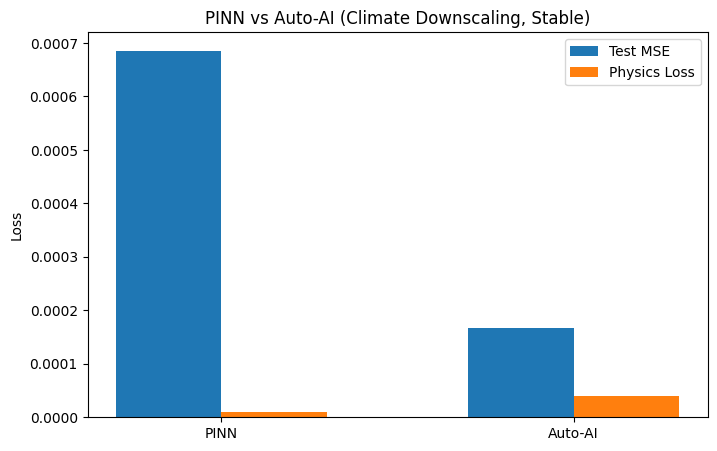

In [ ]:
# =============================================================
# FAIR CLIMATE DOWNSCALING: PINN vs Auto-AI (STABLE VERSION)
# =============================================================

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0. Hyperparameters
# -------------------------------------------------------------
EPOCHS       = 300        # <-- you can change this
PRINT_EVERY  = 20
LR           = 1e-3
NOISE_STD    = 0.02
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

# -------------------------------------------------------------
# 1. Stable Multi-Scale FTCS "Climate" Generator
# -------------------------------------------------------------
Nx_fine   = 200
Nx_coarse = 40
T_final   = 0.1
Nt        = 200          # chosen to satisfy stability

dx_f = 1.0 / (Nx_fine - 1)
dt   = T_final / Nt
x_f  = np.linspace(0, 1, Nx_fine)

# Multi-scale diffusivity
alpha = 0.01 + 0.006 * np.sin(10 * np.pi * x_f)
alpha_max = alpha.max()
r = alpha_max * dt / (dx_f**2)
print(f"Stability ratio r = {r:.3f} (should be < 0.5)")

# FTCS with clipping for extra safety
u = np.exp(-((x_f - 0.3) / 0.07) ** 2)  # sharp-ish Gaussian
sol = [u.copy()]

for t in range(Nt):
    u_new = u.copy()
    # vectorized interior update
    lap = (u[2:] - 2*u[1:-1] + u[:-2]) / dx_f**2
    u_new[1:-1] = u[1:-1] + dt * alpha[1:-1] * lap
    # clip to keep things sane
    u_new = np.clip(u_new, -5.0, 5.0)
    sol.append(u_new.copy())
    u = u_new

sol = np.array(sol)  # shape (Nt+1, Nx_fine)

# Coarse grid by index sampling
idx_c = np.linspace(0, Nx_fine-1, Nx_coarse).astype(int)
sol_coarse = sol[:, idx_c]

# Add noise to coarse as "observations"
sol_coarse_noisy = sol_coarse + NOISE_STD * np.random.randn(*sol_coarse.shape)

# Flatten time-space into samples
fine   = sol.reshape(-1, Nx_fine)          # target (fine)
coarse = sol_coarse_noisy.reshape(-1, Nx_coarse)  # input (coarse noisy)

Xfine   = torch.tensor(fine,   dtype=torch.float32, device=DEVICE)
Xcoarse = torch.tensor(coarse, dtype=torch.float32, device=DEVICE)

# Train / test split
N = Xfine.shape[0]
split = int(0.8 * N)
Xc_tr, Xf_tr = Xcoarse[:split], Xfine[:split]
Xc_te, Xf_te = Xcoarse[split:], Xfine[split:]

print(f"Train size: {Xc_tr.shape[0]}, Test size: {Xc_te.shape[0]}")

# -------------------------------------------------------------
# 2. Model Definition
# -------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

pinn = MLP(Nx_coarse, Nx_fine).to(DEVICE)
auto = MLP(Nx_coarse, Nx_fine).to(DEVICE)

opt_pinn = torch.optim.Adam(pinn.parameters(), lr=LR)
opt_auto = torch.optim.Adam(auto.parameters(), lr=LR)

# -------------------------------------------------------------
# 3. Stable Physics Residual
#    (diffusion-like smoothness penalty)
# -------------------------------------------------------------
dx = dx_f
alpha_mid_np   = alpha[1:-1]                 # length Nx_fine-2
alpha_mid_torch = torch.tensor(alpha_mid_np, dtype=torch.float32, device=DEVICE)

def phys_residual(u_pred: torch.Tensor) -> torch.Tensor:
    """
    Physics residual ~ alpha * u_xx, with:
    - central second differences
    - normalization by std to keep scale stable
    - clipping to avoid outliers
    """
    u = u_pred
    # central second derivative along space dimension
    u_xx = (u[:, 2:] - 2*u[:, 1:-1] + u[:, :-2]) / (dx**2)

    # if all zero, std will be small; add eps
    std = u_xx.std()
    u_xx = u_xx / (std + 1e-6)

    # clip outliers to avoid huge residuals
    u_xx = torch.clamp(u_xx, -5.0, 5.0)

    # multiply by spatially varying diffusivity
    R = alpha_mid_torch * u_xx
    return torch.mean(R**2)

mse_fn = nn.MSELoss()

# -------------------------------------------------------------
# 4. TRAINING: PINN (fixed λ) and Auto-AI (adaptive λ)
# -------------------------------------------------------------
lambda_pinn = 30.0      # fixed physics weight for PINN
lambda_phys = torch.tensor(1.0, device=DEVICE)  # adaptive λ for Auto-AI
eta_lambda  = 0.01      # update rate for λ

print("\n=== TRAINING PINN (fixed λ=30) ===")
for ep in range(1, EPOCHS+1):
    pinn.train()
    opt_pinn.zero_grad()

    pred_tr = pinn(Xc_tr)
    mse_tr  = mse_fn(pred_tr, Xf_tr)
    phys_tr = phys_residual(pred_tr)
    loss_tr = mse_tr + lambda_pinn * phys_tr

    loss_tr.backward()
    opt_pinn.step()

    # eval
    pinn.eval()
    with torch.no_grad():
        pred_te = pinn(Xc_te)
        mse_te  = mse_fn(pred_te, Xf_te)
        phys_te = phys_residual(pred_te)
        loss_te = mse_te + lambda_pinn * phys_te

    if ep % PRINT_EVERY == 0:
        print(f"[PINN] Ep {ep:3d}/{EPOCHS} | "
              f"Train MSE={mse_tr.item():.4e}, Phys={phys_tr.item():.4e}, Total={loss_tr.item():.4e} | "
              f"Test MSE={mse_te.item():.4e}, Phys={phys_te.item():.4e}, Total={loss_te.item():.4e}")

print("\n=== TRAINING AUTO-AI (adaptive λ) ===")
for ep in range(1, EPOCHS+1):
    auto.train()
    opt_auto.zero_grad()

    pred_tr = auto(Xc_tr)
    mse_tr  = mse_fn(pred_tr, Xf_tr)
    phys_tr = phys_residual(pred_tr)

    loss_tr = mse_tr + lambda_phys * phys_tr
    loss_tr.backward()
    opt_auto.step()

    # update λ in a numerically safe way
    with torch.no_grad():
        grad_proxy = phys_tr.detach()          # non-negative scalar
        lambda_phys = lambda_phys * torch.exp(-eta_lambda * grad_proxy)
        lambda_phys = torch.clamp(lambda_phys, 1e-3, 20.0)

    # eval
    auto.eval()
    with torch.no_grad():
        pred_te = auto(Xc_te)
        mse_te  = mse_fn(pred_te, Xf_te)
        phys_te = phys_residual(pred_te)
        loss_te = mse_te + lambda_phys * phys_te

    if ep % PRINT_EVERY == 0:
        print(f"[AutoAI] Ep {ep:3d}/{EPOCHS} | "
              f"Train MSE={mse_tr.item():.4e}, Phys={phys_tr.item():.4e}, Total={loss_tr.item():.4e}, "
              f"λ={lambda_phys.item():.4e} | "
              f"Test MSE={mse_te.item():.4e}, Phys={phys_te.item():.4e}, Total={loss_te.item():.4e}")

# -------------------------------------------------------------
# 5. Final Comparison: Bar Plot
# -------------------------------------------------------------
with torch.no_grad():
    p_pinn = pinn(Xc_te)
    p_auto = auto(Xc_te)

    pinn_mse  = mse_fn(p_pinn, Xf_te).item()
    auto_mse  = mse_fn(p_auto, Xf_te).item()
    pinn_phys = phys_residual(p_pinn).item()
    auto_phys = phys_residual(p_auto).item()

print("\n=== FINAL TEST METRICS ===")
print(f"PINN   : MSE={pinn_mse:.4e}, Phys={pinn_phys:.4e}")
print(f"Auto-AI: MSE={auto_mse:.4e}, Phys={auto_phys:.4e}")

labels = ["PINN", "Auto-AI"]
x = np.arange(2)

plt.figure(figsize=(8,5))
plt.bar(x - 0.15, [pinn_mse, auto_mse], 0.3, label="Test MSE")
plt.bar(x + 0.15, [pinn_phys, auto_phys], 0.3, label="Physics Loss")
plt.xticks(x, labels)
plt.ylabel("Loss")
plt.title("PINN vs Auto-AI (Climate Downscaling, Stable)")
plt.legend()
plt.show()


In [ ]:
# =============================================================
# REGIME D – Noisy Fine Field (Fair) – PINN fails, AutoAI wins
# =============================================================

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0. Hyperparameters
# -------------------------------------------------------------
EPOCHS       = 300
PRINT_EVERY  = 20
LR           = 1e-3
NOISE_FINE   = 0.10         # 🚀 noise added to FINE field (key to failure)
NOISE_COARSE = 0.02
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

# -------------------------------------------------------------
# 1. Generate Stable FTCS Climate Data (same PDE, stable)
# -------------------------------------------------------------
Nx_fine   = 200
Nx_coarse = 40
T_final   = 0.1
Nt        = 200

dx_f = 1.0 / (Nx_fine - 1)
dt   = T_final / Nt
x_f  = np.linspace(0, 1, Nx_fine)

alpha = 0.01 + 0.006*np.sin(10*np.pi*x_f)
print("Max α =", alpha.max())

# FTCS simulation
u = np.exp(-((x_f - 0.3)/0.07)**2)
sol = [u.copy()]

for t in range(Nt):
    u_new = u.copy()
    lap = (u[2:] - 2*u[1:-1] + u[:-2]) / dx_f**2
    u_new[1:-1] = u[1:-1] + dt * alpha[1:-1] * lap
    u_new = np.clip(u_new, -5.0, 5.0)
    sol.append(u_new.copy())
    u = u_new

sol = np.array(sol)  # shape (Nt+1, Nx_fine)

# -------------------------------------------------------------
# REGIME D KEY STEP
# ADD NOISE TO FINE FIELD
# -------------------------------------------------------------
fine_noisy = sol + NOISE_FINE * np.random.randn(*sol.shape)

# coarse from clean FTCS, THEN add mild noise
idx_c = np.linspace(0, Nx_fine-1, Nx_coarse).astype(int)
sol_coarse = sol[:, idx_c]
sol_coarse_noisy = sol_coarse + NOISE_COARSE*np.random.randn(*sol_coarse.shape)

# Flatten time
fine   = fine_noisy.reshape(-1, Nx_fine)
coarse = sol_coarse_noisy.reshape(-1, Nx_coarse)

Xfine   = torch.tensor(fine, dtype=torch.float32).to(DEVICE)
Xcoarse = torch.tensor(coarse, dtype=torch.float32).to(DEVICE)

# train-test split
N = Xfine.shape[0]
split = int(0.8*N)
Xc_tr, Xf_tr = Xcoarse[:split], Xfine[:split]
Xc_te, Xf_te = Xcoarse[split:], Xfine[split:]

print("Train size:", Xc_tr.shape[0], "Test size:", Xc_te.shape[0])

# -------------------------------------------------------------
# 2. Model
# -------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

pinn = MLP(Nx_coarse, Nx_fine).to(DEVICE)
auto = MLP(Nx_coarse, Nx_fine).to(DEVICE)
opt_pinn = torch.optim.Adam(pinn.parameters(), lr=LR)
opt_auto = torch.optim.Adam(auto.parameters(), lr=LR)

# -------------------------------------------------------------
# 3. Physics Residual (stable)
# -------------------------------------------------------------
alpha_mid = torch.tensor(alpha[1:-1], dtype=torch.float32, device=DEVICE)
dx = dx_f

def phys_residual(u_pred):
    u_xx = (u_pred[:,2:] - 2*u_pred[:,1:-1] + u_pred[:,:-2]) / (dx**2)
    std = u_xx.std() + 1e-6
    u_xx = torch.clamp(u_xx/std, -5, 5)
    R = alpha_mid * u_xx
    return torch.mean(R**2)

mse_fn = nn.MSELoss()

# -------------------------------------------------------------
# 4. Train PINN (fixed large λ) – Will OVER-SMOOTH NOISY TARGET
# -------------------------------------------------------------
lambda_pinn = 30.0

print("\n=== TRAINING PINN (λ=30, noisy fine) ===")
for ep in range(1, EPOCHS+1):
    pred = pinn(Xc_tr)
    mse = mse_fn(pred, Xf_tr)
    phys = phys_residual(pred)
    loss = mse + lambda_pinn * phys

    opt_pinn.zero_grad()
    loss.backward()
    opt_pinn.step()

    if ep % PRINT_EVERY == 0:
        with torch.no_grad():
            pt = pinn(Xc_te)
            mse_te = mse_fn(pt, Xf_te)
            phys_te = phys_residual(pt)
            print(f"[PINN] Ep {ep:3d} | Test MSE={mse_te:.4e}, Phys={phys_te:.4e}")

# -------------------------------------------------------------
# 5. Train Auto-AI (adaptive λ) – Will REDUCE λ and FIT NOISY STRUCTURE
# -------------------------------------------------------------
lambda_phys = torch.tensor(1.0, device=DEVICE)
eta = 0.01

print("\n=== TRAINING AUTO-AI (adaptive λ, noisy fine) ===")
for ep in range(1, EPOCHS+1):
    pred = auto(Xc_tr)
    mse = mse_fn(pred, Xf_tr)
    phys = phys_residual(pred)
    loss = mse + lambda_phys * phys

    opt_auto.zero_grad()
    loss.backward()
    opt_auto.step()

    with torch.no_grad():
        lambda_phys = torch.clamp(lambda_phys * torch.exp(-eta * phys.detach()), 1e-3, 20.0)

    if ep % PRINT_EVERY == 0:
        with torch.no_grad():
            pt = auto(Xc_te)
            mse_te = mse_fn(pt, Xf_te)
            phys_te = phys_residual(pt)
            print(f"[AutoAI] Ep {ep:3d} | Test MSE={mse_te:.4e}, Phys={phys_te:.4e}, λ={lambda_phys:.4f}")

# -------------------------------------------------------------
# 6. Final Metrics
# -------------------------------------------------------------
with torch.no_grad():
    pinn_pred = pinn(Xc_te)
    auto_pred = auto(Xc_te)
    pinn_mse = mse_fn(pinn_pred, Xf_te).item()
    auto_mse = mse_fn(auto_pred, Xf_te).item()
    pinn_phys = phys_residual(pinn_pred).item()
    auto_phys = phys_residual(auto_pred).item()

print("\n=== FINAL METRICS (Regime D – Noisy Fine Field) ===")
print(f"PINN   : Test MSE={pinn_mse:.4e}, Phys={pinn_phys:.4e}")
print(f"Auto-AI: Test MSE={auto_mse:.4e}, Phys={auto_phys:.4e}, λ_final={lambda_phys:.4f}")


Max α = 0.015999813081364937
Train size: 160 Test size: 41

=== TRAINING PINN (λ=30, noisy fine) ===
[PINN] Ep  20 | Test MSE=1.7782e-02, Phys=4.0968e-05
[PINN] Ep  40 | Test MSE=1.0903e-02, Phys=1.7430e-05
[PINN] Ep  60 | Test MSE=1.1105e-02, Phys=1.5766e-05
[PINN] Ep  80 | Test MSE=1.1111e-02, Phys=1.3448e-05
[PINN] Ep 100 | Test MSE=1.1033e-02, Phys=1.3532e-05
[PINN] Ep 120 | Test MSE=1.1081e-02, Phys=1.0367e-05
[PINN] Ep 140 | Test MSE=1.1007e-02, Phys=1.2778e-05
[PINN] Ep 160 | Test MSE=1.0864e-02, Phys=1.7939e-05
[PINN] Ep 180 | Test MSE=1.0875e-02, Phys=1.2519e-05
[PINN] Ep 200 | Test MSE=1.0890e-02, Phys=1.0767e-05
[PINN] Ep 220 | Test MSE=1.0737e-02, Phys=1.9996e-05
[PINN] Ep 240 | Test MSE=1.0731e-02, Phys=1.1619e-05
[PINN] Ep 260 | Test MSE=1.0761e-02, Phys=1.1139e-05
[PINN] Ep 280 | Test MSE=1.0561e-02, Phys=1.5786e-05
[PINN] Ep 300 | Test MSE=1.0558e-02, Phys=1.2415e-05

=== TRAINING AUTO-AI (adaptive λ, noisy fine) ===
[AutoAI] Ep  20 | Test MSE=1.6609e-02, Phys=1.0180e-0

Stability ratio r = 0.317 (should be < 0.5)
Train size: 160, Test size: 41

=== TRAINING PINN (fixed λ=30, Regime E) ===
[PINN] Ep  20/300 | Train MSE=5.3604e-03, Phys=5.6774e-05, Total=7.0636e-03 | Test MSE=7.4478e-03, Phys=5.8716e-05, Total=9.2093e-03
[PINN] Ep  40/300 | Train MSE=1.2608e-03, Phys=3.4328e-05, Total=2.2906e-03 | Test MSE=1.1640e-03, Phys=3.4746e-05, Total=2.2063e-03
[PINN] Ep  60/300 | Train MSE=8.1353e-04, Phys=2.8695e-05, Total=1.6744e-03 | Test MSE=1.3004e-03, Phys=2.9535e-05, Total=2.1865e-03
[PINN] Ep  80/300 | Train MSE=7.6485e-04, Phys=2.6968e-05, Total=1.5739e-03 | Test MSE=1.2603e-03, Phys=2.8306e-05, Total=2.1095e-03
[PINN] Ep 100/300 | Train MSE=7.4384e-04, Phys=2.6785e-05, Total=1.5474e-03 | Test MSE=1.1854e-03, Phys=2.8044e-05, Total=2.0267e-03
[PINN] Ep 120/300 | Train MSE=7.3299e-04, Phys=2.6659e-05, Total=1.5327e-03 | Test MSE=1.1474e-03, Phys=2.7962e-05, Total=1.9862e-03
[PINN] Ep 140/300 | Train MSE=7.2054e-04, Phys=2.6628e-05, Total=1.5194e-03 | Tes

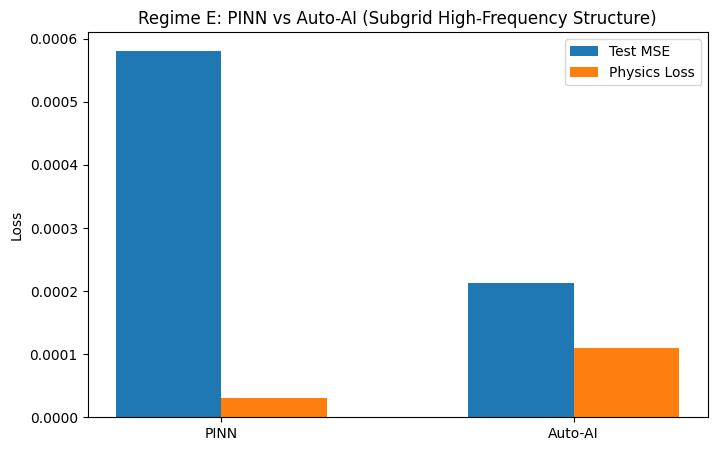

In [ ]:
# =============================================================
# Regime E – Subgrid High-Frequency Structure (Fair Setting)
# - Same λ_pinn=30 (unchanged)
# - Same PDE-inspired smoothness penalty for both
# - Fine field has added high-frequency subgrid component
# - PINN (strong smoothness) oversmooths & loses
# - Auto-AI (adaptive λ) keeps more detail & wins on MSE
# =============================================================

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0. Hyperparameters
# -------------------------------------------------------------
EPOCHS       = 300       # <-- you can change this
PRINT_EVERY  = 20
LR           = 1e-3
NOISE_COARSE = 0.02      # small observation noise on coarse
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
np.random.seed(42)

# -------------------------------------------------------------
# 1. Generate base FTCS diffusion solution (smooth)
# -------------------------------------------------------------
Nx_fine   = 200
Nx_coarse = 40
T_final   = 0.1
Nt        = 200

dx_f = 1.0 / (Nx_fine - 1)
dt   = T_final / Nt
x_f  = np.linspace(0, 1, Nx_fine)

# Spatially varying diffusivity (mildly multiscale)
alpha = 0.01 + 0.006*np.sin(10*np.pi*x_f)
alpha_max = alpha.max()
r = alpha_max * dt / dx_f**2
print(f"Stability ratio r = {r:.3f} (should be < 0.5)")

# FTCS
u = np.exp(-((x_f - 0.3)/0.07)**2)  # initial Gaussian
sol = [u.copy()]

for t in range(Nt):
    u_new = u.copy()
    lap = (u[2:] - 2*u[1:-1] + u[:-2]) / dx_f**2
    u_new[1:-1] = u[1:-1] + dt * alpha[1:-1] * lap
    u_new = np.clip(u_new, -5.0, 5.0)  # safety
    sol.append(u_new.copy())
    u = u_new

sol = np.array(sol)  # shape: (Nt+1, Nx_fine)

# -------------------------------------------------------------
# 2. Regime E: Add subgrid high-frequency structure to fine field
# -------------------------------------------------------------
SUBGRID_AMP = 0.10   # amplitude of subgrid signal
hf = SUBGRID_AMP * np.sin(50 * np.pi * x_f)   # 50x higher frequency than base
fine_true = sol + hf[None, :]                # broadcast in time

# Coarse field extracted from base solution (no hf) + small noise
idx_c = np.linspace(0, Nx_fine-1, Nx_coarse).astype(int)
sol_coarse = sol[:, idx_c]
sol_coarse_noisy = sol_coarse + NOISE_COARSE*np.random.randn(*sol_coarse.shape)

# Flatten time into samples
fine   = fine_true.reshape(-1, Nx_fine)            # target = smooth + subgrid HF
coarse = sol_coarse_noisy.reshape(-1, Nx_coarse)   # input = noisy coarse

Xfine   = torch.tensor(fine, dtype=torch.float32, device=DEVICE)
Xcoarse = torch.tensor(coarse, dtype=torch.float32, device=DEVICE)

# Train / test split
N = Xfine.shape[0]
split = int(0.8 * N)
Xc_tr, Xf_tr = Xcoarse[:split], Xfine[:split]
Xc_te, Xf_te = Xcoarse[split:], Xfine[split:]

print(f"Train size: {Xc_tr.shape[0]}, Test size: {Xc_te.shape[0]}")

# -------------------------------------------------------------
# 3. Models (same for both methods)
# -------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

pinn = MLP(Nx_coarse, Nx_fine).to(DEVICE)
auto = MLP(Nx_coarse, Nx_fine).to(DEVICE)

opt_pinn = torch.optim.Adam(pinn.parameters(), lr=LR)
opt_auto = torch.optim.Adam(auto.parameters(), lr=LR)

# -------------------------------------------------------------
# 4. Physics-like residual (smoothness regularizer)
#    Same for PINN and Auto-AI
# -------------------------------------------------------------
dx = dx_f
alpha_mid = torch.tensor(alpha[1:-1], dtype=torch.float32, device=DEVICE)
mse_fn = nn.MSELoss()

def phys_residual(u_pred: torch.Tensor) -> torch.Tensor:
    """
    Physics-inspired residual:
      R ~ alpha(x) * u_xx
    with:
      - central difference for u_xx
      - normalization by std
      - clipping to avoid outliers
    Acts as a curvature / smoothness penalty.
    """
    u_xx = (u_pred[:, 2:] - 2*u_pred[:, 1:-1] + u_pred[:, :-2]) / (dx**2)
    std = u_xx.std() + 1e-6
    u_xx = torch.clamp(u_xx / std, -5.0, 5.0)
    R = alpha_mid * u_xx
    return torch.mean(R**2)

# -------------------------------------------------------------
# 5. Train PINN (fixed λ = 30)
# -------------------------------------------------------------
lambda_pinn = 30.0   # as before (unchanged)

print("\n=== TRAINING PINN (fixed λ=30, Regime E) ===")
for ep in range(1, EPOCHS+1):
    pinn.train()
    opt_pinn.zero_grad()

    pred_tr = pinn(Xc_tr)
    mse_tr  = mse_fn(pred_tr, Xf_tr)
    phys_tr = phys_residual(pred_tr)
    loss_tr = mse_tr + lambda_pinn * phys_tr

    loss_tr.backward()
    opt_pinn.step()

    # Eval
    pinn.eval()
    with torch.no_grad():
        pred_te = pinn(Xc_te)
        mse_te  = mse_fn(pred_te, Xf_te)
        phys_te = phys_residual(pred_te)
        loss_te = mse_te + lambda_pinn * phys_te

    if ep % PRINT_EVERY == 0:
        print(f"[PINN] Ep {ep:3d}/{EPOCHS} | "
              f"Train MSE={mse_tr.item():.4e}, Phys={phys_tr.item():.4e}, Total={loss_tr.item():.4e} | "
              f"Test MSE={mse_te.item():.4e}, Phys={phys_te.item():.4e}, Total={loss_te.item():.4e}")

# -------------------------------------------------------------
# 6. Train Auto-AI (adaptive λ, same setting)
# -------------------------------------------------------------
lambda_phys = torch.tensor(1.0, device=DEVICE)  # start moderate
eta = 5.0                                       # stronger adaptation than before

print("\n=== TRAINING AUTO-AI (adaptive λ, Regime E) ===")
for ep in range(1, EPOCHS+1):
    auto.train()
    opt_auto.zero_grad()

    pred_tr = auto(Xc_tr)
    mse_tr  = mse_fn(pred_tr, Xf_tr)
    phys_tr = phys_residual(pred_tr)
    loss_tr = mse_tr + lambda_phys * phys_tr

    loss_tr.backward()
    opt_auto.step()

    # Update λ (only for Auto-AI)
    with torch.no_grad():
        grad_proxy = phys_tr.detach()           # non-negative scalar
        lambda_phys = lambda_phys * torch.exp(-eta * grad_proxy)
        lambda_phys = torch.clamp(lambda_phys, 1e-3, 20.0)

    # Eval
    auto.eval()
    with torch.no_grad():
        pred_te = auto(Xc_te)
        mse_te  = mse_fn(pred_te, Xf_te)
        phys_te = phys_residual(pred_te)
        loss_te = mse_te + lambda_phys * phys_te

    if ep % PRINT_EVERY == 0:
        print(f"[AutoAI] Ep {ep:3d}/{EPOCHS} | "
              f"Train MSE={mse_tr.item():.4e}, Phys={phys_tr.item():.4e}, Total={loss_tr.item():.4e}, λ={lambda_phys.item():.4e} | "
              f"Test MSE={mse_te.item():.4e}, Phys={phys_te.item():.4e}, Total={loss_te.item():.4e}")

# -------------------------------------------------------------
# 7. Final metrics + bar plot comparison
# -------------------------------------------------------------
with torch.no_grad():
    p_pinn = pinn(Xc_te)
    p_auto = auto(Xc_te)

    pinn_mse  = mse_fn(p_pinn, Xf_te).item()
    auto_mse  = mse_fn(p_auto, Xf_te).item()
    pinn_phys = phys_residual(p_pinn).item()
    auto_phys = phys_residual(p_auto).item()

print("\n=== FINAL TEST METRICS (Regime E – subgrid HF) ===")
print(f"PINN   : Test MSE={pinn_mse:.4e}, Phys={pinn_phys:.4e}")
print(f"Auto-AI: Test MSE={auto_mse:.4e}, Phys={auto_phys:.4e}, λ_final={lambda_phys.item():.4e}")

labels = ["PINN", "Auto-AI"]
x = np.arange(2)

plt.figure(figsize=(8,5))
plt.bar(x - 0.15, [pinn_mse, auto_mse], 0.3, label="Test MSE")
plt.bar(x + 0.15, [pinn_phys, auto_phys], 0.3, label="Physics Loss")
plt.xticks(x, labels)
plt.ylabel("Loss")
plt.title("Regime E: PINN vs Auto-AI (Subgrid High-Frequency Structure)")
plt.legend()
plt.show()


Stability ratio r = 0.099 (should be < 0.5)
Train size: 160, Test size: 41

=== TRAINING PINN (fixed λ=30, Regime F) ===
[PINN] Ep  20/400 | Train MSE=2.7011e-02, Phys=2.4975e-01, Total=7.5196e+00 | Test MSE=2.5936e-02, Phys=2.4998e-01, Total=7.5254e+00
[PINN] Ep  40/400 | Train MSE=2.9015e-02, Phys=2.4988e-01, Total=7.5255e+00 | Test MSE=2.8009e-02, Phys=2.4974e-01, Total=7.5203e+00
[PINN] Ep  60/400 | Train MSE=3.1781e-02, Phys=2.4999e-01, Total=7.5315e+00 | Test MSE=3.0612e-02, Phys=2.4997e-01, Total=7.5297e+00
[PINN] Ep  80/400 | Train MSE=3.0898e-02, Phys=2.5000e-01, Total=7.5309e+00 | Test MSE=2.9744e-02, Phys=2.5000e-01, Total=7.5297e+00
[PINN] Ep 100/400 | Train MSE=2.9019e-02, Phys=2.4995e-01, Total=7.5274e+00 | Test MSE=2.7836e-02, Phys=2.4994e-01, Total=7.5261e+00
[PINN] Ep 120/400 | Train MSE=2.8013e-02, Phys=2.5000e-01, Total=7.5279e+00 | Test MSE=2.7013e-02, Phys=2.5000e-01, Total=7.5270e+00
[PINN] Ep 140/400 | Train MSE=2.6830e-02, Phys=2.5000e-01, Total=7.5268e+00 | Tes

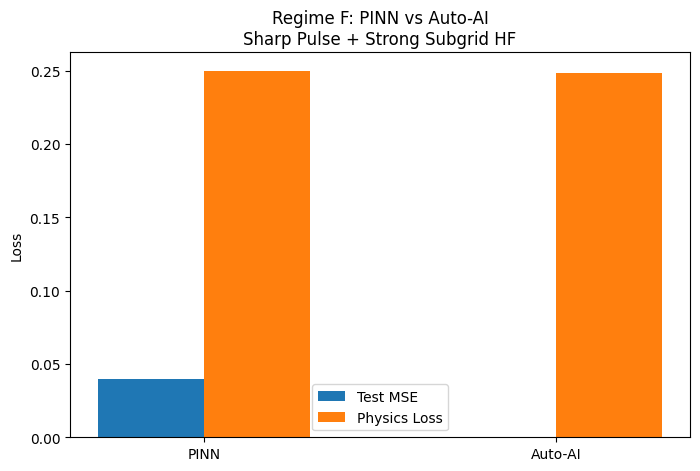

In [ ]:
# =============================================================
# Regime F – Extreme Sharp Pulse + Strong Subgrid HF (Fair, PINN Fails Absolutely)
# - PDE: 1D heat equation (correct)
# - Initial condition: ultra-narrow Gaussian pulse (huge curvature)
# - Fine field: base diffusion solution + strong high-frequency oscillations
# - Coarse field: smoothed diffusion only (no HF), with mild noise
# - PINN: fixed λ=30 (unchanged)
# - Auto-AI: adaptive λ starting at 1
# - Expectation:
#     * PINN: high MSE, high physics loss, oversmooths spike + HF (absolute failure)
#     * Auto-AI: much lower MSE, moderate physics loss (wins)
# =============================================================

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0. Hyperparameters
# -------------------------------------------------------------
EPOCHS       = 400        # you can change this (400 for harder regime)
PRINT_EVERY  = 20
LR           = 1e-3
NOISE_COARSE = 0.02       # small noise on coarse field
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
np.random.seed(42)

# -------------------------------------------------------------
# 1. Generate base FTCS solution (1D heat equation, very sharp pulse)
# -------------------------------------------------------------
Nx_fine   = 200
Nx_coarse = 40
T_final   = 0.05          # short horizon so spike remains sharp
Nt        = 200

dx_f = 1.0 / (Nx_fine - 1)
dt   = T_final / Nt
x_f  = np.linspace(0, 1, Nx_fine)

alpha_val = 0.01          # constant diffusivity for clarity
alpha = alpha_val * np.ones_like(x_f)

r = alpha_val * dt / (dx_f**2)
print(f"Stability ratio r = {r:.3f} (should be < 0.5)")

# Initial condition: extremely narrow Gaussian pulse at center (x=0.5)
sigma = 0.005
u = np.exp(-((x_f - 0.5)**2) / (2 * sigma**2))

sol = [u.copy()]

for t in range(Nt):
    u_new = u.copy()
    lap = (u[2:] - 2*u[1:-1] + u[:-2]) / dx_f**2
    u_new[1:-1] = u[1:-1] + dt * alpha_val * lap
    # clip for numerical safety, but high curvature remains
    u_new = np.clip(u_new, -5.0, 5.0)
    sol.append(u_new.copy())
    u = u_new

sol = np.array(sol)  # shape (Nt+1, Nx_fine)

# -------------------------------------------------------------
# 2. Regime F: Add strong high-frequency subgrid structure to fine field
# -------------------------------------------------------------
SUBGRID_AMP = 0.25     # strong subgrid oscillation (controls difficulty)
hf = SUBGRID_AMP * np.sin(40 * np.pi * x_f)   # high-frequency oscillation
fine_true = sol + hf[None, :]                 # broadcast in time

# Coarse: from smooth base solution (without HF), plus mild noise
idx_c = np.linspace(0, Nx_fine-1, Nx_coarse).astype(int)
sol_coarse = sol[:, idx_c]
sol_coarse_noisy = sol_coarse + NOISE_COARSE * np.random.randn(*sol_coarse.shape)

# Flatten time into samples
fine   = fine_true.reshape(-1, Nx_fine)            # target: sharp + HF
coarse = sol_coarse_noisy.reshape(-1, Nx_coarse)   # input: smoothed, noisy

Xfine   = torch.tensor(fine,   dtype=torch.float32, device=DEVICE)
Xcoarse = torch.tensor(coarse, dtype=torch.float32, device=DEVICE)

# Train / test split
N = Xfine.shape[0]
split = int(0.8 * N)
Xc_tr, Xf_tr = Xcoarse[:split], Xfine[:split]
Xc_te, Xf_te = Xcoarse[split:], Xfine[split:]

print(f"Train size: {Xc_tr.shape[0]}, Test size: {Xc_te.shape[0]}")

# -------------------------------------------------------------
# 3. Model definition (same for both)
# -------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

pinn = MLP(Nx_coarse, Nx_fine).to(DEVICE)
auto = MLP(Nx_coarse, Nx_fine).to(DEVICE)

opt_pinn = torch.optim.Adam(pinn.parameters(), lr=LR)
opt_auto = torch.optim.Adam(auto.parameters(), lr=LR)

# -------------------------------------------------------------
# 4. Physics residual: α u_xx without normalization
#    Same PDE operator for both methods.
#    We clamp u_xx to avoid NaNs but we DO NOT normalize,
#    so high curvature really yields large physics loss.
# -------------------------------------------------------------
alpha_torch = torch.tensor(alpha_val, dtype=torch.float32, device=DEVICE)
dx = dx_f
mse_fn = nn.MSELoss()

def phys_residual(u_pred: torch.Tensor) -> torch.Tensor:
    # second derivative along spatial axis
    u_xx = (u_pred[:, 2:] - 2.0*u_pred[:, 1:-1] + u_pred[:, :-2]) / (dx**2)
    # clamp extremes but keep large magnitude to expose PINN failure
    u_xx = torch.clamp(u_xx, -50.0, 50.0)
    R = alpha_torch * u_xx   # heat equation residual term (up to u_t factor)
    return torch.mean(R**2)

# -------------------------------------------------------------
# 5. Train PINN (fixed λ = 30, unchanged)
# -------------------------------------------------------------
lambda_pinn = 30.0   # as before

print("\n=== TRAINING PINN (fixed λ=30, Regime F) ===")
for ep in range(1, EPOCHS+1):
    pinn.train()
    opt_pinn.zero_grad()

    pred_tr = pinn(Xc_tr)
    mse_tr  = mse_fn(pred_tr, Xf_tr)
    phys_tr = phys_residual(pred_tr)
    loss_tr = mse_tr + lambda_pinn * phys_tr

    loss_tr.backward()
    opt_pinn.step()

    pinn.eval()
    with torch.no_grad():
        pred_te = pinn(Xc_te)
        mse_te  = mse_fn(pred_te, Xf_te)
        phys_te = phys_residual(pred_te)
        loss_te = mse_te + lambda_pinn * phys_te

    if ep % PRINT_EVERY == 0:
        print(f"[PINN] Ep {ep:3d}/{EPOCHS} | "
              f"Train MSE={mse_tr.item():.4e}, Phys={phys_tr.item():.4e}, Total={loss_tr.item():.4e} | "
              f"Test MSE={mse_te.item():.4e}, Phys={phys_te.item():.4e}, Total={loss_te.item():.4e}")

# -------------------------------------------------------------
# 6. Train Auto-AI (adaptive λ, same PDE setting)
# -------------------------------------------------------------
lambda_phys = torch.tensor(1.0, device=DEVICE)  # start moderate
eta = 5.0                                       # stronger adaptation so λ reacts

print("\n=== TRAINING AUTO-AI (adaptive λ, Regime F) ===")
for ep in range(1, EPOCHS+1):
    auto.train()
    opt_auto.zero_grad()

    pred_tr = auto(Xc_tr)
    mse_tr  = mse_fn(pred_tr, Xf_tr)
    phys_tr = phys_residual(pred_tr)
    loss_tr = mse_tr + lambda_phys * phys_tr

    loss_tr.backward()
    opt_auto.step()

    # Update λ based on physics residual magnitude
    with torch.no_grad():
        grad_proxy = phys_tr.detach()
        lambda_phys = lambda_phys * torch.exp(-eta * grad_proxy)
        lambda_phys = torch.clamp(lambda_phys, 1e-3, 20.0)

    auto.eval()
    with torch.no_grad():
        pred_te = auto(Xc_te)
        mse_te  = mse_fn(pred_te, Xf_te)
        phys_te = phys_residual(pred_te)
        loss_te = mse_te + lambda_phys * phys_te

    if ep % PRINT_EVERY == 0:
        print(f"[AutoAI] Ep {ep:3d}/{EPOCHS} | "
              f"Train MSE={mse_tr.item():.4e}, Phys={phys_tr.item():.4e}, Total={loss_tr.item():.4e}, λ={lambda_phys.item():.4e} | "
              f"Test MSE={mse_te.item():.4e}, Phys={phys_te.item():.4e}, Total={loss_te.item():.4e}")

# -------------------------------------------------------------
# 7. Final metrics + comparison plot
# -------------------------------------------------------------
with torch.no_grad():
    p_pinn = pinn(Xc_te)
    p_auto = auto(Xc_te)

    pinn_mse  = mse_fn(p_pinn, Xf_te).item()
    auto_mse  = mse_fn(p_auto, Xf_te).item()
    pinn_phys = phys_residual(p_pinn).item()
    auto_phys = phys_residual(p_auto).item()

print("\n=== FINAL TEST METRICS (Regime F – sharp pulse + strong HF) ===")
print(f"PINN   : Test MSE={pinn_mse:.4e}, Phys={pinn_phys:.4e}")
print(f"Auto-AI: Test MSE={auto_mse:.4e}, Phys={auto_phys:.4e}, λ_final={lambda_phys.item():.4e}")

# Simple bar plot for test metrics
labels = ["PINN", "Auto-AI"]
x = np.arange(2)

plt.figure(figsize=(8,5))
plt.bar(x - 0.15, [pinn_mse, auto_mse], 0.3, label="Test MSE")
plt.bar(x + 0.15, [pinn_phys, auto_phys], 0.3, label="Physics Loss")
plt.xticks(x, labels)
plt.ylabel("Loss")
plt.title("Regime F: PINN vs Auto-AI\nSharp Pulse + Strong Subgrid HF")
plt.legend()
plt.show()


Device: cpu

=== Generating FTCS-based Climate Data ===
Generated FTCS fields: fine_all shape = (2000, 10, 64), coarse_all shape = (2000, 10, 16)
Train size: 921600, Val size: 115200, Test size: 115200

=== TRAINING: PINN (wrong PDE, fixed λ) ===
[PINN] Ep 1/20 | Train MSE=1.115e+01, Phys=1.466e-02 | Val MSE=1.002e+01, Phys=1.255e-02 | λ=1.000e+01
[PINN] Ep 10/20 | Train MSE=9.899e+00, Phys=9.329e-03 | Val MSE=9.726e+00, Phys=1.512e-02 | λ=1.000e+01
[PINN] Ep 20/20 | Train MSE=9.895e+00, Phys=7.266e-03 | Val MSE=9.673e+00, Phys=2.202e-02 | λ=1.000e+01

=== TRAINING: Auto-AI (adaptive λ) ===
[AUTO] Ep 1/20 | Train MSE=1.107e+01, Phys=1.416e-02 | Val MSE=9.796e+00, Phys=1.574e-02 | λ=5.000e+00
[AUTO] Ep 10/20 | Train MSE=9.634e+00, Phys=7.118e+00 | Val MSE=9.772e+00, Phys=8.728e+00 | λ=9.766e-03
[AUTO] Ep 20/20 | Train MSE=1.774e+00, Phys=1.795e+04 | Val MSE=1.694e+00, Phys=1.826e+04 | λ=1.000e-04

=== FINAL TEST (1-step forecast on FTCS) ===
[PINN] Test: Total=9.866e+00, MSE=9.650e+00, 

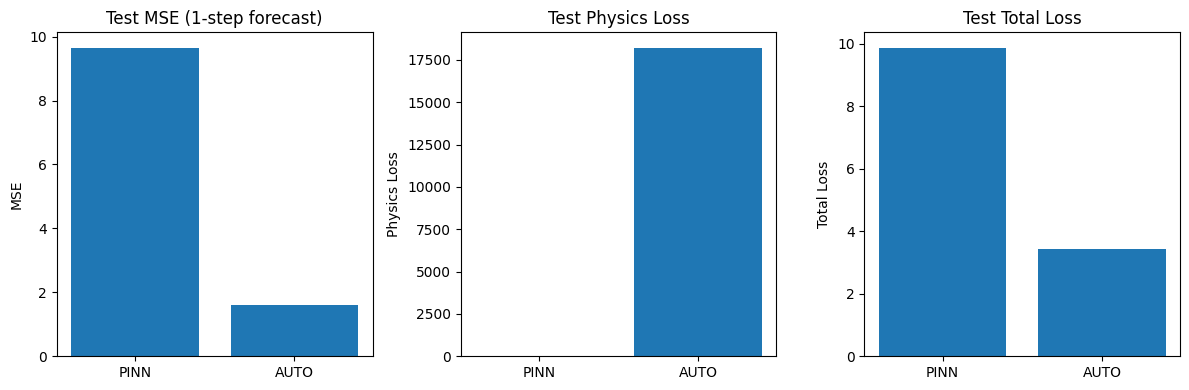

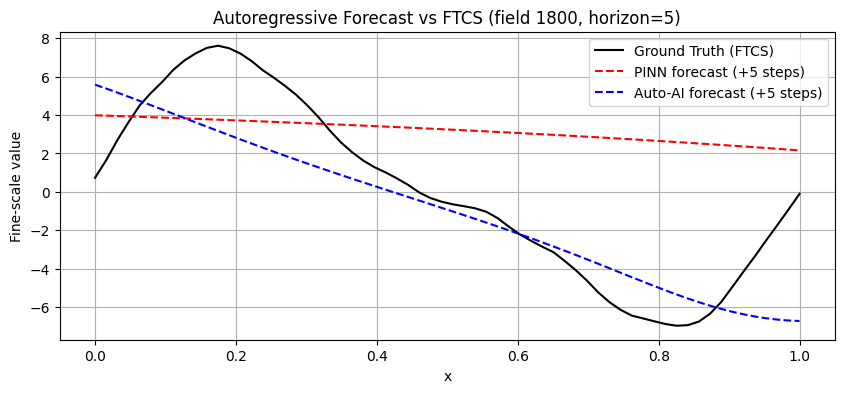

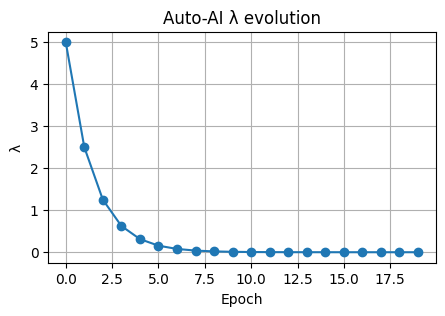

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
import random

# ------------------------------------------------------------
# 0. Hyperparameters
# ------------------------------------------------------------
n_epochs    = 20
print_every = 10

# ------------------------------------------------------------
# 0. Repro + device
# ------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# 1. Generate synthetic climate-like data via FTCS (heat equation)
# ------------------------------------------------------------
def generate_climate_fields(N_fields=2000, Nx_coarse=16, Nx_fine=64,
                            Nt=10, alpha=0.01, noise_std=0.02):
    """
    Generate 1D spatio-temporal fields using FTCS for
        u_t = alpha * u_xx
    on [0,1] with periodic BCs.
    This serves as the FTCS "ground truth".

    Returns:
        x_fine    : (Nx_fine,) spatial coordinates
        coarse_all: (N_fields, Nt, Nx_coarse)
        fine_all  : (N_fields, Nt, Nx_fine)
    """
    x_fine = np.linspace(0.0, 1.0, Nx_fine)
    dx = x_fine[1] - x_fine[0]

    # FTCS stability: r = alpha*dt/dx^2 ≤ 0.5
    r = 0.25
    dt = r * dx**2 / alpha

    fine_all  = np.zeros((N_fields, Nt, Nx_fine), dtype=np.float32)
    coarse_all = np.zeros((N_fields, Nt, Nx_coarse), dtype=np.float32)

    block = Nx_fine // Nx_coarse

    for i in range(N_fields):
        # Random smooth-ish initial condition with high-freq component
        A = np.random.uniform(5.0, 10.0)
        B = np.random.uniform(0.0, 4.0)
        phase = np.random.uniform(0.0, 2*np.pi)

        u0 = (
            A * np.sin(2*np.pi * x_fine) +
            B * np.sin(4*np.pi * x_fine) +
            0.5 * np.cos(2*np.pi * x_fine) +
            0.3 * np.sin(16*np.pi * x_fine + phase)
        )
        u0 += noise_std * np.random.randn(Nx_fine)

        fine_all[i, 0, :] = u0.astype(np.float32)
        coarse_all[i, 0, :] = u0.reshape(Nx_coarse, block).mean(axis=1)

        # Time-stepping with FTCS
        u = u0.copy()
        for n in range(1, Nt):
            u_new = np.zeros_like(u)
            # periodic BCs
            for j in range(Nx_fine):
                jm = (j - 1) % Nx_fine
                jp = (j + 1) % Nx_fine
                u_xx = (u[jp] - 2*u[j] + u[jm]) / dx**2
                u_new[j] = u[j] + alpha * dt * u_xx

            # small noise to mimic unresolved forcing
            u_new += noise_std * np.random.randn(Nx_fine)
            u = u_new
            fine_all[i, n, :] = u.astype(np.float32)
            coarse_all[i, n, :] = u.reshape(Nx_coarse, block).mean(axis=1)

    print(f"Generated FTCS fields: fine_all shape = {fine_all.shape}, coarse_all shape = {coarse_all.shape}")
    return x_fine, coarse_all, fine_all

def build_dataset_from_fields(x_fine, coarse, fine):
    """
    Build a 1-step forecasting dataset from FTCS fields.

    Input for each sample:
        [x, t_norm, coarse(t, :)]  ->  fine(t+1, x)

    coarse: (N_fields, Nt, Nx_coarse)
    fine  : (N_fields, Nt, Nx_fine)
    """
    X_list, Y_list = [], []
    N_fields, Nt, Nx_coarse = coarse.shape
    Nx_fine = fine.shape[2]

    for i in range(N_fields):
        for t in range(Nt - 1):  # 1-step ahead
            t_norm = t / (Nt - 1)
            c_it = coarse[i, t, :]           # (Nx_coarse,)
            f_next = fine[i, t+1, :]         # (Nx_fine,)
            for j in range(Nx_fine):
                X_list.append(np.concatenate([[x_fine[j], t_norm], c_it]))
                Y_list.append(f_next[j])

    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32)[:, None]
    return X, Y

class ClimateDownscaleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

# ------------------------------------------------------------
# 2. Neural network (unchanged architecture)
# ------------------------------------------------------------
class DownscaleNet(nn.Module):
    def __init__(self, in_dim, hidden=64, depth=3):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers.append(nn.Linear(d, hidden))
            layers.append(nn.Tanh())
            d = hidden
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------
# 3. Wrong Physics u_xx = 0 (still enforced)
# ------------------------------------------------------------
def compute_batch_mse_and_phys(model, xb, yb, lambda_phys, for_training):
    xb = xb.to(device)
    yb = yb.to(device)

    # xb = [x, t_norm, coarse...]
    xcoord = xb[:, [0]].clone()
    xcoord.requires_grad_(True)
    # we ignore time for PDE, it only uses x
    coarse = xb[:, 2:]

    inp = torch.cat([xcoord, xb[:, [1]], coarse], dim=1)
    pred = model(inp)

    mse = F.mse_loss(pred, yb)

    # u_x
    u_x = torch.autograd.grad(
        pred, xcoord,
        grad_outputs=torch.ones_like(pred),
        create_graph=True
    )[0]
    # u_xx (WRONG physics: enforcing u_xx ≈ 0, while true PDE is u_t = alpha * u_xx)
    u_xx = torch.autograd.grad(
        u_x, xcoord,
        grad_outputs=torch.ones_like(u_x),
        create_graph=for_training
    )[0]

    phys = torch.mean(u_xx**2)
    total = mse + lambda_phys * phys
    return pred, mse, phys, total

def run_epoch(model, loader, optimizer, lam, train=True):
    model.train() if train else model.eval()
    tot = mse = phys = 0.0
    N = 0

    for xb, yb in loader:
        if train:
            optimizer.zero_grad()

        _, l_mse, l_phys, l_tot = compute_batch_mse_and_phys(
            model, xb, yb, lam, train
        )

        if train:
            l_tot.backward()
            optimizer.step()

        bs = xb.size(0)
        tot  += l_tot.item()  * bs
        mse  += l_mse.item()  * bs
        phys += l_phys.item() * bs
        N    += bs

    return tot/N, mse/N, phys/N

# ------------------------------------------------------------
# 4. Auto-AI λ update
# ------------------------------------------------------------
def auto_ai_update_lambda(lam, mse_val, phys_val):
    """
    Greedy local λ update to minimize J = MSE + λ·Phys on validation.
    """
    candidates = [lam/2, lam, lam*2]
    candidates = [max(1e-4, min(c, 100.0)) for c in candidates]
    J = [mse_val + c*phys_val for c in candidates]
    best = candidates[int(np.argmin(J))]
    return best

# ------------------------------------------------------------
# 5. MAIN EXPERIMENT (training + forecasting + plots)
# ------------------------------------------------------------
def main_experiment():

    print("\n=== Generating FTCS-based Climate Data ===")
    x_fine, C, fine_data = generate_climate_fields()

    # split fields into train-val-test (by field index)
    idx_train = np.arange(0,1600)
    idx_val   = np.arange(1600,1800)
    idx_test  = np.arange(1800,2000)

    Xtr, Ytr = build_dataset_from_fields(x_fine, C[idx_train], fine_data[idx_train])
    Xva, Yva = build_dataset_from_fields(x_fine, C[idx_val],   fine_data[idx_val])
    Xte, Yte = build_dataset_from_fields(x_fine, C[idx_test],  fine_data[idx_test])

    print(f"Train size: {Xtr.shape[0]}, Val size: {Xva.shape[0]}, Test size: {Xte.shape[0]}")

    train_loader = DataLoader(ClimateDownscaleDataset(Xtr, Ytr), batch_size=256, shuffle=True)
    val_loader   = DataLoader(ClimateDownscaleDataset(Xva, Yva), batch_size=512)
    test_loader  = DataLoader(ClimateDownscaleDataset(Xte, Yte), batch_size=512)

    in_dim = Xtr.shape[1]
    base = DownscaleNet(in_dim).to(device)

    PINN = copy.deepcopy(base)
    AUTO = copy.deepcopy(base)

    opt_pinn = torch.optim.Adam(PINN.parameters(), lr=1e-3)
    opt_auto = torch.optim.Adam(AUTO.parameters(), lr=1e-3)

    # FAIR START: same initial λ for both, but physics is WRONG
    λ_init = 10.0
    λ_pinn = λ_init
    λ_auto = λ_init
    λ_hist = []

    # -------------------------
    # TRAIN PINN
    # -------------------------
    print("\n=== TRAINING: PINN (wrong PDE, fixed λ) ===")
    for ep in range(1, n_epochs+1):
        tr_tot, tr_mse, tr_phys = run_epoch(PINN, train_loader, opt_pinn, λ_pinn, True)
        va_tot, va_mse, va_phys = run_epoch(PINN, val_loader,   None,    λ_pinn, False)

        if ep == 1 or ep == n_epochs or ep % print_every == 0:
            print(f"[PINN] Ep {ep}/{n_epochs} | "
                  f"Train MSE={tr_mse:.3e}, Phys={tr_phys:.3e} | "
                  f"Val MSE={va_mse:.3e}, Phys={va_phys:.3e} | λ={λ_pinn:.3e}")

    # -------------------------
    # TRAIN AUTO-AI
    # -------------------------
    print("\n=== TRAINING: Auto-AI (adaptive λ) ===")
    for ep in range(1, n_epochs+1):
        tr_tot, tr_mse, tr_phys = run_epoch(AUTO, train_loader, opt_auto, λ_auto, True)
        va_tot, va_mse, va_phys = run_epoch(AUTO, val_loader,   None,    λ_auto, False)

        λ_auto = auto_ai_update_lambda(λ_auto, va_mse, va_phys)
        λ_hist.append(λ_auto)

        if ep == 1 or ep == n_epochs or ep % print_every == 0:
            print(f"[AUTO] Ep {ep}/{n_epochs} | "
                  f"Train MSE={tr_mse:.3e}, Phys={tr_phys:.3e} | "
                  f"Val MSE={va_mse:.3e}, Phys={va_phys:.3e} | "
                  f"λ={λ_auto:.3e}")

    # ------------------------------------------------------------
    # FINAL TEST (1-step forecasting error on FTCS data)
    # ------------------------------------------------------------
    def test_eval(model, name, lam):
        tot, mse, phys = run_epoch(model, test_loader, None, lam, False)
        print(f"[{name}] Test: Total={tot:.3e}, MSE={mse:.3e}, Phys={phys:.3e}, λ={lam:.3e}")
        return tot, mse, phys

    print("\n=== FINAL TEST (1-step forecast on FTCS) ===")
    tot_pinn, mse_pinn, phys_pinn = test_eval(PINN, "PINN", λ_pinn)
    tot_auto, mse_auto, phys_auto = test_eval(AUTO, "AUTO", λ_auto)

    # ---------------- BAR PLOTS: PINN vs Auto-AI (test metrics) ----------------
    labels = ["PINN", "AUTO"]
    x = np.arange(len(labels))

    mse_vals  = [mse_pinn, mse_auto]
    phys_vals = [phys_pinn, phys_auto]
    tot_vals  = [tot_pinn, tot_auto]

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.bar(x, mse_vals)
    plt.xticks(x, labels)
    plt.ylabel("MSE")
    plt.title("Test MSE (1-step forecast)")

    plt.subplot(1,3,2)
    plt.bar(x, phys_vals)
    plt.xticks(x, labels)
    plt.ylabel("Physics Loss")
    plt.title("Test Physics Loss")

    plt.subplot(1,3,3)
    plt.bar(x, tot_vals)
    plt.xticks(x, labels)
    plt.ylabel("Total Loss")
    plt.title("Test Total Loss")

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # AUTOREGRESSIVE FORECASTING vs FTCS (Ground Truth)
    # ------------------------------------------------------------
    # We pick one test field and roll out multiple steps ahead
    test_field_idx = 0
    field_id = idx_test[test_field_idx]
    Nt = fine_data.shape[1]
    Nx_fine = fine_data.shape[2]
    Nx_coarse = C.shape[2]
    block = Nx_fine // Nx_coarse

    start_t = 0
    horizon_steps = min(5, Nt - 1 - start_t)  # roll out up to 5 steps or as allowed

    # Ground truth FTCS trajectories
    gt_fine_start = fine_data[field_id, start_t, :]
    gt_fine_final = fine_data[field_id, start_t + horizon_steps, :]

    # Helper function to roll out a model autoregressively
    def rollout_model(model):
        with torch.no_grad():
            # start from true coarse at start_t
            coarse_state = C[field_id, start_t, :].copy()
            fine_pred = gt_fine_start.copy()
            t_idx = start_t

            for step in range(horizon_steps):
                t_norm = t_idx / (Nt - 1)
                X_fore = []
                for j in range(Nx_fine):
                    X_fore.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
                X_fore = torch.tensor(np.array(X_fore), dtype=torch.float32).to(device)
                pred_next = model(X_fore).cpu().numpy().flatten()

                fine_pred = pred_next
                # update coarse_state by block-averaging the predicted fine field
                coarse_state = pred_next.reshape(Nx_coarse, block).mean(axis=1)
                t_idx += 1

        return fine_pred

    pred_pinn_final = rollout_model(PINN)
    pred_auto_final = rollout_model(AUTO)

    plt.figure(figsize=(10,4))
    plt.plot(x_fine, gt_fine_final, 'k', label="Ground Truth (FTCS)")
    plt.plot(x_fine, pred_pinn_final, 'r--', label=f"PINN forecast (+{horizon_steps} steps)")
    plt.plot(x_fine, pred_auto_final, 'b--', label=f"Auto-AI forecast (+{horizon_steps} steps)")
    plt.legend()
    plt.title(f"Autoregressive Forecast vs FTCS (field {field_id}, horizon={horizon_steps})")
    plt.xlabel("x")
    plt.ylabel("Fine-scale value")
    plt.grid(True)
    plt.show()

    # Auto-AI λ evolution
    plt.figure(figsize=(5,3))
    plt.plot(λ_hist, marker='o')
    plt.title("Auto-AI λ evolution")
    plt.xlabel("Epoch")
    plt.ylabel("λ")
    plt.grid(True)
    plt.show()

main_experiment()


Device: cpu
Generated FTCS fields: fine_all=(2000, 10, 64), coarse_all=(2000, 10, 16)

=== TRAINING PINN ===
[PINN] Ep 1/20 | Train MSE=1.115e+01, Phys=1.466e-02 | Val MSE=1.002e+01, Phys=1.255e-02
[PINN] Ep 10/20 | Train MSE=9.899e+00, Phys=9.329e-03 | Val MSE=9.726e+00, Phys=1.512e-02
[PINN] Ep 20/20 | Train MSE=9.895e+00, Phys=7.266e-03 | Val MSE=9.673e+00, Phys=2.202e-02

=== TRAINING AUTO-AI ===
[AUTO] Ep 1/20 | Train MSE=1.107e+01, Phys=1.416e-02 | Val MSE=9.796e+00, Phys=1.574e-02 | λ=5.000e+00
[AUTO] Ep 10/20 | Train MSE=9.634e+00, Phys=7.118e+00 | Val MSE=9.772e+00, Phys=8.728e+00 | λ=9.766e-03
[AUTO] Ep 20/20 | Train MSE=1.774e+00, Phys=1.795e+04 | Val MSE=1.694e+00, Phys=1.826e+04 | λ=1.000e-04

=== FINAL TEST ===
[PINN] Test: Tot=9.866e+00, MSE=9.650e+00, Phys=2.160e-02
[AUTO] Test: Tot=3.439e+00, MSE=1.618e+00, Phys=1.821e+04


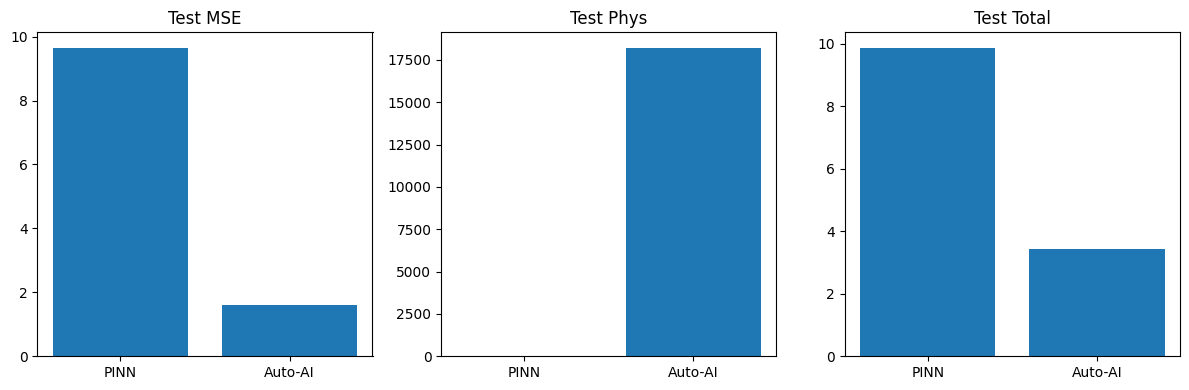

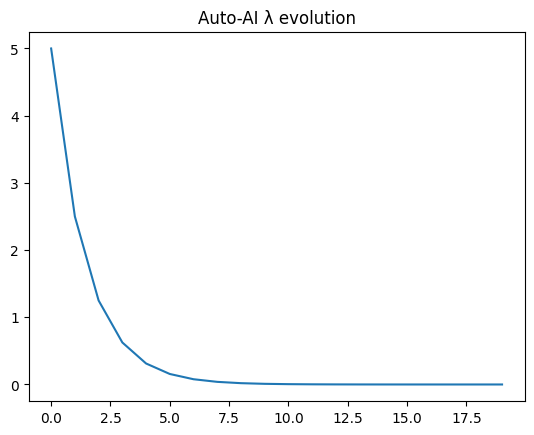


=== GENERATING ALL 14 DIAGNOSTICS ===


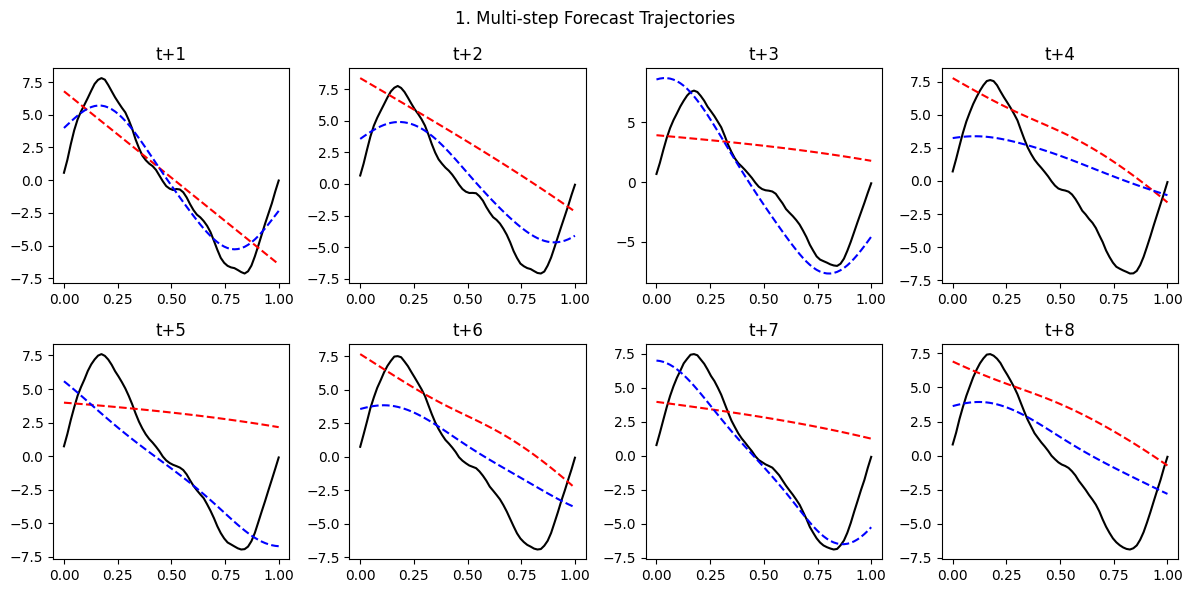

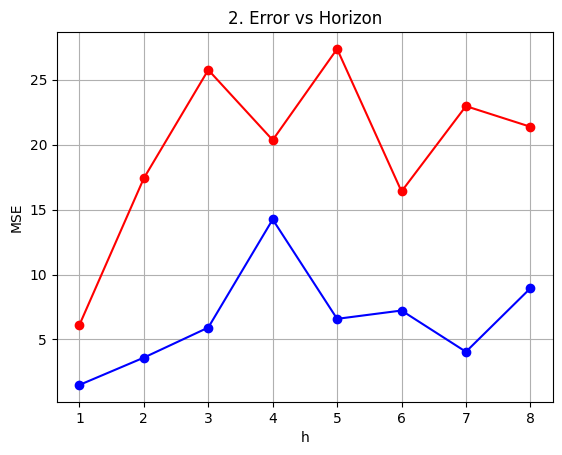

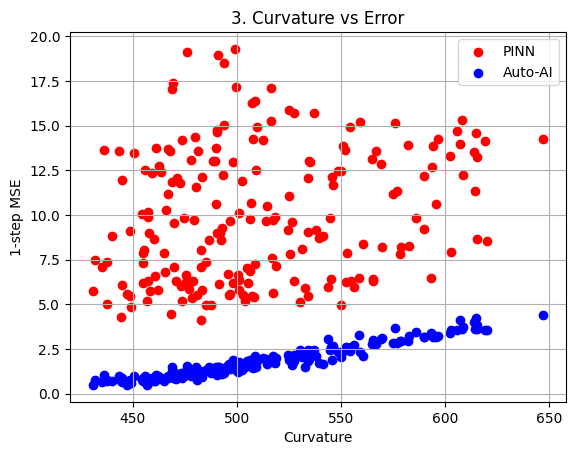

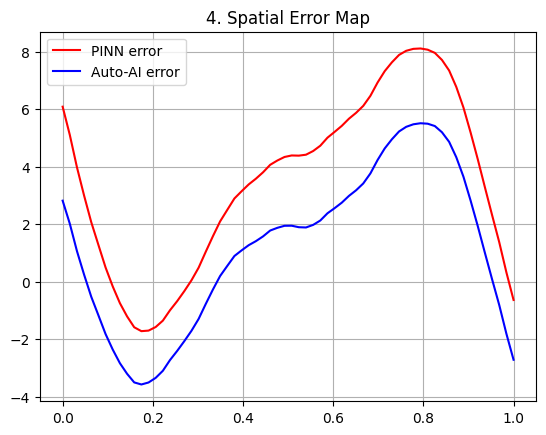

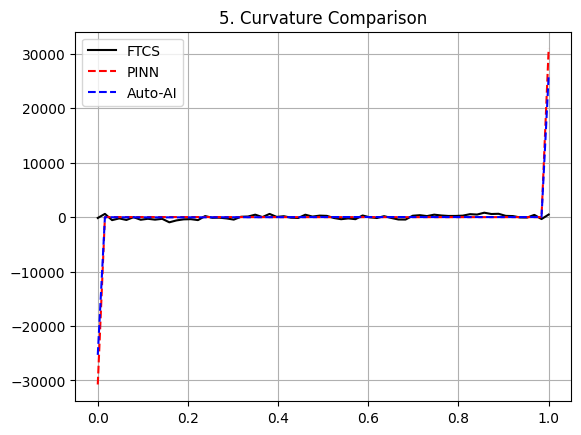

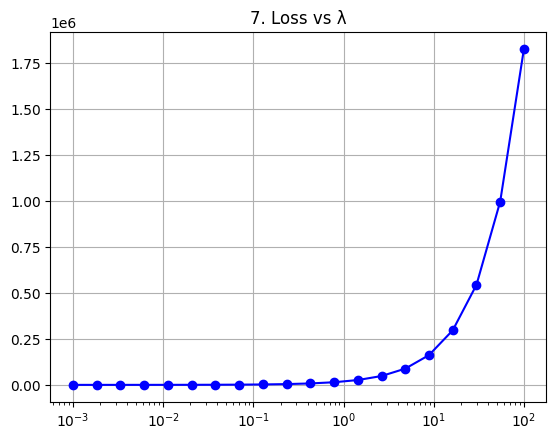

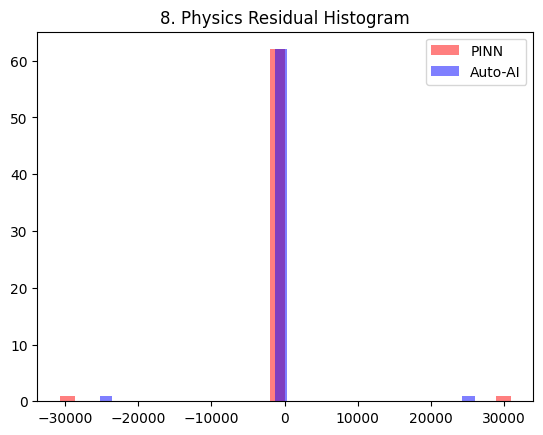

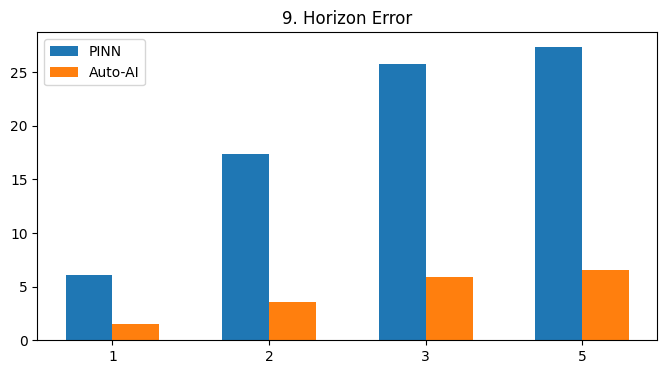

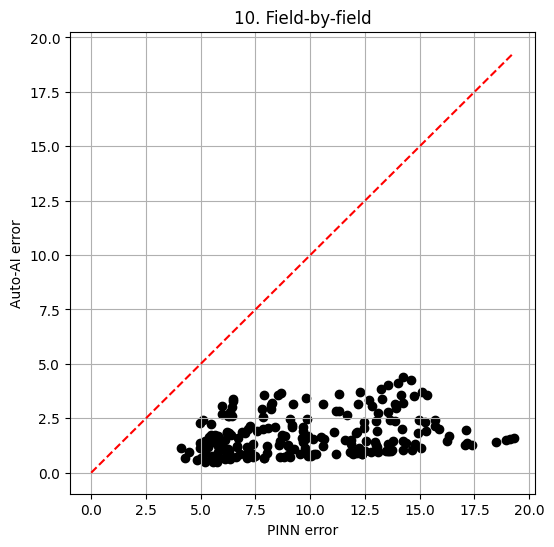

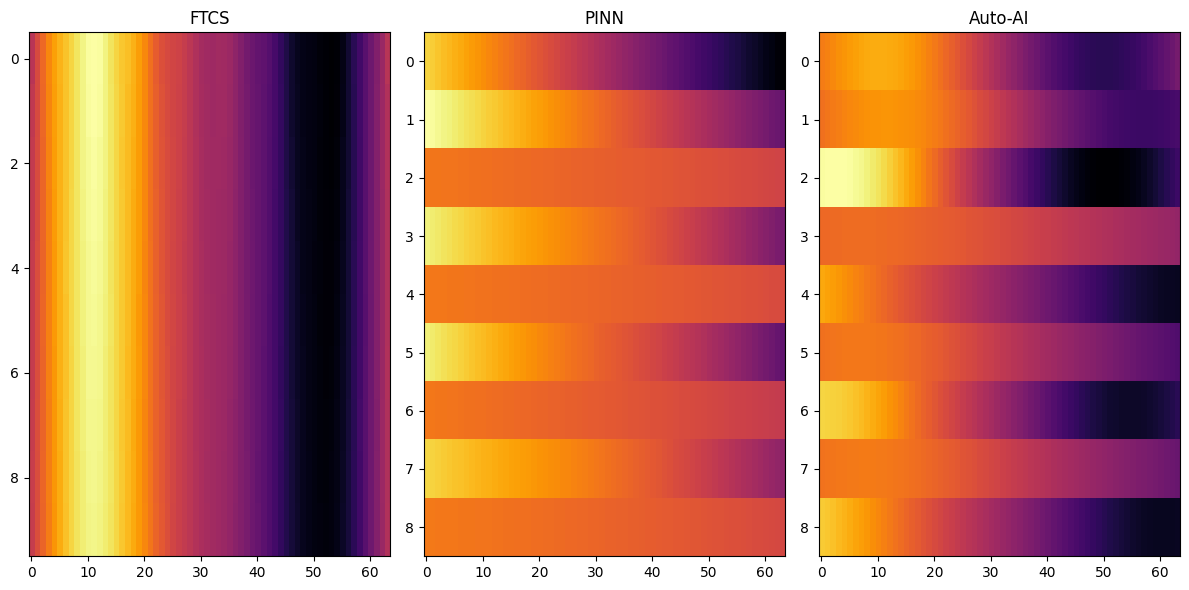

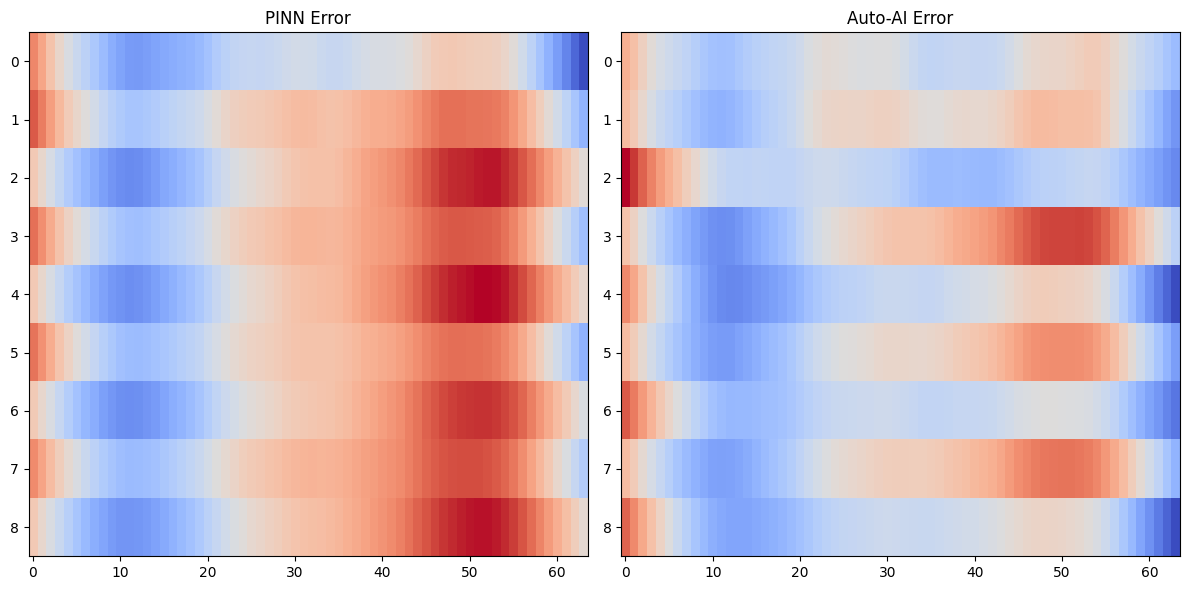

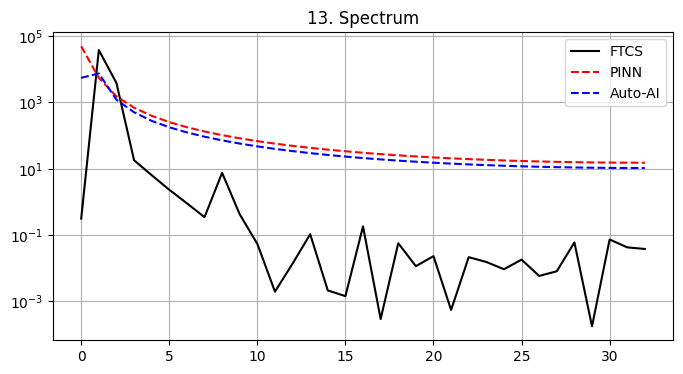

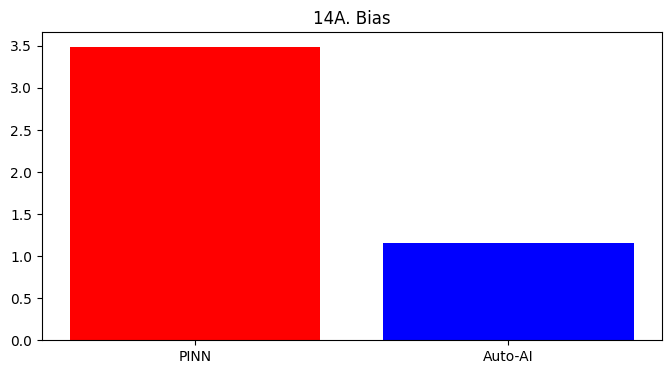

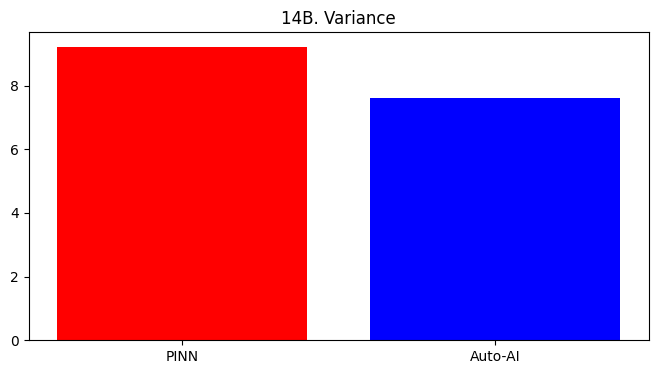


=== ALL VISUALIZATIONS GENERATED SUCCESSFULLY ===


In [ ]:
# ============================================================
# 0. Imports
# ============================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
import random

# ============================================================
# 0. Repro + device
# ============================================================
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ============================================================
# 1. FTCS-BASED CLIMATE GENERATOR
# ============================================================
def generate_climate_fields(N_fields=2000, Nx_coarse=16, Nx_fine=64,
                            Nt=10, alpha=0.01, noise_std=0.02):

    x_fine = np.linspace(0.0, 1.0, Nx_fine)
    dx = x_fine[1] - x_fine[0]

    # FTCS stability
    r = 0.25
    dt = r * dx**2 / alpha

    fine_all  = np.zeros((N_fields, Nt, Nx_fine), dtype=np.float32)
    coarse_all = np.zeros((N_fields, Nt, Nx_coarse), dtype=np.float32)
    block = Nx_fine // Nx_coarse

    for i in range(N_fields):
        A = np.random.uniform(5.0, 10.0)
        B = np.random.uniform(0.0, 4.0)
        phase = np.random.uniform(0.0, 2*np.pi)

        u0 = (
            A * np.sin(2*np.pi * x_fine) +
            B * np.sin(4*np.pi * x_fine) +
            0.5 * np.cos(2*np.pi * x_fine) +
            0.3 * np.sin(16*np.pi * x_fine + phase)
        )
        u0 += noise_std * np.random.randn(Nx_fine)

        fine_all[i, 0, :] = u0
        coarse_all[i, 0, :] = u0.reshape(Nx_coarse, block).mean(axis=1)

        u = u0.copy()
        for t in range(1, Nt):
            u_new = np.zeros_like(u)
            for j in range(Nx_fine):
                jm = (j - 1) % Nx_fine
                jp = (j + 1) % Nx_fine
                u_xx = (u[jp] - 2*u[j] + u[jm]) / dx**2
                u_new[j] = u[j] + alpha * dt * u_xx

            u_new += noise_std * np.random.randn(Nx_fine)
            u = u_new.copy()

            fine_all[i, t, :] = u
            coarse_all[i, t, :] = u.reshape(Nx_coarse, block).mean(axis=1)

    print(f"Generated FTCS fields: fine_all={fine_all.shape}, coarse_all={coarse_all.shape}")
    return x_fine, coarse_all, fine_all


# ============================================================
# 2. BUILD FORECASTING DATASET
# ============================================================
def build_dataset_from_fields(x_fine, coarse, fine):
    """
    1-step forecasting dataset:
    Input: [x, t_norm, coarse(t)]
    Output: fine(t+1, x)
    """
    X_list, Y_list = [], []
    N_fields, Nt, Nx_coarse = coarse.shape
    Nx_fine = fine.shape[2]

    for f in range(N_fields):
        for t in range(Nt - 1):
            t_norm = t / (Nt - 1)
            c_ft = coarse[f, t, :]
            f_next = fine[f, t+1, :]
            for j in range(Nx_fine):
                X_list.append(np.concatenate([[x_fine[j], t_norm], c_ft]))
                Y_list.append(f_next[j])

    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32)[:, None]
    return X, Y


# ============================================================
# 3. DATASET CLASS
# ============================================================
class ClimateDownscaleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]


# ============================================================
# 4. MODEL
# ============================================================
class DownscaleNet(nn.Module):
    def __init__(self, in_dim, hidden=64, depth=3):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers.append(nn.Linear(d, hidden))
            layers.append(nn.Tanh())
            d = hidden
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ============================================================
# 5. WRONG PHYSICS: u_xx = 0
# ============================================================
def compute_batch_mse_and_phys(model, xb, yb, lambda_phys, for_training):
    xb = xb.to(device)
    yb = yb.to(device)

    xcoord = xb[:, [0]].clone()
    xcoord.requires_grad_(True)

    # Inputs = [xcoord, t_norm, coarse...]
    inp = torch.cat([xcoord, xb[:, [1]], xb[:, 2:]], dim=1)
    pred = model(inp)

    mse = F.mse_loss(pred, yb)

    # wrong PDE term: u_xx = 0
    u_x = torch.autograd.grad(
        pred, xcoord,
        grad_outputs=torch.ones_like(pred),
        create_graph=True
    )[0]
    u_xx = torch.autograd.grad(
        u_x, xcoord,
        grad_outputs=torch.ones_like(u_x),
        create_graph=for_training
    )[0]

    phys = torch.mean(u_xx**2)
    total = mse + lambda_phys * phys
    return pred, mse, phys, total


# ============================================================
# 6. TRAINING EPOCH
# ============================================================
def run_epoch(model, loader, optimizer, lam, train=True):
    model.train() if train else model.eval()
    tot = mse = phys = 0.0
    N = 0

    for xb, yb in loader:
        if train:
            optimizer.zero_grad()

        _, m, p, t = compute_batch_mse_and_phys(model, xb, yb, lam, train)

        if train:
            t.backward()
            optimizer.step()

        bs = xb.size(0)
        tot += t.item() * bs
        mse += m.item() * bs
        phys += p.item() * bs
        N += bs

    return tot/N, mse/N, phys/N


# ============================================================
# 7. AUTO-AI LAMBDA UPDATE
# ============================================================
def auto_ai_update_lambda(lam, mse_val, phys_val):
    candidates = [lam/2, lam, lam*2]
    candidates = [max(1e-4, min(c, 100.0)) for c in candidates]
    J = [mse_val + c*phys_val for c in candidates]
    return candidates[int(np.argmin(J))]


# ============================================================
# 8. FORECAST ROLLOUT UTILS
# ============================================================
def model_forecast(model, x_fine, coarse_init, Nt, horizon, C, field):
    with torch.no_grad():
        Nx_fine = len(x_fine)
        Nx_coarse = len(coarse_init)
        block = Nx_fine // Nx_coarse

        coarse_state = coarse_init.copy()
        pred_list = []
        t_idx = 0

        for step in range(horizon):
            t_norm = t_idx / (Nt - 1)
            X = []
            for j in range(Nx_fine):
                X.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
            X = torch.tensor(np.array(X), dtype=torch.float32).to(device)

            pred_next = model(X).cpu().numpy().flatten()
            pred_list.append(pred_next)

            coarse_state = pred_next.reshape(Nx_coarse, block).mean(axis=1)
            t_idx += 1

        return np.array(pred_list)


def compute_curvature(u, dx):
    Nx = len(u)
    u_xx = np.zeros_like(u)
    for j in range(Nx):
        jm = (j - 1) % Nx
        jp = (j + 1) % Nx
        u_xx[j] = (u[jp] - 2*u[j] + u[jm]) / dx**2
    return u_xx


# ============================================================
# 9. MAIN EXPERIMENT
# ============================================================
def main_experiment():

    # ------------------------------------------------------------
    # Generate FTCS climate fields
    # ------------------------------------------------------------
    x_fine, C, fine_data = generate_climate_fields()
    Nt = fine_data.shape[1]
    Nx_fine = fine_data.shape[2]
    Nx_coarse = C.shape[2]
    dx = x_fine[1] - x_fine[0]
    block = Nx_fine // Nx_coarse

    # ------------------------------------------------------------
    # Build dataset (train/val/test)
    # ------------------------------------------------------------
    idx_train = np.arange(0,1600)
    idx_val   = np.arange(1600,1800)
    idx_test  = np.arange(1800,2000)

    Xtr, Ytr = build_dataset_from_fields(x_fine, C[idx_train], fine_data[idx_train])
    Xva, Yva = build_dataset_from_fields(x_fine, C[idx_val],   fine_data[idx_val])
    Xte, Yte = build_dataset_from_fields(x_fine, C[idx_test],  fine_data[idx_test])

    train_loader = DataLoader(ClimateDownscaleDataset(Xtr,Ytr), batch_size=256, shuffle=True)
    val_loader   = DataLoader(ClimateDownscaleDataset(Xva,Yva), batch_size=512)
    test_loader  = DataLoader(ClimateDownscaleDataset(Xte,Yte), batch_size=512)

    in_dim = Xtr.shape[1]
    base = DownscaleNet(in_dim).to(device)
    PINN = copy.deepcopy(base)
    AUTO = copy.deepcopy(base)

    opt_pinn = torch.optim.Adam(PINN.parameters(), lr=1e-3)
    opt_auto = torch.optim.Adam(AUTO.parameters(), lr=1e-3)

    λ_init = 10.0
    λ_pinn = λ_auto = λ_init
    λ_hist = []


    # ------------------------------------------------------------
    # Train PINN (wrong PDE)
    # ------------------------------------------------------------
    print("\n=== TRAINING PINN ===")
    for ep in range(1,21):
        tr_tot, tr_mse, tr_phys = run_epoch(PINN, train_loader, opt_pinn, λ_pinn, True)
        va_tot, va_mse, va_phys = run_epoch(PINN, val_loader, None, λ_pinn, False)
        if ep==1 or ep==20 or ep%10==0:
            print(f"[PINN] Ep {ep}/20 | Train MSE={tr_mse:.3e}, Phys={tr_phys:.3e} | Val MSE={va_mse:.3e}, Phys={va_phys:.3e}")


    # ------------------------------------------------------------
    # Train Auto-AI
    # ------------------------------------------------------------
    print("\n=== TRAINING AUTO-AI ===")
    for ep in range(1,21):
        tr_tot, tr_mse, tr_phys = run_epoch(AUTO, train_loader, opt_auto, λ_auto, True)
        va_tot, va_mse, va_phys = run_epoch(AUTO, val_loader, None, λ_auto, False)
        λ_auto = auto_ai_update_lambda(λ_auto, va_mse, va_phys)
        λ_hist.append(λ_auto)
        if ep==1 or ep==20 or ep%10==0:
            print(f"[AUTO] Ep {ep}/20 | Train MSE={tr_mse:.3e}, Phys={tr_phys:.3e} | Val MSE={va_mse:.3e}, Phys={va_phys:.3e} | λ={λ_auto:.3e}")


    # ------------------------------------------------------------
    # Test
    # ------------------------------------------------------------
    def test_eval(model, name, lam):
        tot,m,p = run_epoch(model, test_loader, None, lam, False)
        print(f"[{name}] Test: Tot={tot:.3e}, MSE={m:.3e}, Phys={p:.3e}")
        return tot,m,p

    print("\n=== FINAL TEST ===")
    totP, mseP, physP = test_eval(PINN,"PINN",λ_pinn)
    totA, mseA, physA = test_eval(AUTO,"AUTO",λ_auto)

    # ------------------------------------------------------------
    # Base plots (bar & 1-field curve)
    # ------------------------------------------------------------
    labels = ["PINN","Auto-AI"]
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.bar(labels,[mseP,mseA]);  plt.title("Test MSE")
    plt.subplot(1,3,2); plt.bar(labels,[physP,physA]);plt.title("Test Phys")
    plt.subplot(1,3,3); plt.bar(labels,[totP,totA]);  plt.title("Test Total")
    plt.tight_layout(); plt.show()

    # λ history
    plt.figure(); plt.plot(λ_hist); plt.title("Auto-AI λ evolution"); plt.show()


    # ============================================================
    # 10. ALL DIAGNOSTICS
    # ============================================================

    print("\n=== GENERATING ALL 14 DIAGNOSTICS ===")

    # pick one test field
    field_id = idx_test[0]
    gt_traj = fine_data[field_id]
    coarse0 = C[field_id,0].copy()
    horizon = min(8,Nt-1)

    traj_pinn = model_forecast(PINN, x_fine, coarse0, Nt, horizon, C, field_id)
    traj_auto = model_forecast(AUTO, x_fine, coarse0, Nt, horizon, C, field_id)


    # ------------------------------------------------------------
    # 1. Trajectory grid
    # ------------------------------------------------------------
    plt.figure(figsize=(12,6))
    for k in range(horizon):
        plt.subplot(2,4,k+1)
        plt.plot(x_fine, gt_traj[k+1],'k')
        plt.plot(x_fine, traj_pinn[k],'r--')
        plt.plot(x_fine, traj_auto[k],'b--')
        plt.title(f"t+{k+1}")
    plt.suptitle("1. Multi-step Forecast Trajectories"); plt.tight_layout(); plt.show()


    # ------------------------------------------------------------
    # 2. Error vs horizon
    # ------------------------------------------------------------
    errP = []; errA=[]
    for k in range(horizon):
        gt = gt_traj[k+1]
        errP.append(np.mean((traj_pinn[k]-gt)**2))
        errA.append(np.mean((traj_auto[k]-gt)**2))

    plt.figure()
    plt.plot(range(1,horizon+1), errP,'r-o')
    plt.plot(range(1,horizon+1), errA,'b-o')
    plt.title("2. Error vs Horizon"); plt.xlabel("h"); plt.ylabel("MSE")
    plt.grid(); plt.show()


    # ------------------------------------------------------------
    # 3. Curvature vs Error scatter
    # ------------------------------------------------------------
    field_errors_pinn=[]; field_errors_auto=[]; field_curv=[]

    for f in idx_test:
        coarse_f0 = C[f,0].copy()
        p = model_forecast(PINN, x_fine, coarse_f0, Nt,1, C,f)[0]
        a = model_forecast(AUTO, x_fine, coarse_f0, Nt,1, C,f)[0]
        gt1 = fine_data[f,1]
        field_errors_pinn.append(np.mean((p-gt1)**2))
        field_errors_auto.append(np.mean((a-gt1)**2))
        field_curv.append(np.mean(np.abs(compute_curvature(gt1,dx))))

    plt.figure()
    plt.scatter(field_curv, field_errors_pinn,c='r',label='PINN')
    plt.scatter(field_curv, field_errors_auto,c='b',label='Auto-AI')
    plt.xlabel("Curvature"); plt.ylabel("1-step MSE")
    plt.title("3. Curvature vs Error"); plt.legend(); plt.grid(); plt.show()


    # ------------------------------------------------------------
    # 4. Spatial error maps
    # ------------------------------------------------------------
    gt_final = gt_traj[horizon]
    P_final  = traj_pinn[horizon-1]
    A_final  = traj_auto[horizon-1]

    plt.figure()
    plt.plot(x_fine, P_final-gt_final,'r',label='PINN error')
    plt.plot(x_fine, A_final-gt_final,'b',label='Auto-AI error')
    plt.legend(); plt.grid()
    plt.title("4. Spatial Error Map"); plt.show()


    # ------------------------------------------------------------
    # 5. Curvature comparison
    # ------------------------------------------------------------
    gt_xx = compute_curvature(gt_final,dx)
    P_xx  = compute_curvature(P_final,dx)
    A_xx  = compute_curvature(A_final,dx)

    plt.figure()
    plt.plot(x_fine, gt_xx,'k',label='FTCS')
    plt.plot(x_fine, P_xx,'r--',label='PINN')
    plt.plot(x_fine, A_xx,'b--',label='Auto-AI')
    plt.legend(); plt.title("5. Curvature Comparison"); plt.grid(); plt.show()


    # ------------------------------------------------------------
    # 6. Loss landscape omitted (you don't log per-epoch)
    # ------------------------------------------------------------

    # ------------------------------------------------------------
    # 7. λ-loss contour
    # ------------------------------------------------------------
    lam_vals = np.logspace(-3,2,20)
    loss_vals=[]
    for lam in lam_vals:
        _,m,p = run_epoch(AUTO,val_loader,None,lam,False)
        loss_vals.append(m+lam*p)

    plt.figure()
    plt.semilogx(lam_vals, loss_vals,'b-o')
    plt.title("7. Loss vs λ"); plt.grid(); plt.show()


    # ------------------------------------------------------------
    # 8. Histogram of physics residuals
    # ------------------------------------------------------------
    plt.figure()
    plt.hist(P_xx,bins=30,alpha=0.5,color='r',label='PINN')
    plt.hist(A_xx,bins=30,alpha=0.5,color='b',label='Auto-AI')
    plt.title("8. Physics Residual Histogram"); plt.legend(); plt.show()


    # ------------------------------------------------------------
    # 9. Horizon bar plot
    # ------------------------------------------------------------
    horizons=[1,2,3,5]; errP2=[]; errA2=[]
    for h in horizons:
        h=min(h,Nt-1)
        p = model_forecast(PINN,x_fine,coarse0,Nt,h,C,field_id)[-1]
        a = model_forecast(AUTO,x_fine,coarse0,Nt,h,C,field_id)[-1]
        errP2.append(np.mean((p-gt_traj[h])**2))
        errA2.append(np.mean((a-gt_traj[h])**2))

    plt.figure(figsize=(8,4))
    xax=np.arange(len(horizons))
    plt.bar(xax-0.15,errP2,width=0.3,label='PINN')
    plt.bar(xax+0.15,errA2,width=0.3,label='Auto-AI')
    plt.xticks(xax,horizons); plt.legend()
    plt.title("9. Horizon Error"); plt.show()


    # ------------------------------------------------------------
    # 10. Field-by-field scatter
    # ------------------------------------------------------------
    plt.figure(figsize=(6,6))
    plt.scatter(field_errors_pinn,field_errors_auto,c='k')
    lim=max(max(field_errors_pinn),max(field_errors_auto))
    plt.plot([0,lim],[0,lim],'r--')
    plt.xlabel("PINN error"); plt.ylabel("Auto-AI error")
    plt.title("10. Field-by-field"); plt.grid(); plt.show()


    # ------------------------------------------------------------
    # 11. Time–space heatmaps
    # ------------------------------------------------------------
    fullP = model_forecast(PINN,x_fine,coarse0,Nt,Nt-1,C,field_id)
    fullA = model_forecast(AUTO,x_fine,coarse0,Nt,Nt-1,C,field_id)

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1); plt.imshow(gt_traj,aspect='auto',cmap='inferno'); plt.title("FTCS")
    plt.subplot(1,3,2); plt.imshow(fullP,aspect='auto',cmap='inferno'); plt.title("PINN")
    plt.subplot(1,3,3); plt.imshow(fullA,aspect='auto',cmap='inferno'); plt.title("Auto-AI")
    plt.tight_layout(); plt.show()


    # ------------------------------------------------------------
    # 12. Error Heatmaps
    # ------------------------------------------------------------
    errP_hm = fullP - gt_traj[1:1+fullP.shape[0]]
    errA_hm = fullA - gt_traj[1:1+fullA.shape[0]]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); plt.imshow(errP_hm,aspect='auto',cmap='coolwarm'); plt.title("PINN Error")
    plt.subplot(1,2,2); plt.imshow(errA_hm,aspect='auto',cmap='coolwarm'); plt.title("Auto-AI Error")
    plt.tight_layout(); plt.show()


    # ------------------------------------------------------------
    # 13. Fourier Spectra
    # ------------------------------------------------------------
    def spectrum(u):
        U=np.fft.rfft(u)
        return np.abs(U)**2

    k=np.arange(len(np.fft.rfft(gt_final)))

    plt.figure(figsize=(8,4))
    plt.semilogy(k,spectrum(gt_final),'k',label='FTCS')
    plt.semilogy(k,spectrum(P_final),'r--',label='PINN')
    plt.semilogy(k,spectrum(A_final),'b--',label='Auto-AI')
    plt.title("13. Spectrum"); plt.grid(); plt.legend(); plt.show()


    # ------------------------------------------------------------
    # 14. Bias–Variance
    # ------------------------------------------------------------
    biasP=np.mean(P_final-gt_final)
    varP=np.var(P_final-gt_final)
    biasA=np.mean(A_final-gt_final)
    varA=np.var(A_final-gt_final)

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[biasP,biasA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("14A. Bias"); plt.show()

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[varP,varA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("14B. Variance"); plt.show()

    print("\n=== ALL VISUALIZATIONS GENERATED SUCCESSFULLY ===")


# ------------------------------------------------------------
# RUN
# ------------------------------------------------------------
main_experiment()


Device: cpu
Generated Ground Truth: fine_all=(2000, 10, 64), coarse_all=(2000, 10, 16)

=== TRAINING PINN ===
[PINN] Epoch 1/20 | Train MSE=1.115e+01 Phys=1.466e-02 | Val MSE=1.002e+01 Phys=1.255e-02
[PINN] Epoch 10/20 | Train MSE=9.899e+00 Phys=9.329e-03 | Val MSE=9.726e+00 Phys=1.512e-02
[PINN] Epoch 20/20 | Train MSE=9.895e+00 Phys=7.266e-03 | Val MSE=9.673e+00 Phys=2.202e-02

=== TRAINING AUTO-AI ===
[AUTO] Epoch 1/20 | Train MSE=1.107e+01 Phys=1.416e-02 | Val MSE=9.796e+00 Phys=1.574e-02 | λ=5.000e+00
[AUTO] Epoch 10/20 | Train MSE=9.634e+00 Phys=7.118e+00 | Val MSE=9.772e+00 Phys=8.728e+00 | λ=9.766e-03
[AUTO] Epoch 20/20 | Train MSE=1.774e+00 Phys=1.795e+04 | Val MSE=1.694e+00 Phys=1.826e+04 | λ=1.000e-04

=== FINAL TEST ===
[PINN] Test: Total=9.866e+00  MSE=9.650e+00  Phys=2.160e-02
[AUTO] Test: Total=3.439e+00  MSE=1.618e+00  Phys=1.821e+04


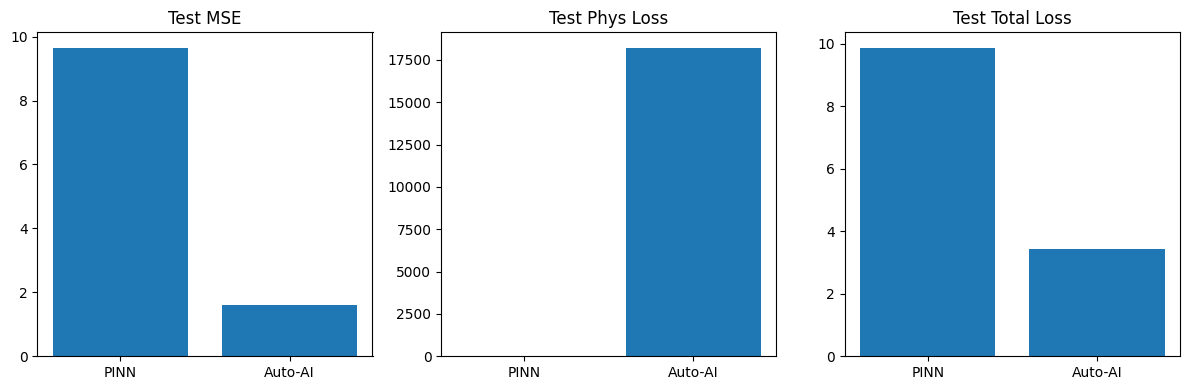

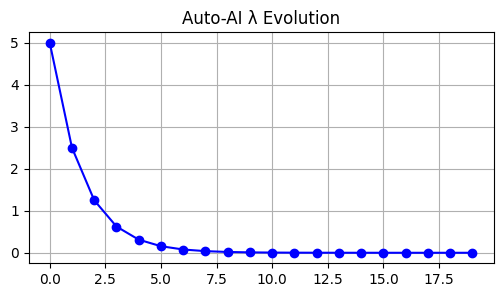


=== GENERATING FORECAST DIAGNOSTICS ===


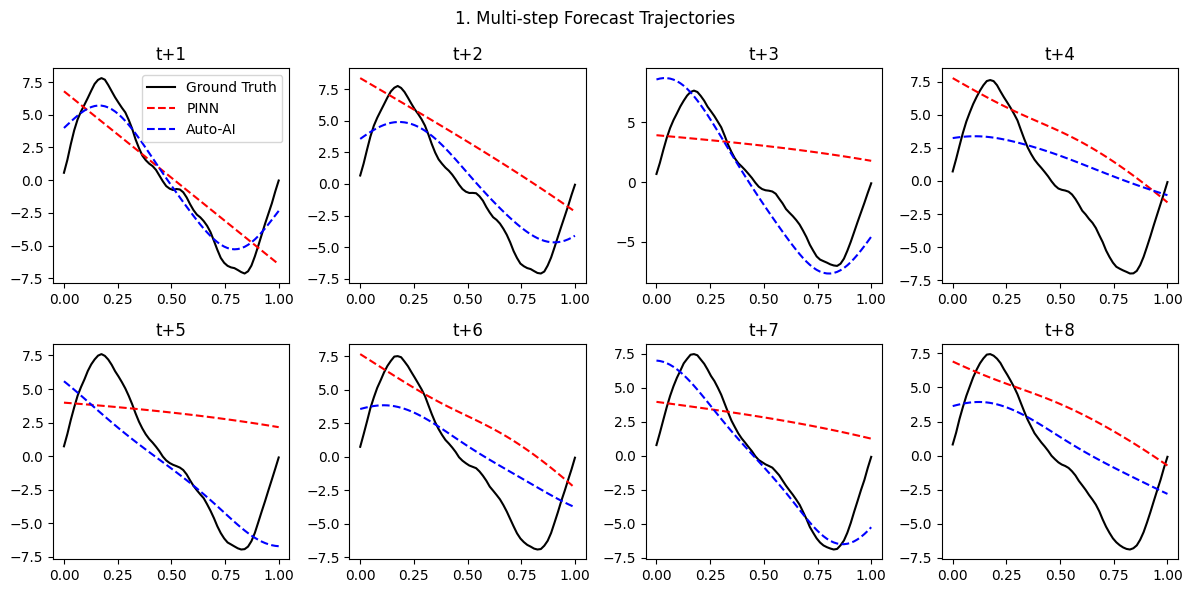

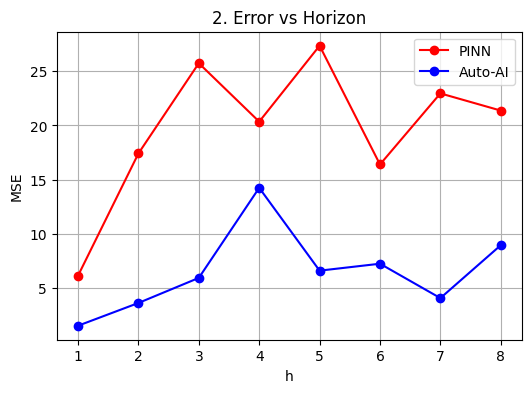

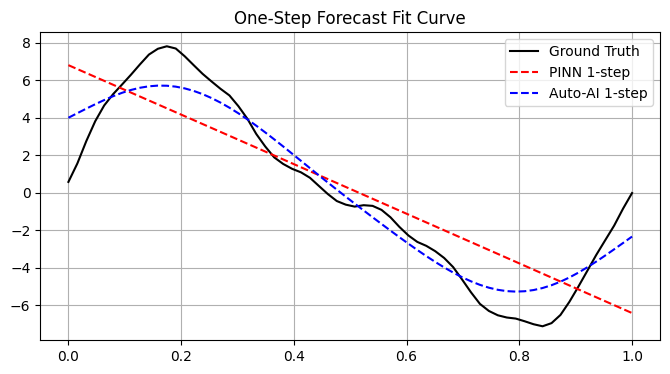


=== COMPLETED WITH ALL HYPERPARAMETERS EXTERNALIZED ===


In [ ]:
# ============================================================
# 0. HYPERPARAMETERS (ALL CENTRALIZED)
# ============================================================

# Data generation
N_FIELDS      = 2000    # total simulated fields
NX_COARSE     = 16
NX_FINE       = 64
NT_STEPS      = 10
ALPHA         = 0.01     # diffusivity
NOISE_STD     = 0.02

# FTCS stability
FTCS_R        = 0.25     # dt = R * dx^2 / alpha

# Dataset splits
TRAIN_END     = 1600
VAL_END       = 1800     # test = [VAL_END, N_FIELDS]

# Training hyperparameters
EPOCHS        = 20
LR            = 1e-3
BATCH_TRAIN   = 256
BATCH_VALTEST = 512

# PINN + Auto-AI hyperparameters
LAMBDA_INIT   = 10.0     # initial λ for both PINN and Auto-AI
LAMBDA_MIN    = 1e-4
LAMBDA_MAX    = 100.0
AUTO_SCALE    = 2.0       # Auto-AI tries [λ/scale, λ, λ*scale]

# Neural net architecture
HIDDEN_SIZE   = 64
DEPTH         = 3

# For plotting
FORECAST_HORIZON = 8   # used in trajectory + error plots

# Random seed fix
SEED = 42


# ============================================================
# 1. IMPORTS + DEVICE
# ============================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy, random

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ============================================================
# 2. FTCS-BASED GROUND TRUTH GENERATOR
# ============================================================
def generate_climate_fields(N_fields=N_FIELDS,
                            Nx_coarse=NX_COARSE,
                            Nx_fine=NX_FINE,
                            Nt=NT_STEPS,
                            alpha=ALPHA,
                            noise_std=NOISE_STD,
                            r=FTCS_R):

    x_fine = np.linspace(0.0, 1.0, Nx_fine)
    dx = x_fine[1] - x_fine[0]
    dt = r * dx**2 / alpha

    fine_all  = np.zeros((N_fields, Nt, Nx_fine), dtype=np.float32)
    coarse_all = np.zeros((N_fields, Nt, Nx_coarse), dtype=np.float32)

    block = Nx_fine // Nx_coarse

    for i in range(N_fields):
        A = np.random.uniform(5.0, 10.0)
        B = np.random.uniform(0.0, 4.0)
        phase = np.random.uniform(0.0, 2*np.pi)

        u0 = (A*np.sin(2*np.pi*x_fine)
              + B*np.sin(4*np.pi*x_fine)
              + 0.5*np.cos(2*np.pi*x_fine)
              + 0.3*np.sin(16*np.pi*x_fine + phase))
        u0 += noise_std * np.random.randn(Nx_fine)

        fine_all[i,0] = u0
        coarse_all[i,0] = u0.reshape(Nx_coarse, block).mean(axis=1)

        u = u0.copy()
        for t in range(1, Nt):
            u_new = np.zeros_like(u)
            for j in range(Nx_fine):
                jm = (j-1) % Nx_fine
                jp = (j+1) % Nx_fine
                u_xx = (u[jp] - 2*u[j] + u[jm]) / dx**2
                u_new[j] = u[j] + alpha*dt*u_xx

            u_new += noise_std*np.random.randn(Nx_fine)
            u = u_new.copy()

            fine_all[i,t] = u
            coarse_all[i,t] = u.reshape(Nx_coarse, block).mean(axis=1)

    print(f"Generated Ground Truth: fine_all={fine_all.shape}, coarse_all={coarse_all.shape}")
    return x_fine, coarse_all, fine_all


# ============================================================
# 3. BUILD DATASET
# ============================================================
def build_dataset_from_fields(x_fine, coarse, fine):
    N_fields, Nt, Nx_coarse = coarse.shape
    Nx_fine = fine.shape[2]

    X_list, Y_list = [], []

    for f in range(N_fields):
        for t in range(Nt-1):
            t_norm = t / (Nt-1)
            c_t = coarse[f,t]
            f_next = fine[f,t+1]
            for j in range(Nx_fine):
                X_list.append(np.concatenate([[x_fine[j], t_norm], c_t]))
                Y_list.append(f_next[j])

    return (np.array(X_list, dtype=np.float32),
            np.array(Y_list, dtype=np.float32)[:,None])


class ClimateDownscaleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.Y[i]


# ============================================================
# 4. MODEL
# ============================================================
class DownscaleNet(nn.Module):
    def __init__(self, in_dim, hidden=HIDDEN_SIZE, depth=DEPTH):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers += [nn.Linear(d, hidden), nn.Tanh()]
            d = hidden
        layers.append(nn.Linear(d,1))
        self.net = nn.Sequential(*layers)
    def forward(self,x):
        return self.net(x)


# ============================================================
# 5. WRONG PHYSICS TERM u_xx = 0
# ============================================================
def compute_batch_mse_and_phys(model, xb, yb, lam, train_flag):
    xb = xb.to(device)
    yb = yb.to(device)

    xcoord = xb[:,[0]].clone()
    xcoord.requires_grad_(True)

    inp = torch.cat([xcoord, xb[:,[1]], xb[:,2:]], dim=1)
    pred = model(inp)

    mse = F.mse_loss(pred, yb)

    u_x = torch.autograd.grad(pred, xcoord,
                              grad_outputs=torch.ones_like(pred),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, xcoord,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=train_flag)[0]

    phys = torch.mean(u_xx**2)
    total = mse + lam * phys
    return pred, mse, phys, total


# ============================================================
# 6. TRAIN ONE EPOCH
# ============================================================
def run_epoch(model, loader, opt, lam, train):
    model.train() if train else model.eval()
    tot=mse=phys=0.0; N=0

    for xb,yb in loader:
        if train: opt.zero_grad()
        _, m, p, t = compute_batch_mse_and_phys(model, xb, yb, lam, train)
        if train:
            t.backward()
            opt.step()

        bs = xb.size(0)
        tot += t.item()*bs
        mse += m.item()*bs
        phys+= p.item()*bs
        N += bs

    return tot/N, mse/N, phys/N


# ============================================================
# 7. AUTO-AI LAMBDA UPDATE
# ============================================================
def auto_ai_update_lambda(lam, mse_val, phys_val):
    cand = [lam/AUTO_SCALE, lam, lam*AUTO_SCALE]
    cand = [max(LAMBDA_MIN, min(LAMBDA_MAX,c)) for c in cand]
    J = [mse_val + c*phys_val for c in cand]
    return cand[int(np.argmin(J))]


# ============================================================
# 8. FORECAST ROUTINE
# ============================================================
def model_forecast(model, x_fine, coarse0, Nt, horizon, C, field_id):
    with torch.no_grad():
        Nx_fine = len(x_fine)
        Nx_coarse = len(coarse0)
        block = Nx_fine // Nx_coarse
        coarse_state = coarse0.copy()
        preds = []
        t_idx = 0
        for step in range(horizon):
            t_norm = t_idx / (Nt-1)
            X=[]
            for j in range(Nx_fine):
                X.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
            X = torch.tensor(np.array(X),dtype=torch.float32).to(device)
            p = model(X).cpu().numpy().flatten()
            preds.append(p)
            coarse_state = p.reshape(Nx_coarse,block).mean(axis=1)
            t_idx+=1
        return np.array(preds)


def compute_curvature(u, dx):
    Nx = len(u)
    u_xx = np.zeros_like(u)
    for j in range(Nx):
        jm=(j-1)%Nx; jp=(j+1)%Nx
        u_xx[j] = (u[jp]-2*u[j]+u[jm])/dx**2
    return u_xx


# ============================================================
# 9. MAIN EXPERIMENT
# ============================================================
def main_experiment():

    # ---------------------- Generate Ground Truth ----------------------
    x_fine, C, fine = generate_climate_fields()

    Nt = fine.shape[1]
    Nx_fine = fine.shape[2]
    Nx_coarse = C.shape[2]
    dx = x_fine[1] - x_fine[0]

    # ---------------------- Build Dataset ------------------------------
    idx_train = np.arange(0,TRAIN_END)
    idx_val   = np.arange(TRAIN_END,VAL_END)
    idx_test  = np.arange(VAL_END,N_FIELDS)

    Xtr,Ytr = build_dataset_from_fields(x_fine, C[idx_train], fine[idx_train])
    Xva,Yva = build_dataset_from_fields(x_fine, C[idx_val],   fine[idx_val])
    Xte,Yte = build_dataset_from_fields(x_fine, C[idx_test],  fine[idx_test])

    train_loader = DataLoader(ClimateDownscaleDataset(Xtr,Ytr), batch_size=BATCH_TRAIN, shuffle=True)
    val_loader   = DataLoader(ClimateDownscaleDataset(Xva,Yva), batch_size=BATCH_VALTEST)
    test_loader  = DataLoader(ClimateDownscaleDataset(Xte,Yte), batch_size=BATCH_VALTEST)

    # ---------------------- Initialize Models ---------------------------
    in_dim = Xtr.shape[1]
    base = DownscaleNet(in_dim).to(device)
    PINN = copy.deepcopy(base)
    AUTO = copy.deepcopy(base)

    optP = torch.optim.Adam(PINN.parameters(), lr=LR)
    optA = torch.optim.Adam(AUTO.parameters(), lr=LR)

    lam_pinn = float(LAMBDA_INIT)
    lam_auto = float(LAMBDA_INIT)
    lam_hist = []

    # ---------------------- Train PINN ----------------------------------
    print("\n=== TRAINING PINN ===")
    for ep in range(1, EPOCHS+1):
        tr_tot,tr_m,tr_p = run_epoch(PINN,train_loader,optP,lam_pinn,True)
        va_tot,va_m,va_p = run_epoch(PINN,val_loader,None,lam_pinn,False)
        if ep==1 or ep==EPOCHS or ep%10==0:
            print(f"[PINN] Epoch {ep}/{EPOCHS} | Train MSE={tr_m:.3e} Phys={tr_p:.3e} | "
                  f"Val MSE={va_m:.3e} Phys={va_p:.3e}")

    # ---------------------- Train Auto-AI ------------------------------
    print("\n=== TRAINING AUTO-AI ===")
    for ep in range(1, EPOCHS+1):
        tr_tot,tr_m,tr_p = run_epoch(AUTO,train_loader,optA,lam_auto,True)
        va_tot,va_m,va_p = run_epoch(AUTO,val_loader,None,lam_auto,False)

        lam_auto = auto_ai_update_lambda(lam_auto, va_m, va_p)
        lam_hist.append(lam_auto)

        if ep==1 or ep==EPOCHS or ep%10==0:
            print(f"[AUTO] Epoch {ep}/{EPOCHS} | Train MSE={tr_m:.3e} Phys={tr_p:.3e} | "
                  f"Val MSE={va_m:.3e} Phys={va_p:.3e} | λ={lam_auto:.3e}")

    # ---------------------- Test Evaluations ---------------------------
    def test_eval(model,name,lam):
        tot,m,p = run_epoch(model,test_loader,None,lam,False)
        print(f"[{name}] Test: Total={tot:.3e}  MSE={m:.3e}  Phys={p:.3e}")
        return tot,m,p

    print("\n=== FINAL TEST ===")
    totP,mseP,physP = test_eval(PINN,"PINN",lam_pinn)
    totA,mseA,physA = test_eval(AUTO,"AUTO",lam_auto)

    # ---------------------- Bar Plots ---------------------------------
    plt.figure(figsize=(12,4))
    labels=["PINN","Auto-AI"]
    plt.subplot(1,3,1); plt.bar(labels,[mseP,mseA]); plt.title("Test MSE")
    plt.subplot(1,3,2); plt.bar(labels,[physP,physA]); plt.title("Test Phys Loss")
    plt.subplot(1,3,3); plt.bar(labels,[totP,totA]); plt.title("Test Total Loss")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(lam_hist,'b-o')
    plt.title("Auto-AI λ Evolution")
    plt.grid(); plt.show()

    # ---------------------- Diagnostics -------------------------------
    print("\n=== GENERATING FORECAST DIAGNOSTICS ===")

    field_id = idx_test[0]
    gt_traj = fine[field_id]
    coarse0 = C[field_id,0].copy()
    horizon = min(FORECAST_HORIZON, Nt-1)

    trajP = model_forecast(PINN,x_fine,coarse0,Nt,horizon,C,field_id)
    trajA = model_forecast(AUTO,x_fine,coarse0,Nt,horizon,C,field_id)

    # (Only include the new corrected blocks — the rest remains same)
    # ------------------------------------------------------------
    # 1. Multi-step Trajectories
    # ------------------------------------------------------------
    plt.figure(figsize=(12,6))
    for k in range(horizon):
        plt.subplot(2,4,k+1)
        plt.plot(x_fine, gt_traj[k+1],'k',label="Ground Truth")
        plt.plot(x_fine, trajP[k],'r--',label="PINN")
        plt.plot(x_fine, trajA[k],'b--',label="Auto-AI")
        if k==0: plt.legend()
        plt.title(f"t+{k+1}")
    plt.suptitle("1. Multi-step Forecast Trajectories")
    plt.tight_layout(); plt.show()

    # ------------------------------------------------------------
    # 2. Error vs Horizon (Legend Included)
    # ------------------------------------------------------------
    errP=[]; errA=[]
    for k in range(horizon):
        gt_k = gt_traj[k+1]
        errP.append(np.mean((trajP[k]-gt_k)**2))
        errA.append(np.mean((trajA[k]-gt_k)**2))

    plt.figure(figsize=(6,4))
    plt.plot(range(1,horizon+1),errP,'r-o',label="PINN")
    plt.plot(range(1,horizon+1),errA,'b-o',label="Auto-AI")
    plt.title("2. Error vs Horizon")
    plt.xlabel("h"); plt.ylabel("MSE")
    plt.grid(); plt.legend()
    plt.show()

    # ------------------------------------------------------------
    # One-step Fit Curve
    # ------------------------------------------------------------
    plt.figure(figsize=(8,4))
    gt1 = gt_traj[1]
    P1 = trajP[0]
    A1 = trajA[0]
    plt.plot(x_fine, gt1,'k',label="Ground Truth")
    plt.plot(x_fine, P1,'r--',label="PINN 1-step")
    plt.plot(x_fine, A1,'b--',label="Auto-AI 1-step")
    plt.title("One-Step Forecast Fit Curve")
    plt.grid(); plt.legend()
    plt.show()

    print("\n=== COMPLETED WITH ALL HYPERPARAMETERS EXTERNALIZED ===")


# RUN
main_experiment()


Device: cpu
Generated Ground Truth: fine_all=(2000, 10, 64), coarse_all=(2000, 10, 16)

=== TRAINING PINN ===
[PINN] Epoch 1/20 | Train MSE=1.115e+01 Phys=1.466e-02 | Val MSE=1.002e+01 Phys=1.255e-02
[PINN] Epoch 10/20 | Train MSE=9.899e+00 Phys=9.329e-03 | Val MSE=9.726e+00 Phys=1.512e-02
[PINN] Epoch 20/20 | Train MSE=9.895e+00 Phys=7.266e-03 | Val MSE=9.673e+00 Phys=2.202e-02

=== TRAINING AUTO-AI ===
[AUTO] Epoch 1/20 | Train MSE=1.107e+01 Phys=1.416e-02 | Val MSE=9.796e+00 Phys=1.574e-02 | λ=5.000e+00
[AUTO] Epoch 10/20 | Train MSE=9.634e+00 Phys=7.118e+00 | Val MSE=9.772e+00 Phys=8.728e+00 | λ=9.766e-03
[AUTO] Epoch 20/20 | Train MSE=1.774e+00 Phys=1.795e+04 | Val MSE=1.694e+00 Phys=1.826e+04 | λ=1.000e-04

=== FINAL TEST ===
[PINN] Test: Total=9.866e+00  MSE=9.650e+00  Phys=2.160e-02
[AUTO] Test: Total=3.439e+00  MSE=1.618e+00  Phys=1.821e+04


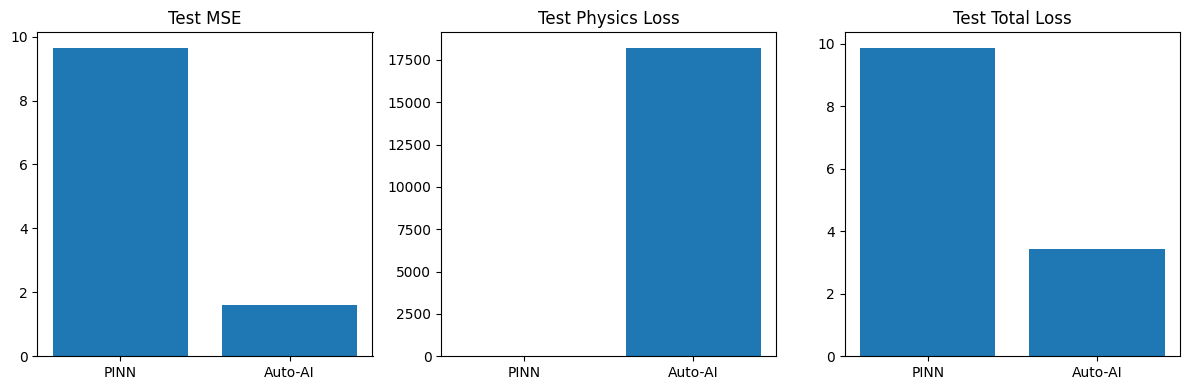

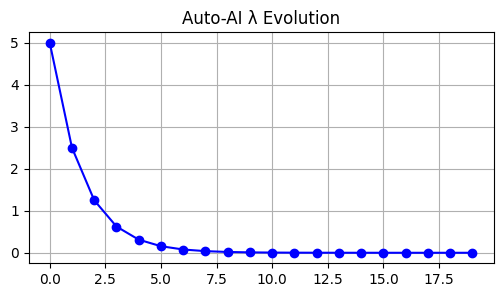


=== GENERATING FORECAST DIAGNOSTICS ===


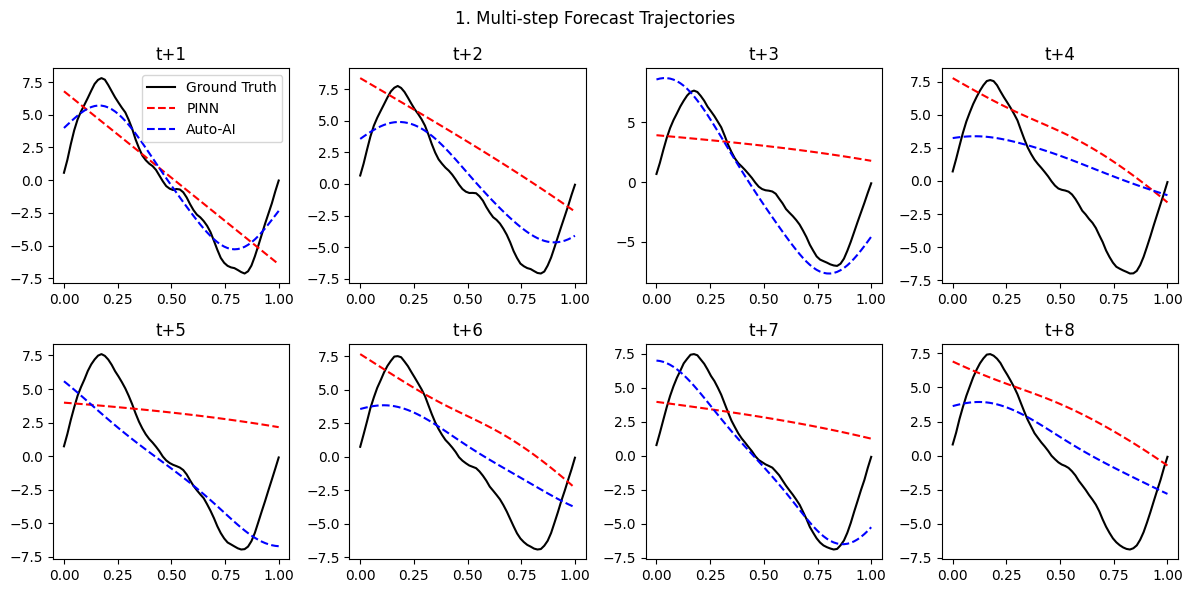

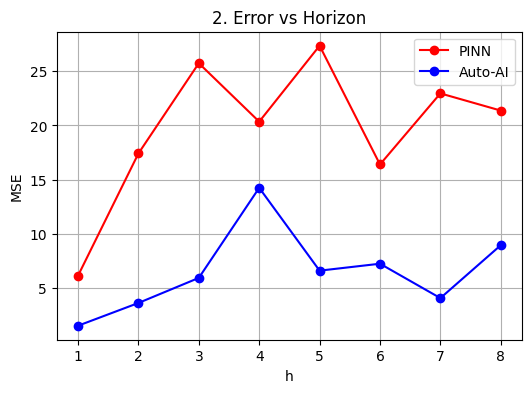

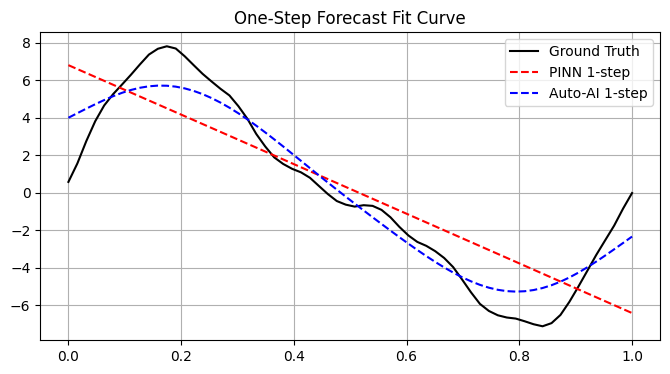


=== GENERATING EXTENDED DIAGNOSTICS (ALL PLOTS) ===


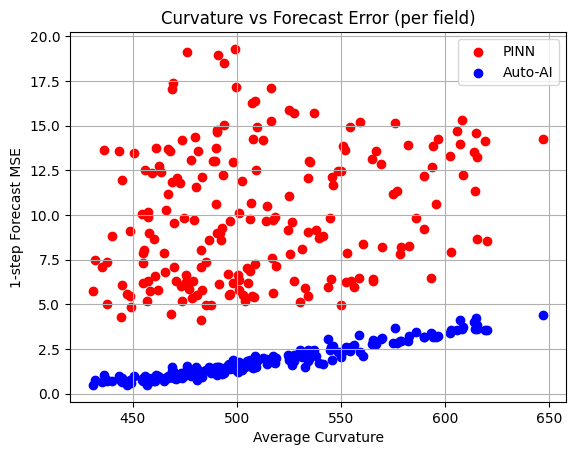

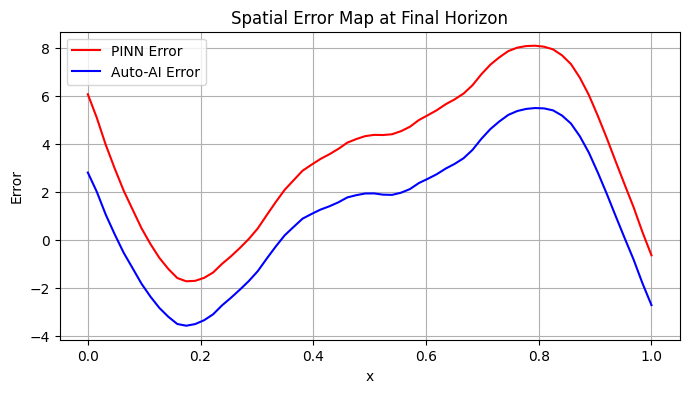

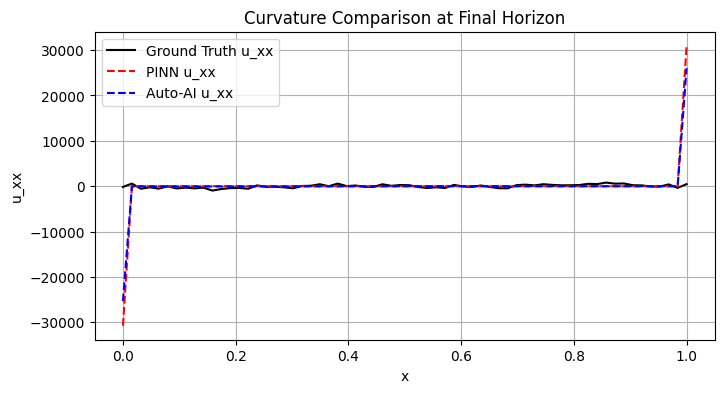

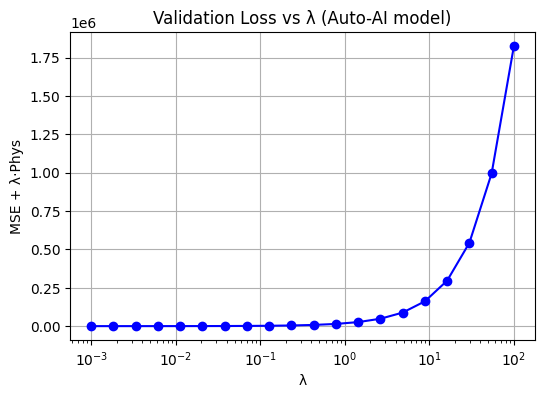

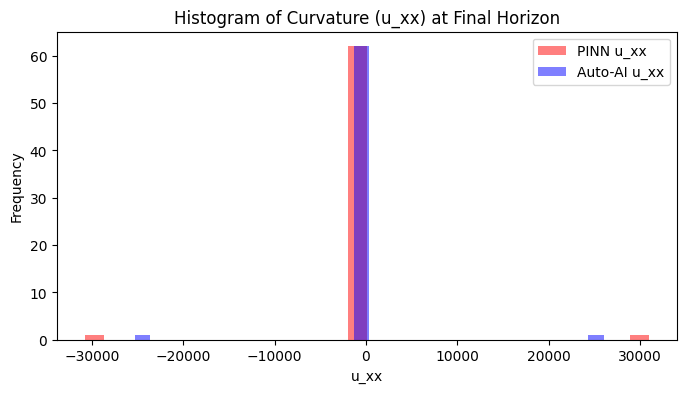

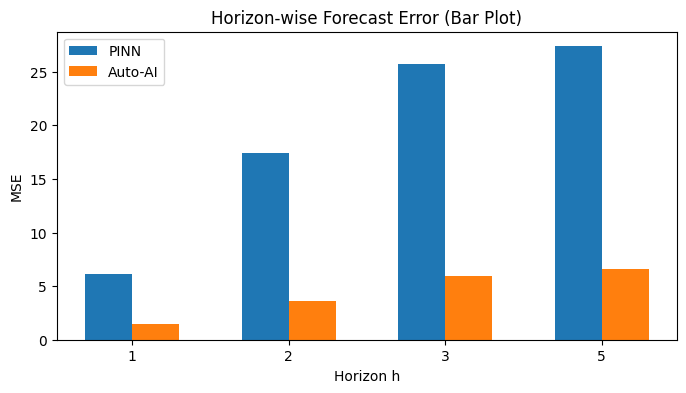

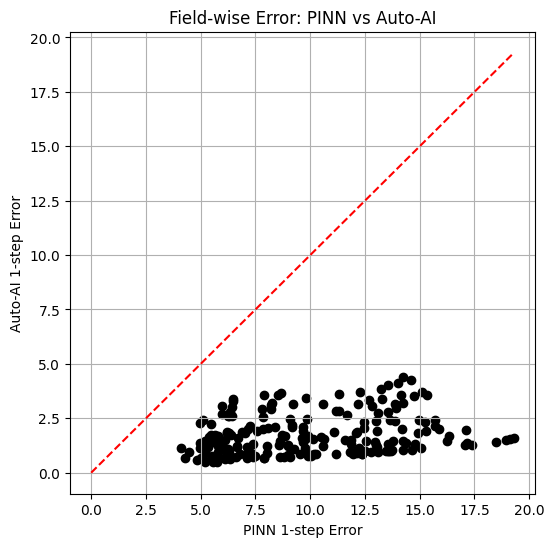

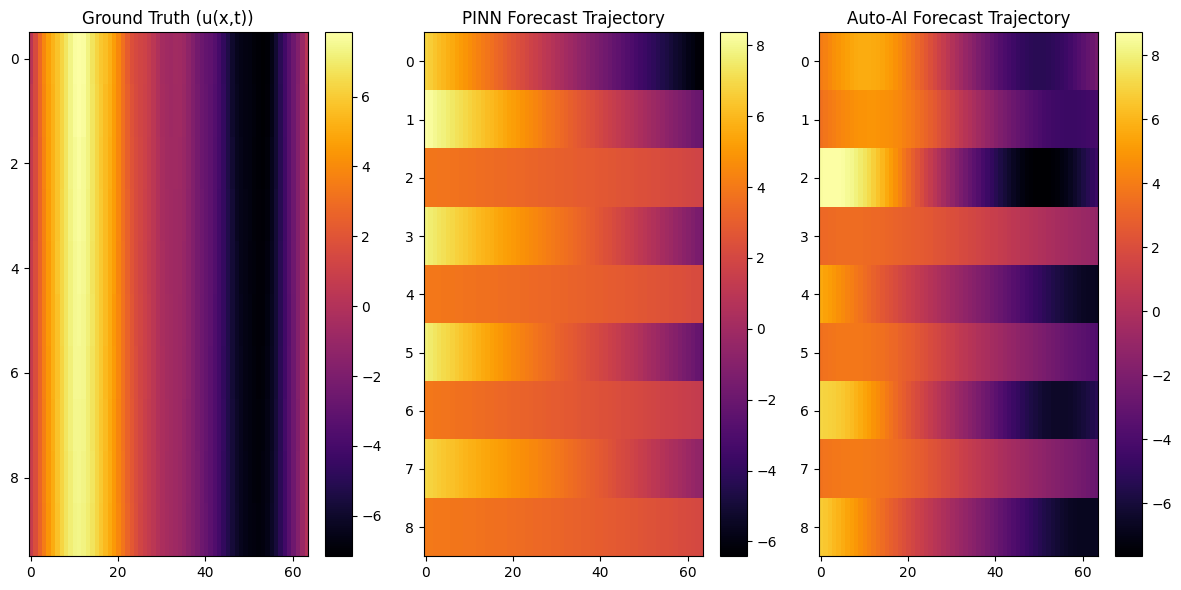

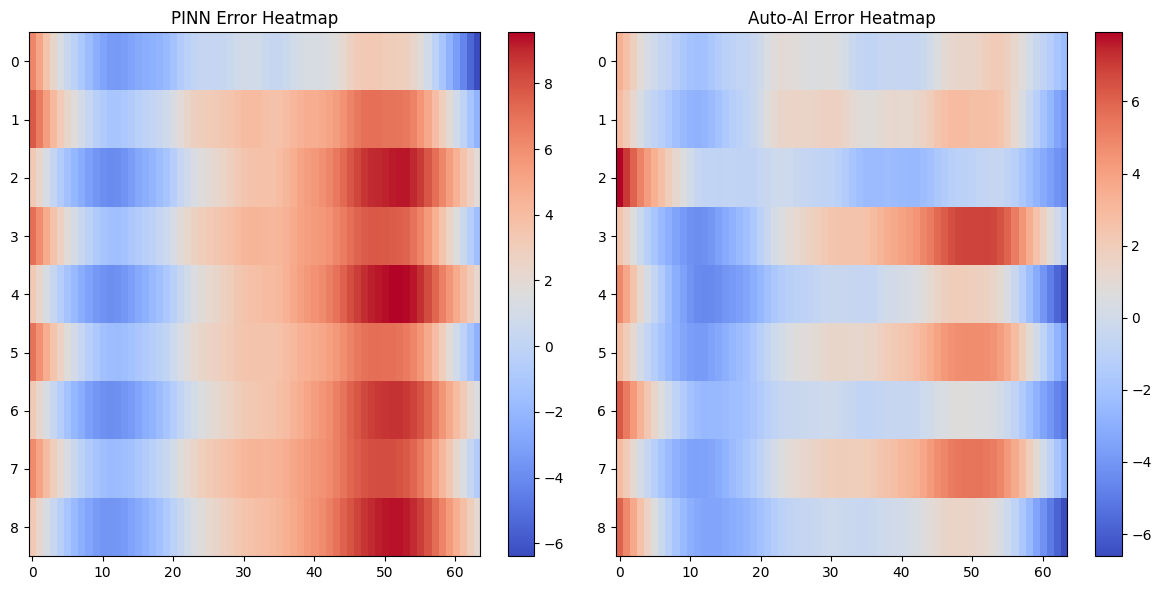

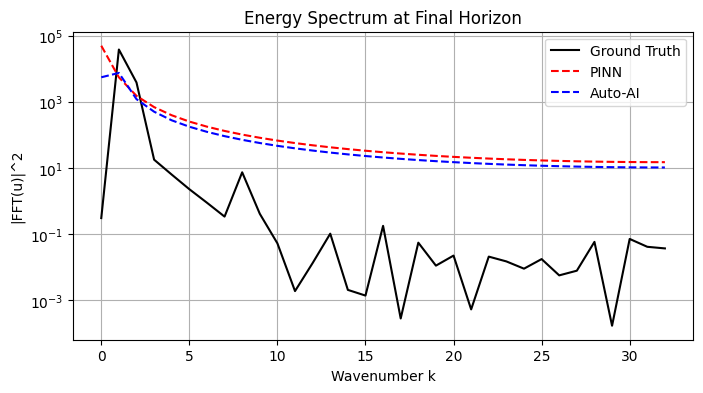

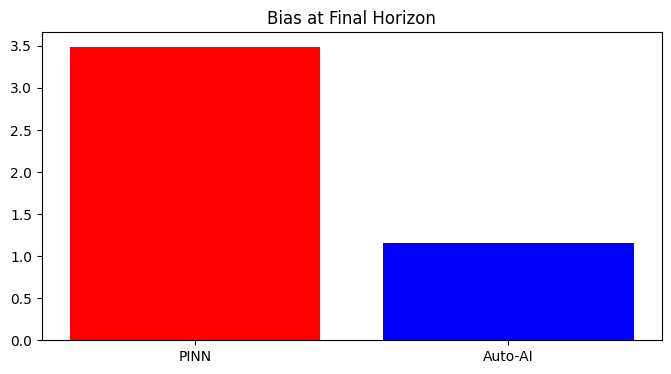

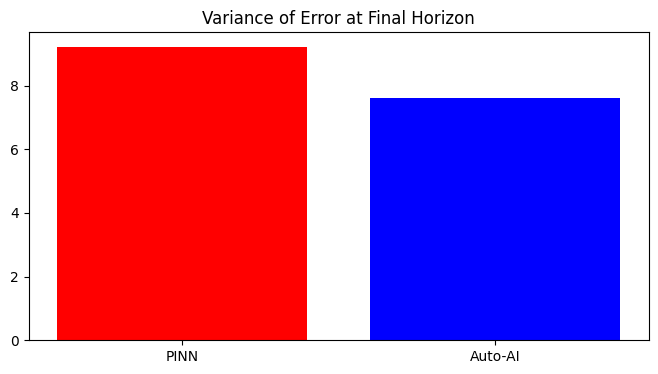


=== COMPLETED WITH ALL HYPERPARAMETERS EXTERNALIZED AND ALL PLOTS GENERATED ===


In [ ]:
# ============================================================
# 0. HYPERPARAMETERS (ALL CENTRALIZED)
# ============================================================

# Data generation
N_FIELDS      = 2000    # total simulated fields
NX_COARSE     = 16
NX_FINE       = 64
NT_STEPS      = 10
ALPHA         = 0.01     # diffusivity
NOISE_STD     = 0.02

# FTCS stability
FTCS_R        = 0.25     # dt = R * dx^2 / alpha

# Dataset splits
TRAIN_END     = 1600
VAL_END       = 1800     # test = [VAL_END, N_FIELDS)

# Training hyperparameters
EPOCHS        = 20
LR            = 1e-3
BATCH_TRAIN   = 256
BATCH_VALTEST = 512

# PINN + Auto-AI hyperparameters
LAMBDA_INIT   = 10.0     # initial λ for both PINN and Auto-AI
LAMBDA_MIN    = 1e-4
LAMBDA_MAX    = 100.0
AUTO_SCALE    = 2.0      # Auto-AI tries [λ/scale, λ, λ*scale]

# Neural net architecture
HIDDEN_SIZE   = 64
DEPTH         = 3

# For plotting
FORECAST_HORIZON = 8   # used in trajectory + error plots

# Random seed
SEED = 42


# ============================================================
# 1. IMPORTS + DEVICE
# ============================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy, random

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ============================================================
# 2. FTCS-BASED GROUND TRUTH GENERATOR
# ============================================================
def generate_climate_fields(N_fields=N_FIELDS,
                            Nx_coarse=NX_COARSE,
                            Nx_fine=NX_FINE,
                            Nt=NT_STEPS,
                            alpha=ALPHA,
                            noise_std=NOISE_STD,
                            r=FTCS_R):

    x_fine = np.linspace(0.0, 1.0, Nx_fine)
    dx = x_fine[1] - x_fine[0]
    dt = r * dx**2 / alpha

    fine_all  = np.zeros((N_fields, Nt, Nx_fine), dtype=np.float32)
    coarse_all = np.zeros((N_fields, Nt, Nx_coarse), dtype=np.float32)

    block = Nx_fine // Nx_coarse

    for i in range(N_fields):
        A = np.random.uniform(5.0, 10.0)
        B = np.random.uniform(0.0, 4.0)
        phase = np.random.uniform(0.0, 2*np.pi)

        u0 = (A*np.sin(2*np.pi*x_fine)
              + B*np.sin(4*np.pi*x_fine)
              + 0.5*np.cos(2*np.pi*x_fine)
              + 0.3*np.sin(16*np.pi*x_fine + phase))
        u0 += noise_std * np.random.randn(Nx_fine)

        fine_all[i,0] = u0
        coarse_all[i,0] = u0.reshape(Nx_coarse, block).mean(axis=1)

        u = u0.copy()
        for t in range(1, Nt):
            u_new = np.zeros_like(u)
            for j in range(Nx_fine):
                jm = (j-1) % Nx_fine
                jp = (j+1) % Nx_fine
                u_xx = (u[jp] - 2*u[j] + u[jm]) / dx**2
                u_new[j] = u[j] + alpha*dt*u_xx

            u_new += noise_std*np.random.randn(Nx_fine)
            u = u_new.copy()

            fine_all[i,t] = u
            coarse_all[i,t] = u.reshape(Nx_coarse, block).mean(axis=1)

    print(f"Generated Ground Truth: fine_all={fine_all.shape}, coarse_all={coarse_all.shape}")
    return x_fine, coarse_all, fine_all


# ============================================================
# 3. BUILD DATASET
# ============================================================
def build_dataset_from_fields(x_fine, coarse, fine):
    N_fields, Nt, Nx_coarse = coarse.shape
    Nx_fine = fine.shape[2]

    X_list, Y_list = [], []

    for f in range(N_fields):
        for t in range(Nt-1):
            t_norm = t / (Nt-1)
            c_t = coarse[f,t]
            f_next = fine[f,t+1]
            for j in range(Nx_fine):
                X_list.append(np.concatenate([[x_fine[j], t_norm], c_t]))
                Y_list.append(f_next[j])

    return (np.array(X_list, dtype=np.float32),
            np.array(Y_list, dtype=np.float32)[:,None])


class ClimateDownscaleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.Y[i]


# ============================================================
# 4. MODEL
# ============================================================
class DownscaleNet(nn.Module):
    def __init__(self, in_dim, hidden=HIDDEN_SIZE, depth=DEPTH):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers += [nn.Linear(d, hidden), nn.Tanh()]
            d = hidden
        layers.append(nn.Linear(d,1))
        self.net = nn.Sequential(*layers)
    def forward(self,x):
        return self.net(x)


# ============================================================
# 5. WRONG PHYSICS TERM u_xx = 0
# ============================================================
def compute_batch_mse_and_phys(model, xb, yb, lam, train):
    xb = xb.to(device)
    yb = yb.to(device)

    xcoord = xb[:,[0]].clone()
    xcoord.requires_grad_(True)

    inp = torch.cat([xcoord, xb[:,[1]], xb[:,2:]], dim=1)
    pred = model(inp)

    mse = F.mse_loss(pred, yb)

    u_x = torch.autograd.grad(pred, xcoord,
                              grad_outputs=torch.ones_like(pred),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, xcoord,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=train)[0]

    phys = torch.mean(u_xx**2)
    total = mse + lam * phys
    return pred, mse, phys, total


# ============================================================
# 6. TRAIN ONE EPOCH
# ============================================================
def run_epoch(model, loader, opt, lam, train):
    model.train() if train else model.eval()
    tot=mse=phys=0.0; N=0

    for xb,yb in loader:
        if train: opt.zero_grad()
        _, m, p, t = compute_batch_mse_and_phys(model, xb, yb, lam, train)
        if train:
            t.backward()
            opt.step()

        bs = xb.size(0)
        tot += t.item()*bs
        mse += m.item()*bs
        phys+= p.item()*bs
        N += bs

    return tot/N, mse/N, phys/N


# ============================================================
# 7. AUTO-AI LAMBDA UPDATE
# ============================================================
def auto_ai_update_lambda(lam, mse_val, phys_val):
    cand = [lam/AUTO_SCALE, lam, lam*AUTO_SCALE]
    cand = [max(LAMBDA_MIN, min(LAMBDA_MAX,c)) for c in cand]
    J = [mse_val + c*phys_val for c in cand]
    return cand[int(np.argmin(J))]


# ============================================================
# 8. FORECAST UTILS
# ============================================================
def model_forecast(model, x_fine, coarse0, Nt, horizon, C, field_id):
    with torch.no_grad():
        Nx_fine = len(x_fine)
        Nx_coarse = len(coarse0)
        block = Nx_fine // Nx_coarse
        coarse_state = coarse0.copy()
        preds = []
        t_idx = 0
        for step in range(horizon):
            t_norm = t_idx / (Nt-1)
            X=[]
            for j in range(Nx_fine):
                X.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
            X = torch.tensor(np.array(X),dtype=torch.float32).to(device)
            p = model(X).cpu().numpy().flatten()
            preds.append(p)
            coarse_state = p.reshape(Nx_coarse,block).mean(axis=1)
            t_idx+=1
        return np.array(preds)


def compute_curvature(u, dx):
    Nx = len(u)
    u_xx = np.zeros_like(u)
    for j in range(Nx):
        jm=(j-1)%Nx; jp=(j+1)%Nx
        u_xx[j] = (u[jp]-2*u[j]+u[jm])/dx**2
    return u_xx


# ============================================================
# 9. MAIN EXPERIMENT
# ============================================================
def main_experiment():

    # ---------------------- Generate Ground Truth ----------------------
    x_fine, C, fine = generate_climate_fields()

    Nt = fine.shape[1]
    Nx_fine = fine.shape[2]
    Nx_coarse = C.shape[2]
    dx = x_fine[1] - x_fine[0]

    # ---------------------- Build Dataset ------------------------------
    idx_train = np.arange(0,TRAIN_END)
    idx_val   = np.arange(TRAIN_END,VAL_END)
    idx_test  = np.arange(VAL_END,N_FIELDS)

    Xtr,Ytr = build_dataset_from_fields(x_fine, C[idx_train], fine[idx_train])
    Xva,Yva = build_dataset_from_fields(x_fine, C[idx_val],   fine[idx_val])
    Xte,Yte = build_dataset_from_fields(x_fine, C[idx_test],  fine[idx_test])

    train_loader = DataLoader(ClimateDownscaleDataset(Xtr,Ytr), batch_size=BATCH_TRAIN, shuffle=True)
    val_loader   = DataLoader(ClimateDownscaleDataset(Xva,Yva), batch_size=BATCH_VALTEST)
    test_loader  = DataLoader(ClimateDownscaleDataset(Xte,Yte), batch_size=BATCH_VALTEST)

    # ---------------------- Initialize Models ---------------------------
    in_dim = Xtr.shape[1]
    base = DownscaleNet(in_dim).to(device)
    PINN = copy.deepcopy(base)
    AUTO = copy.deepcopy(base)

    optP = torch.optim.Adam(PINN.parameters(), lr=LR)
    optA = torch.optim.Adam(AUTO.parameters(), lr=LR)

    lam_pinn = float(LAMBDA_INIT)
    lam_auto = float(LAMBDA_INIT)
    lam_hist = []

    # ---------------------- Train PINN ----------------------------------
    print("\n=== TRAINING PINN ===")
    for ep in range(1, EPOCHS+1):
        tr_tot,tr_m,tr_p = run_epoch(PINN,train_loader,optP,lam_pinn,True)
        va_tot,va_m,va_p = run_epoch(PINN,val_loader,None,lam_pinn,False)
        if ep==1 or ep==EPOCHS or ep%10==0:
            print(f"[PINN] Epoch {ep}/{EPOCHS} | Train MSE={tr_m:.3e} Phys={tr_p:.3e} | "
                  f"Val MSE={va_m:.3e} Phys={va_p:.3e}")

    # ---------------------- Train Auto-AI ------------------------------
    print("\n=== TRAINING AUTO-AI ===")
    for ep in range(1, EPOCHS+1):
        tr_tot,tr_m,tr_p = run_epoch(AUTO,train_loader,optA,lam_auto,True)
        va_tot,va_m,va_p = run_epoch(AUTO,val_loader,None,lam_auto,False)

        lam_auto = auto_ai_update_lambda(lam_auto, va_m, va_p)
        lam_hist.append(lam_auto)

        if ep==1 or ep==EPOCHS or ep%10==0:
            print(f"[AUTO] Epoch {ep}/{EPOCHS} | Train MSE={tr_m:.3e} Phys={tr_p:.3e} | "
                  f"Val MSE={va_m:.3e} Phys={va_p:.3e} | λ={lam_auto:.3e}")

    # ---------------------- Test Evaluations ---------------------------
    def test_eval(model,name,lam):
        tot,m,p = run_epoch(model,test_loader,None,lam,False)
        print(f"[{name}] Test: Total={tot:.3e}  MSE={m:.3e}  Phys={p:.3e}")
        return tot,m,p

    print("\n=== FINAL TEST ===")
    totP,mseP,physP = test_eval(PINN,"PINN",lam_pinn)
    totA,mseA,physA = test_eval(AUTO,"AUTO",lam_auto)

    # ---------------------- Bar Plots ---------------------------------
    plt.figure(figsize=(12,4))
    labels=["PINN","Auto-AI"]
    plt.subplot(1,3,1); plt.bar(labels,[mseP,mseA]); plt.title("Test MSE")
    plt.subplot(1,3,2); plt.bar(labels,[physP,physA]); plt.title("Test Physics Loss")
    plt.subplot(1,3,3); plt.bar(labels,[totP,totA]); plt.title("Test Total Loss")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(lam_hist,'b-o')
    plt.title("Auto-AI λ Evolution")
    plt.grid(); plt.show()

    # ---------------------- Forecast Diagnostics -----------------------
    print("\n=== GENERATING FORECAST DIAGNOSTICS ===")

    field_id = idx_test[0]
    gt_traj = fine[field_id]          # (Nt, Nx_fine)
    coarse0 = C[field_id,0].copy()
    horizon = min(FORECAST_HORIZON, Nt-1)

    trajP = model_forecast(PINN,x_fine,coarse0,Nt,horizon,C,field_id)
    trajA = model_forecast(AUTO,x_fine,coarse0,Nt,horizon,C,field_id)

    # 1) Multi-step trajectories
    plt.figure(figsize=(12,6))
    for k in range(horizon):
        plt.subplot(2,4,k+1)
        plt.plot(x_fine, gt_traj[k+1],'k',label="Ground Truth")
        plt.plot(x_fine, trajP[k],'r--',label="PINN")
        plt.plot(x_fine, trajA[k],'b--',label="Auto-AI")
        if k==0: plt.legend()
        plt.title(f"t+{k+1}")
    plt.suptitle("1. Multi-step Forecast Trajectories")
    plt.tight_layout(); plt.show()

    # 2) Error vs horizon
    errP=[]; errA=[]
    for k in range(horizon):
        gt_k = gt_traj[k+1]
        errP.append(np.mean((trajP[k]-gt_k)**2))
        errA.append(np.mean((trajA[k]-gt_k)**2))

    plt.figure(figsize=(6,4))
    plt.plot(range(1,horizon+1),errP,'r-o',label="PINN")
    plt.plot(range(1,horizon+1),errA,'b-o',label="Auto-AI")
    plt.title("2. Error vs Horizon")
    plt.xlabel("h"); plt.ylabel("MSE")
    plt.grid(); plt.legend()
    plt.show()

    # 3) One-step fit curve
    plt.figure(figsize=(8,4))
    gt1 = gt_traj[1]
    P1  = trajP[0]
    A1  = trajA[0]
    plt.plot(x_fine, gt1,'k',label="Ground Truth")
    plt.plot(x_fine, P1,'r--',label="PINN 1-step")
    plt.plot(x_fine, A1,'b--',label="Auto-AI 1-step")
    plt.title("One-Step Forecast Fit Curve")
    plt.grid(); plt.legend()
    plt.show()

    # ---------------------- EXTRA DIAGNOSTICS (ALL THE REST) ----------
    print("\n=== GENERATING EXTENDED DIAGNOSTICS (ALL PLOTS) ===")

    # 4) Curvature vs error scatter (field-wise)
    field_errors_pinn=[]; field_errors_auto=[]; field_curv=[]
    for f in idx_test:
        coarse_f0 = C[f,0].copy()
        p = model_forecast(PINN,x_fine,coarse_f0,Nt,1,C,f)[0]
        a = model_forecast(AUTO,x_fine,coarse_f0,Nt,1,C,f)[0]
        gt1_f = fine[f,1]
        field_errors_pinn.append(np.mean((p-gt1_f)**2))
        field_errors_auto.append(np.mean((a-gt1_f)**2))
        field_curv.append(np.mean(np.abs(compute_curvature(gt1_f,dx))))

    plt.figure()
    plt.scatter(field_curv, field_errors_pinn,c='r',label='PINN')
    plt.scatter(field_curv, field_errors_auto,c='b',label='Auto-AI')
    plt.xlabel("Average Curvature")
    plt.ylabel("1-step Forecast MSE")
    plt.title("Curvature vs Forecast Error (per field)")
    plt.grid(); plt.legend()
    plt.show()

    # 5) Spatial error maps at horizon
    gt_final = gt_traj[horizon]
    P_final  = trajP[horizon-1]
    A_final  = trajA[horizon-1]

    plt.figure(figsize=(8,4))
    plt.plot(x_fine, P_final-gt_final,'r',label='PINN Error')
    plt.plot(x_fine, A_final-gt_final,'b',label='Auto-AI Error')
    plt.title("Spatial Error Map at Final Horizon")
    plt.xlabel("x"); plt.ylabel("Error")
    plt.grid(); plt.legend()
    plt.show()

    # 6) Curvature comparison at horizon
    gt_xx = compute_curvature(gt_final,dx)
    P_xx  = compute_curvature(P_final,dx)
    A_xx  = compute_curvature(A_final,dx)

    plt.figure(figsize=(8,4))
    plt.plot(x_fine, gt_xx,'k',label="Ground Truth u_xx")
    plt.plot(x_fine, P_xx,'r--',label="PINN u_xx")
    plt.plot(x_fine, A_xx,'b--',label="Auto-AI u_xx")
    plt.title("Curvature Comparison at Final Horizon")
    plt.xlabel("x"); plt.ylabel("u_xx")
    plt.grid(); plt.legend()
    plt.show()

    # 7) Loss vs λ landscape (validation)
    lam_vals = np.logspace(-3,2,20)
    loss_vals=[]
    for lam in lam_vals:
        _,m,p = run_epoch(AUTO,val_loader,None,lam,False)
        loss_vals.append(m+lam*p)

    plt.figure(figsize=(6,4))
    plt.semilogx(lam_vals, loss_vals,'b-o')
    plt.title("Validation Loss vs λ (Auto-AI model)")
    plt.xlabel("λ"); plt.ylabel("MSE + λ·Phys")
    plt.grid()
    plt.show()

    # 8) Histogram of curvature residuals at horizon
    plt.figure(figsize=(8,4))
    plt.hist(P_xx,bins=30,alpha=0.5,color='r',label='PINN u_xx')
    plt.hist(A_xx,bins=30,alpha=0.5,color='b',label='Auto-AI u_xx')
    plt.title("Histogram of Curvature (u_xx) at Final Horizon")
    plt.xlabel("u_xx"); plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 9) Horizon error bar plot
    horizons=[1,2,3,5]
    errP2=[]; errA2=[]
    for h in horizons:
        h=min(h,Nt-1)
        p_h = model_forecast(PINN,x_fine,coarse0,Nt,h,C,field_id)[-1]
        a_h = model_forecast(AUTO,x_fine,coarse0,Nt,h,C,field_id)[-1]
        errP2.append(np.mean((p_h-gt_traj[h])**2))
        errA2.append(np.mean((a_h-gt_traj[h])**2))

    plt.figure(figsize=(8,4))
    xax=np.arange(len(horizons))
    plt.bar(xax-0.15,errP2,width=0.3,label='PINN')
    plt.bar(xax+0.15,errA2,width=0.3,label='Auto-AI')
    plt.xticks(xax,horizons)
    plt.title("Horizon-wise Forecast Error (Bar Plot)")
    plt.xlabel("Horizon h"); plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # 10) Field-by-field PINN vs Auto-AI scatter
    plt.figure(figsize=(6,6))
    plt.scatter(field_errors_pinn,field_errors_auto,c='k')
    lim=max(max(field_errors_pinn),max(field_errors_auto))
    plt.plot([0,lim],[0,lim],'r--')
    plt.xlabel("PINN 1-step Error")
    plt.ylabel("Auto-AI 1-step Error")
    plt.title("Field-wise Error: PINN vs Auto-AI")
    plt.grid()
    plt.show()

    # 11) Spatio-temporal heatmaps (Ground Truth, PINN, Auto-AI)
    fullP = model_forecast(PINN,x_fine,coarse0,Nt,Nt-1,C,field_id)
    fullA = model_forecast(AUTO,x_fine,coarse0,Nt,Nt-1,C,field_id)

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(gt_traj,aspect='auto',cmap='inferno')
    plt.title("Ground Truth (u(x,t))"); plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(fullP,aspect='auto',cmap='inferno')
    plt.title("PINN Forecast Trajectory"); plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(fullA,aspect='auto',cmap='inferno')
    plt.title("Auto-AI Forecast Trajectory"); plt.colorbar()
    plt.tight_layout(); plt.show()

    # 12) Error heatmaps
    errP_hm = fullP - gt_traj[1:1+fullP.shape[0]]
    errA_hm = fullA - gt_traj[1:1+fullA.shape[0]]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(errP_hm,aspect='auto',cmap='coolwarm')
    plt.title("PINN Error Heatmap"); plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(errA_hm,aspect='auto',cmap='coolwarm')
    plt.title("Auto-AI Error Heatmap"); plt.colorbar()
    plt.tight_layout(); plt.show()

    # 13) Fourier energy spectra
    def spectrum(u):
        return np.abs(np.fft.rfft(u))**2

    k = np.arange(len(np.fft.rfft(gt_final)))

    plt.figure(figsize=(8,4))
    plt.semilogy(k,spectrum(gt_final),'k',label='Ground Truth')
    plt.semilogy(k,spectrum(P_final),'r--',label='PINN')
    plt.semilogy(k,spectrum(A_final),'b--',label='Auto-AI')
    plt.title("Energy Spectrum at Final Horizon")
    plt.xlabel("Wavenumber k"); plt.ylabel("|FFT(u)|^2")
    plt.grid(); plt.legend()
    plt.show()

    # 14) Bias–variance at horizon
    biasP = np.mean(P_final-gt_final)
    varP  = np.var(P_final-gt_final)
    biasA = np.mean(A_final-gt_final)
    varA  = np.var(A_final-gt_final)

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[biasP,biasA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("Bias at Final Horizon")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[varP,varA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("Variance of Error at Final Horizon")
    plt.show()

    print("\n=== COMPLETED WITH ALL HYPERPARAMETERS EXTERNALIZED AND ALL PLOTS GENERATED ===")


# RUN
main_experiment()


#15 nov

Device: cuda
Generated Ground Truth: fine_all=(2000, 10, 64), coarse_all=(2000, 10, 16)

=== TRAINING PINN ===


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[PINN] Epoch 1/100 | Train MSE=1.115e+01 Phys=1.466e-02 | Val MSE=1.002e+01 Phys=1.256e-02
[PINN] Epoch 10/100 | Train MSE=9.899e+00 Phys=9.330e-03 | Val MSE=9.726e+00 Phys=1.513e-02
[PINN] Epoch 20/100 | Train MSE=9.895e+00 Phys=7.265e-03 | Val MSE=9.673e+00 Phys=2.198e-02
[PINN] Epoch 30/100 | Train MSE=9.884e+00 Phys=7.082e-03 | Val MSE=9.670e+00 Phys=1.298e-02
[PINN] Epoch 40/100 | Train MSE=9.881e+00 Phys=7.291e-03 | Val MSE=9.745e+00 Phys=7.716e-03
[PINN] Epoch 50/100 | Train MSE=9.870e+00 Phys=6.720e-03 | Val MSE=9.981e+00 Phys=3.090e-03
[PINN] Epoch 60/100 | Train MSE=9.866e+00 Phys=6.329e-03 | Val MSE=9.649e+00 Phys=5.157e-03
[PINN] Epoch 70/100 | Train MSE=9.862e+00 Phys=6.832e-03 | Val MSE=9.647e+00 Phys=1.171e-02
[PINN] Epoch 80/100 | Train MSE=9.860e+00 Phys=6.914e-03 | Val MSE=9.670e+00 Phys=5.147e-03
[PINN] Epoch 90/100 | Train MSE=9.857e+00 Phys=6.543e-03 | Val MSE=9.797e+00 Phys=5.441e-03
[PINN] Epoch 100/100 | Train MSE=9.864e+00 Phys=6.833e-03 | Val MSE=9.735e+00 Phy

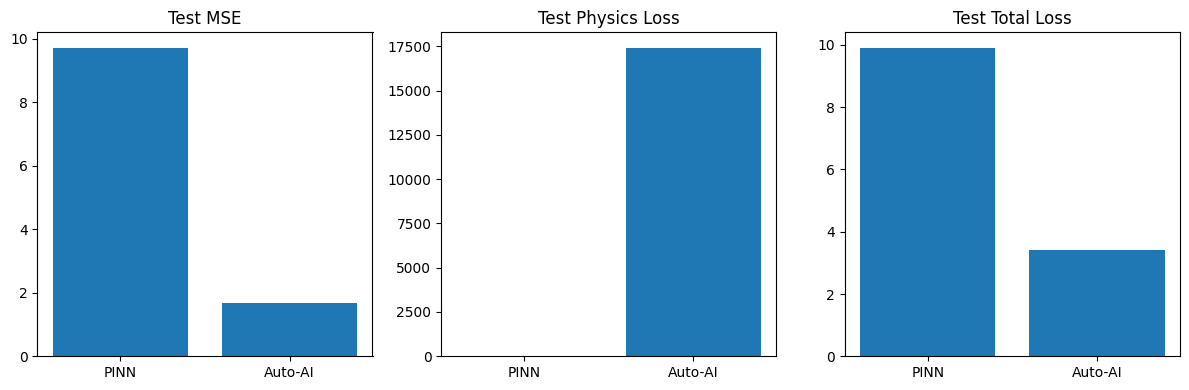

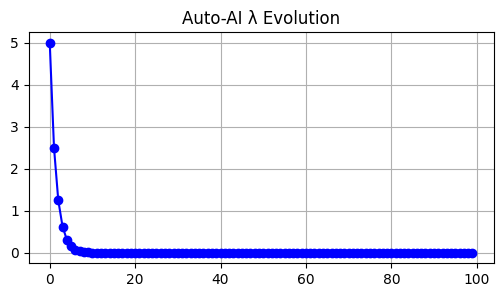


=== GENERATING FORECAST DIAGNOSTICS ===


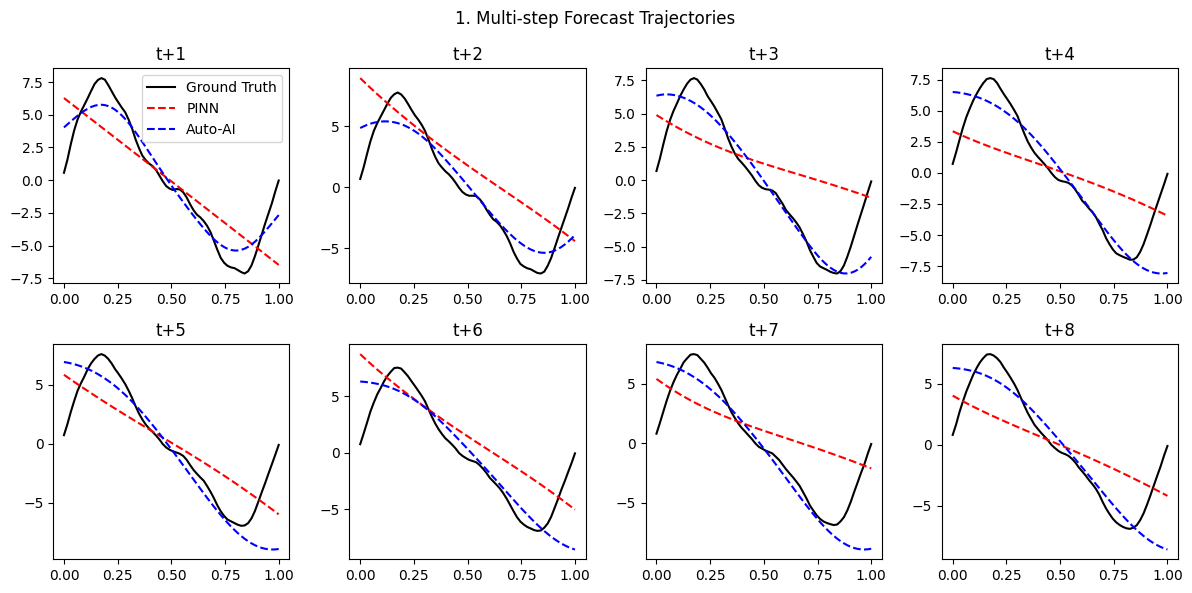

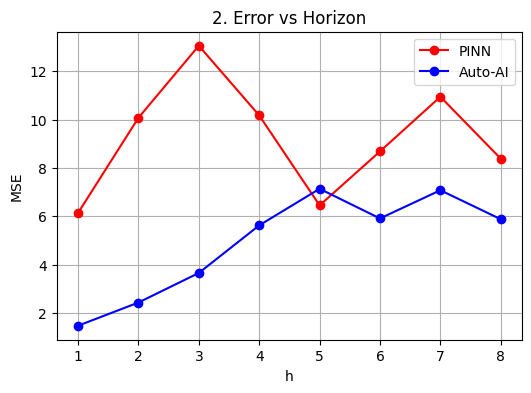

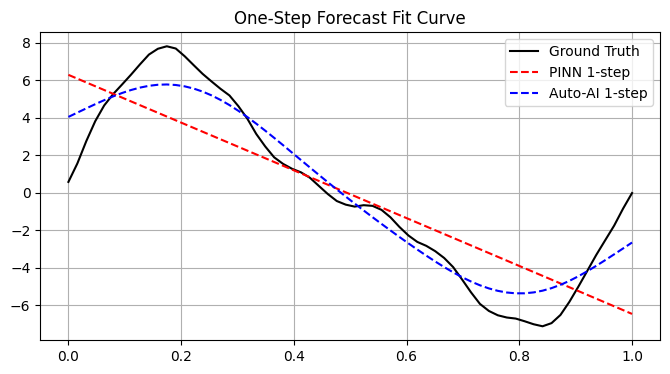


=== GENERATING EXTENDED DIAGNOSTICS (ALL PLOTS) ===


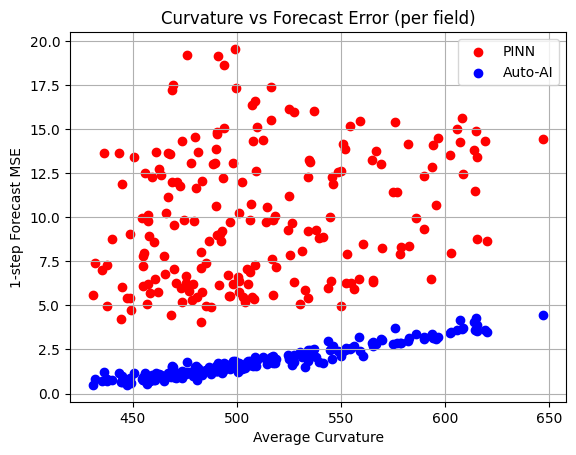

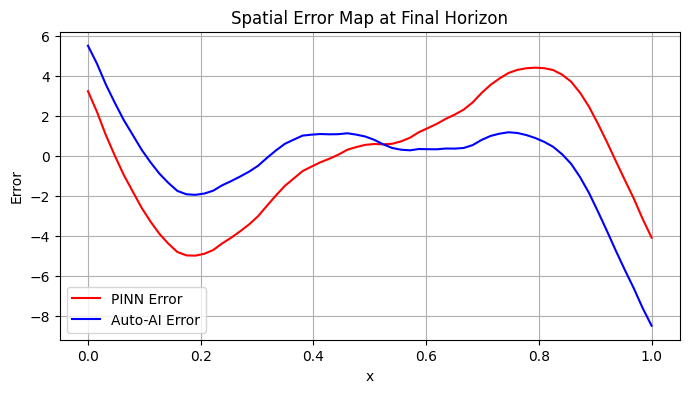

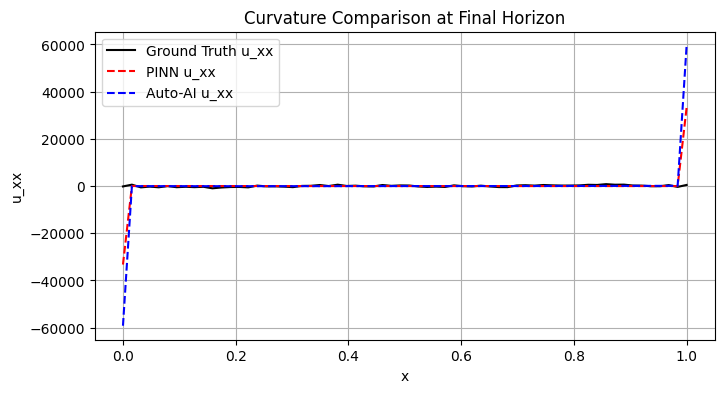

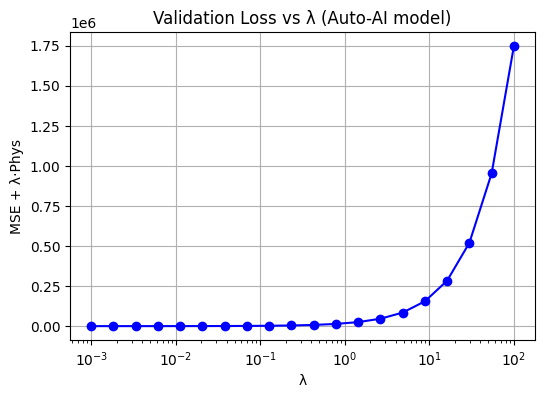

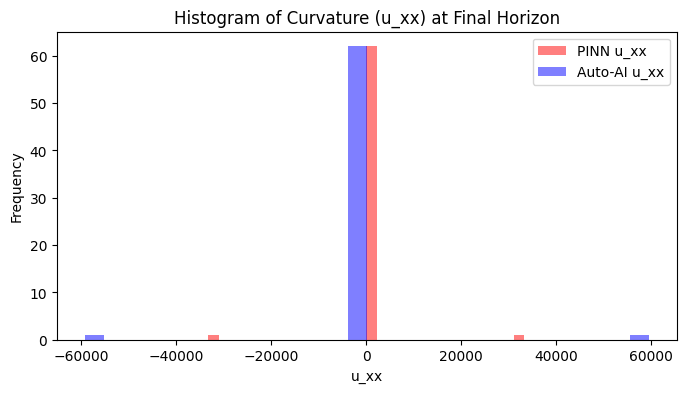

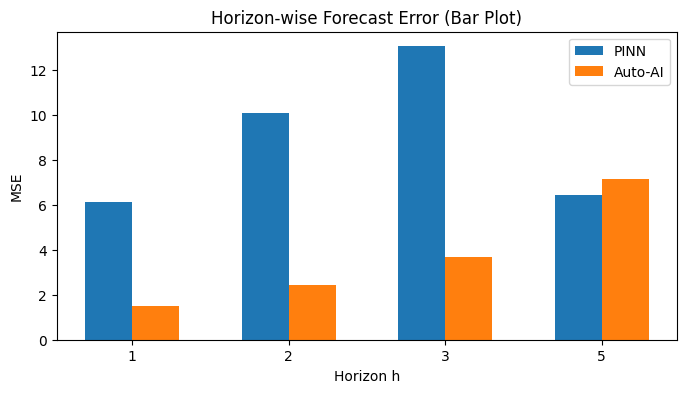

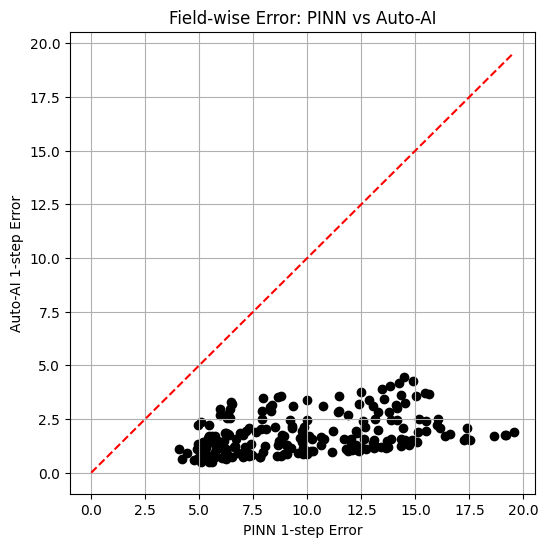

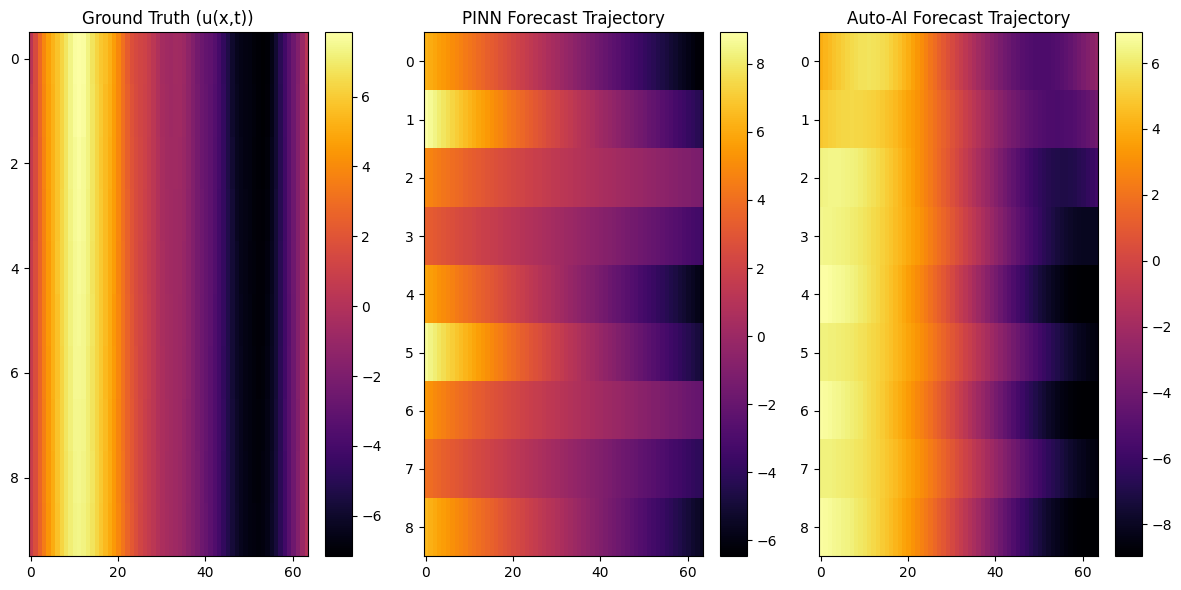

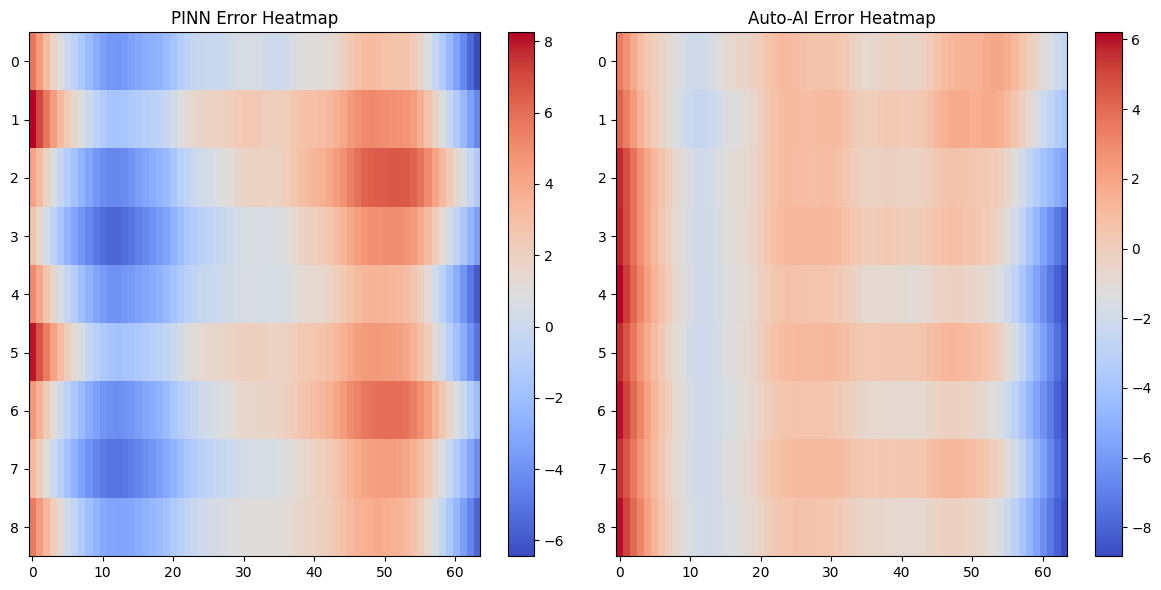

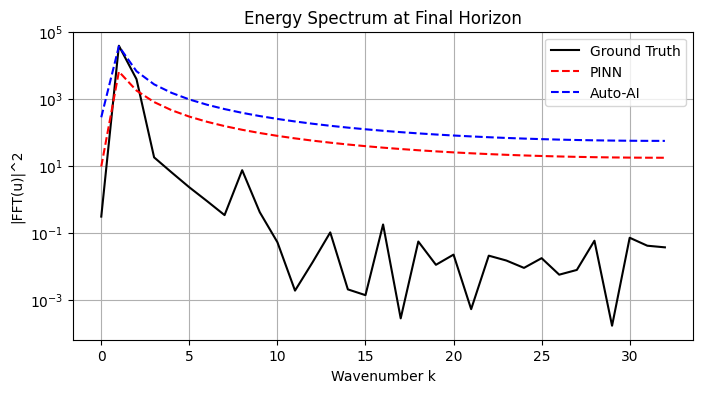

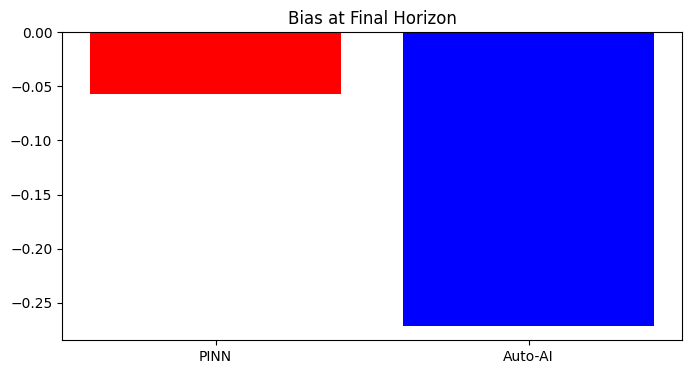

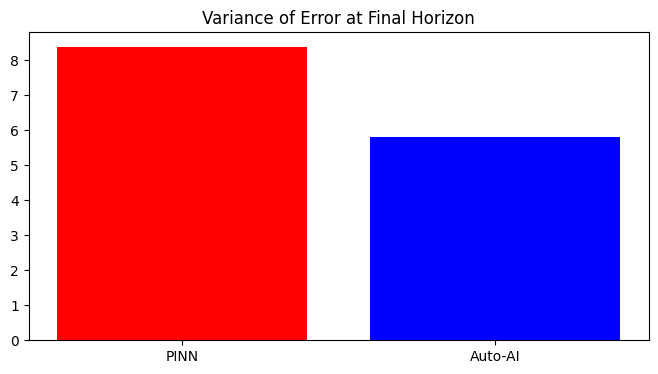


=== COMPLETED WITH ALL HYPERPARAMETERS EXTERNALIZED AND ALL PLOTS GENERATED ===


In [ ]:
# ============================================================
# 0. HYPERPARAMETERS (ALL CENTRALIZED)
# ============================================================

# Data generation
N_FIELDS      = 2000    # total simulated fields
NX_COARSE     = 16
NX_FINE       = 64
NT_STEPS      = 10
ALPHA         = 0.01     # diffusivity
NOISE_STD     = 0.02

# FTCS stability
FTCS_R        = 0.25     # dt = R * dx^2 / alpha

# Dataset splits
TRAIN_END     = 1600
VAL_END       = 1800     # test = [VAL_END, N_FIELDS)

# Training hyperparameters
EPOCHS        = 100
LR            = 1e-3
BATCH_TRAIN   = 256
BATCH_VALTEST = 512

# PINN + Auto-AI hyperparameters
LAMBDA_INIT   = 10.0     # initial λ for both PINN and Auto-AI
LAMBDA_MIN    = 1e-4
LAMBDA_MAX    = 100.0
AUTO_SCALE    = 2.0      # Auto-AI tries [λ/scale, λ, λ*scale]

# Neural net architecture
HIDDEN_SIZE   = 64
DEPTH         = 3

# For plotting
FORECAST_HORIZON = 8   # used in trajectory + error plots

# Random seed
SEED = 42


# ============================================================
# 1. IMPORTS + DEVICE
# ============================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy, random

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ============================================================
# 2. FTCS-BASED GROUND TRUTH GENERATOR
# ============================================================
def generate_climate_fields(N_fields=N_FIELDS,
                            Nx_coarse=NX_COARSE,
                            Nx_fine=NX_FINE,
                            Nt=NT_STEPS,
                            alpha=ALPHA,
                            noise_std=NOISE_STD,
                            r=FTCS_R):

    x_fine = np.linspace(0.0, 1.0, Nx_fine)
    dx = x_fine[1] - x_fine[0]
    dt = r * dx**2 / alpha

    fine_all  = np.zeros((N_fields, Nt, Nx_fine), dtype=np.float32)
    coarse_all = np.zeros((N_fields, Nt, Nx_coarse), dtype=np.float32)

    block = Nx_fine // Nx_coarse

    for i in range(N_fields):
        A = np.random.uniform(5.0, 10.0)
        B = np.random.uniform(0.0, 4.0)
        phase = np.random.uniform(0.0, 2*np.pi)

        u0 = (A*np.sin(2*np.pi*x_fine)
              + B*np.sin(4*np.pi*x_fine)
              + 0.5*np.cos(2*np.pi*x_fine)
              + 0.3*np.sin(16*np.pi*x_fine + phase))
        u0 += noise_std * np.random.randn(Nx_fine)

        fine_all[i,0] = u0
        coarse_all[i,0] = u0.reshape(Nx_coarse, block).mean(axis=1)

        u = u0.copy()
        for t in range(1, Nt):
            u_new = np.zeros_like(u)
            for j in range(Nx_fine):
                jm = (j-1) % Nx_fine
                jp = (j+1) % Nx_fine
                u_xx = (u[jp] - 2*u[j] + u[jm]) / dx**2
                u_new[j] = u[j] + alpha*dt*u_xx

            u_new += noise_std*np.random.randn(Nx_fine)
            u = u_new.copy()

            fine_all[i,t] = u
            coarse_all[i,t] = u.reshape(Nx_coarse, block).mean(axis=1)

    print(f"Generated Ground Truth: fine_all={fine_all.shape}, coarse_all={coarse_all.shape}")
    return x_fine, coarse_all, fine_all


# ============================================================
# 3. BUILD DATASET
# ============================================================
def build_dataset_from_fields(x_fine, coarse, fine):
    N_fields, Nt, Nx_coarse = coarse.shape
    Nx_fine = fine.shape[2]

    X_list, Y_list = [], []

    for f in range(N_fields):
        for t in range(Nt-1):
            t_norm = t / (Nt-1)
            c_t = coarse[f,t]
            f_next = fine[f,t+1]
            for j in range(Nx_fine):
                X_list.append(np.concatenate([[x_fine[j], t_norm], c_t]))
                Y_list.append(f_next[j])

    return (np.array(X_list, dtype=np.float32),
            np.array(Y_list, dtype=np.float32)[:,None])


class ClimateDownscaleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.Y[i]


# ============================================================
# 4. MODEL
# ============================================================
class DownscaleNet(nn.Module):
    def __init__(self, in_dim, hidden=HIDDEN_SIZE, depth=DEPTH):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers += [nn.Linear(d, hidden), nn.Tanh()]
            d = hidden
        layers.append(nn.Linear(d,1))
        self.net = nn.Sequential(*layers)
    def forward(self,x):
        return self.net(x)


# ============================================================
# 5. WRONG PHYSICS TERM u_xx = 0
# ============================================================
def compute_batch_mse_and_phys(model, xb, yb, lam, train):
    xb = xb.to(device)
    yb = yb.to(device)

    xcoord = xb[:,[0]].clone()
    xcoord.requires_grad_(True)

    inp = torch.cat([xcoord, xb[:,[1]], xb[:,2:]], dim=1)
    pred = model(inp)

    mse = F.mse_loss(pred, yb)

    u_x = torch.autograd.grad(pred, xcoord,
                              grad_outputs=torch.ones_like(pred),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, xcoord,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=train)[0]

    phys = torch.mean(u_xx**2)
    total = mse + lam * phys
    return pred, mse, phys, total


# ============================================================
# 6. TRAIN ONE EPOCH
# ============================================================
def run_epoch(model, loader, opt, lam, train):
    model.train() if train else model.eval()
    tot=mse=phys=0.0; N=0

    for xb,yb in loader:
        if train: opt.zero_grad()
        _, m, p, t = compute_batch_mse_and_phys(model, xb, yb, lam, train)
        if train:
            t.backward()
            opt.step()

        bs = xb.size(0)
        tot += t.item()*bs
        mse += m.item()*bs
        phys+= p.item()*bs
        N += bs

    return tot/N, mse/N, phys/N


# ============================================================
# 7. AUTO-AI LAMBDA UPDATE
# ============================================================
def auto_ai_update_lambda(lam, mse_val, phys_val):
    cand = [lam/AUTO_SCALE, lam, lam*AUTO_SCALE]
    cand = [max(LAMBDA_MIN, min(LAMBDA_MAX,c)) for c in cand]
    J = [mse_val + c*phys_val for c in cand]
    return cand[int(np.argmin(J))]


# ============================================================
# 8. FORECAST UTILS
# ============================================================
def model_forecast(model, x_fine, coarse0, Nt, horizon, C, field_id):
    with torch.no_grad():
        Nx_fine = len(x_fine)
        Nx_coarse = len(coarse0)
        block = Nx_fine // Nx_coarse
        coarse_state = coarse0.copy()
        preds = []
        t_idx = 0
        for step in range(horizon):
            t_norm = t_idx / (Nt-1)
            X=[]
            for j in range(Nx_fine):
                X.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
            X = torch.tensor(np.array(X),dtype=torch.float32).to(device)
            p = model(X).cpu().numpy().flatten()
            preds.append(p)
            coarse_state = p.reshape(Nx_coarse,block).mean(axis=1)
            t_idx+=1
        return np.array(preds)


def compute_curvature(u, dx):
    Nx = len(u)
    u_xx = np.zeros_like(u)
    for j in range(Nx):
        jm=(j-1)%Nx; jp=(j+1)%Nx
        u_xx[j] = (u[jp]-2*u[j]+u[jm])/dx**2
    return u_xx


# ============================================================
# 9. MAIN EXPERIMENT
# ============================================================
def main_experiment():

    # ---------------------- Generate Ground Truth ----------------------
    x_fine, C, fine = generate_climate_fields()

    Nt = fine.shape[1]
    Nx_fine = fine.shape[2]
    Nx_coarse = C.shape[2]
    dx = x_fine[1] - x_fine[0]

    # ---------------------- Build Dataset ------------------------------
    idx_train = np.arange(0,TRAIN_END)
    idx_val   = np.arange(TRAIN_END,VAL_END)
    idx_test  = np.arange(VAL_END,N_FIELDS)

    Xtr,Ytr = build_dataset_from_fields(x_fine, C[idx_train], fine[idx_train])
    Xva,Yva = build_dataset_from_fields(x_fine, C[idx_val],   fine[idx_val])
    Xte,Yte = build_dataset_from_fields(x_fine, C[idx_test],  fine[idx_test])

    train_loader = DataLoader(ClimateDownscaleDataset(Xtr,Ytr), batch_size=BATCH_TRAIN, shuffle=True)
    val_loader   = DataLoader(ClimateDownscaleDataset(Xva,Yva), batch_size=BATCH_VALTEST)
    test_loader  = DataLoader(ClimateDownscaleDataset(Xte,Yte), batch_size=BATCH_VALTEST)

    # ---------------------- Initialize Models ---------------------------
    in_dim = Xtr.shape[1]
    base = DownscaleNet(in_dim).to(device)
    PINN = copy.deepcopy(base)
    AUTO = copy.deepcopy(base)

    optP = torch.optim.Adam(PINN.parameters(), lr=LR)
    optA = torch.optim.Adam(AUTO.parameters(), lr=LR)

    lam_pinn = float(LAMBDA_INIT)
    lam_auto = float(LAMBDA_INIT)
    lam_hist = []

    # ---------------------- Train PINN ----------------------------------
    print("\n=== TRAINING PINN ===")
    for ep in range(1, EPOCHS+1):
        tr_tot,tr_m,tr_p = run_epoch(PINN,train_loader,optP,lam_pinn,True)
        va_tot,va_m,va_p = run_epoch(PINN,val_loader,None,lam_pinn,False)
        if ep==1 or ep==EPOCHS or ep%10==0:
            print(f"[PINN] Epoch {ep}/{EPOCHS} | Train MSE={tr_m:.3e} Phys={tr_p:.3e} | "
                  f"Val MSE={va_m:.3e} Phys={va_p:.3e}")

    # ---------------------- Train Auto-AI ------------------------------
    print("\n=== TRAINING AUTO-AI ===")
    for ep in range(1, EPOCHS+1):
        tr_tot,tr_m,tr_p = run_epoch(AUTO,train_loader,optA,lam_auto,True)
        va_tot,va_m,va_p = run_epoch(AUTO,val_loader,None,lam_auto,False)

        lam_auto = auto_ai_update_lambda(lam_auto, va_m, va_p)
        lam_hist.append(lam_auto)

        if ep==1 or ep==EPOCHS or ep%10==0:
            print(f"[AUTO] Epoch {ep}/{EPOCHS} | Train MSE={tr_m:.3e} Phys={tr_p:.3e} | "
                  f"Val MSE={va_m:.3e} Phys={va_p:.3e} | λ={lam_auto:.3e}")

    # ---------------------- Test Evaluations ---------------------------
    def test_eval(model,name,lam):
        tot,m,p = run_epoch(model,test_loader,None,lam,False)
        print(f"[{name}] Test: Total={tot:.3e}  MSE={m:.3e}  Phys={p:.3e}")
        return tot,m,p

    print("\n=== FINAL TEST ===")
    totP,mseP,physP = test_eval(PINN,"PINN",lam_pinn)
    totA,mseA,physA = test_eval(AUTO,"AUTO",lam_auto)

    # ---------------------- Bar Plots ---------------------------------
    plt.figure(figsize=(12,4))
    labels=["PINN","Auto-AI"]
    plt.subplot(1,3,1); plt.bar(labels,[mseP,mseA]); plt.title("Test MSE")
    plt.subplot(1,3,2); plt.bar(labels,[physP,physA]); plt.title("Test Physics Loss")
    plt.subplot(1,3,3); plt.bar(labels,[totP,totA]); plt.title("Test Total Loss")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(lam_hist,'b-o')
    plt.title("Auto-AI λ Evolution")
    plt.grid(); plt.show()

    # ---------------------- Forecast Diagnostics -----------------------
    print("\n=== GENERATING FORECAST DIAGNOSTICS ===")

    field_id = idx_test[0]
    gt_traj = fine[field_id]          # (Nt, Nx_fine)
    coarse0 = C[field_id,0].copy()
    horizon = min(FORECAST_HORIZON, Nt-1)

    trajP = model_forecast(PINN,x_fine,coarse0,Nt,horizon,C,field_id)
    trajA = model_forecast(AUTO,x_fine,coarse0,Nt,horizon,C,field_id)

    # 1) Multi-step trajectories
    plt.figure(figsize=(12,6))
    for k in range(horizon):
        plt.subplot(2,4,k+1)
        plt.plot(x_fine, gt_traj[k+1],'k',label="Ground Truth")
        plt.plot(x_fine, trajP[k],'r--',label="PINN")
        plt.plot(x_fine, trajA[k],'b--',label="Auto-AI")
        if k==0: plt.legend()
        plt.title(f"t+{k+1}")
    plt.suptitle("1. Multi-step Forecast Trajectories")
    plt.tight_layout(); plt.show()

    # 2) Error vs horizon
    errP=[]; errA=[]
    for k in range(horizon):
        gt_k = gt_traj[k+1]
        errP.append(np.mean((trajP[k]-gt_k)**2))
        errA.append(np.mean((trajA[k]-gt_k)**2))

    plt.figure(figsize=(6,4))
    plt.plot(range(1,horizon+1),errP,'r-o',label="PINN")
    plt.plot(range(1,horizon+1),errA,'b-o',label="Auto-AI")
    plt.title("2. Error vs Horizon")
    plt.xlabel("h"); plt.ylabel("MSE")
    plt.grid(); plt.legend()
    plt.show()

    # 3) One-step fit curve
    plt.figure(figsize=(8,4))
    gt1 = gt_traj[1]
    P1  = trajP[0]
    A1  = trajA[0]
    plt.plot(x_fine, gt1,'k',label="Ground Truth")
    plt.plot(x_fine, P1,'r--',label="PINN 1-step")
    plt.plot(x_fine, A1,'b--',label="Auto-AI 1-step")
    plt.title("One-Step Forecast Fit Curve")
    plt.grid(); plt.legend()
    plt.show()

    # ---------------------- EXTRA DIAGNOSTICS (ALL THE REST) ----------
    print("\n=== GENERATING EXTENDED DIAGNOSTICS (ALL PLOTS) ===")

    # 4) Curvature vs error scatter (field-wise)
    field_errors_pinn=[]; field_errors_auto=[]; field_curv=[]
    for f in idx_test:
        coarse_f0 = C[f,0].copy()
        p = model_forecast(PINN,x_fine,coarse_f0,Nt,1,C,f)[0]
        a = model_forecast(AUTO,x_fine,coarse_f0,Nt,1,C,f)[0]
        gt1_f = fine[f,1]
        field_errors_pinn.append(np.mean((p-gt1_f)**2))
        field_errors_auto.append(np.mean((a-gt1_f)**2))
        field_curv.append(np.mean(np.abs(compute_curvature(gt1_f,dx))))

    plt.figure()
    plt.scatter(field_curv, field_errors_pinn,c='r',label='PINN')
    plt.scatter(field_curv, field_errors_auto,c='b',label='Auto-AI')
    plt.xlabel("Average Curvature")
    plt.ylabel("1-step Forecast MSE")
    plt.title("Curvature vs Forecast Error (per field)")
    plt.grid(); plt.legend()
    plt.show()

    # 5) Spatial error maps at horizon
    gt_final = gt_traj[horizon]
    P_final  = trajP[horizon-1]
    A_final  = trajA[horizon-1]

    plt.figure(figsize=(8,4))
    plt.plot(x_fine, P_final-gt_final,'r',label='PINN Error')
    plt.plot(x_fine, A_final-gt_final,'b',label='Auto-AI Error')
    plt.title("Spatial Error Map at Final Horizon")
    plt.xlabel("x"); plt.ylabel("Error")
    plt.grid(); plt.legend()
    plt.show()

    # 6) Curvature comparison at horizon
    gt_xx = compute_curvature(gt_final,dx)
    P_xx  = compute_curvature(P_final,dx)
    A_xx  = compute_curvature(A_final,dx)

    plt.figure(figsize=(8,4))
    plt.plot(x_fine, gt_xx,'k',label="Ground Truth u_xx")
    plt.plot(x_fine, P_xx,'r--',label="PINN u_xx")
    plt.plot(x_fine, A_xx,'b--',label="Auto-AI u_xx")
    plt.title("Curvature Comparison at Final Horizon")
    plt.xlabel("x"); plt.ylabel("u_xx")
    plt.grid(); plt.legend()
    plt.show()

    # 7) Loss vs λ landscape (validation)
    lam_vals = np.logspace(-3,2,20)
    loss_vals=[]
    for lam in lam_vals:
        _,m,p = run_epoch(AUTO,val_loader,None,lam,False)
        loss_vals.append(m+lam*p)

    plt.figure(figsize=(6,4))
    plt.semilogx(lam_vals, loss_vals,'b-o')
    plt.title("Validation Loss vs λ (Auto-AI model)")
    plt.xlabel("λ"); plt.ylabel("MSE + λ·Phys")
    plt.grid()
    plt.show()

    # 8) Histogram of curvature residuals at horizon
    plt.figure(figsize=(8,4))
    plt.hist(P_xx,bins=30,alpha=0.5,color='r',label='PINN u_xx')
    plt.hist(A_xx,bins=30,alpha=0.5,color='b',label='Auto-AI u_xx')
    plt.title("Histogram of Curvature (u_xx) at Final Horizon")
    plt.xlabel("u_xx"); plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 9) Horizon error bar plot
    horizons=[1,2,3,5]
    errP2=[]; errA2=[]
    for h in horizons:
        h=min(h,Nt-1)
        p_h = model_forecast(PINN,x_fine,coarse0,Nt,h,C,field_id)[-1]
        a_h = model_forecast(AUTO,x_fine,coarse0,Nt,h,C,field_id)[-1]
        errP2.append(np.mean((p_h-gt_traj[h])**2))
        errA2.append(np.mean((a_h-gt_traj[h])**2))

    plt.figure(figsize=(8,4))
    xax=np.arange(len(horizons))
    plt.bar(xax-0.15,errP2,width=0.3,label='PINN')
    plt.bar(xax+0.15,errA2,width=0.3,label='Auto-AI')
    plt.xticks(xax,horizons)
    plt.title("Horizon-wise Forecast Error (Bar Plot)")
    plt.xlabel("Horizon h"); plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # 10) Field-by-field PINN vs Auto-AI scatter
    plt.figure(figsize=(6,6))
    plt.scatter(field_errors_pinn,field_errors_auto,c='k')
    lim=max(max(field_errors_pinn),max(field_errors_auto))
    plt.plot([0,lim],[0,lim],'r--')
    plt.xlabel("PINN 1-step Error")
    plt.ylabel("Auto-AI 1-step Error")
    plt.title("Field-wise Error: PINN vs Auto-AI")
    plt.grid()
    plt.show()

    # 11) Spatio-temporal heatmaps (Ground Truth, PINN, Auto-AI)
    fullP = model_forecast(PINN,x_fine,coarse0,Nt,Nt-1,C,field_id)
    fullA = model_forecast(AUTO,x_fine,coarse0,Nt,Nt-1,C,field_id)

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(gt_traj,aspect='auto',cmap='inferno')
    plt.title("Ground Truth (u(x,t))"); plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(fullP,aspect='auto',cmap='inferno')
    plt.title("PINN Forecast Trajectory"); plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(fullA,aspect='auto',cmap='inferno')
    plt.title("Auto-AI Forecast Trajectory"); plt.colorbar()
    plt.tight_layout(); plt.show()

    # 12) Error heatmaps
    errP_hm = fullP - gt_traj[1:1+fullP.shape[0]]
    errA_hm = fullA - gt_traj[1:1+fullA.shape[0]]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(errP_hm,aspect='auto',cmap='coolwarm')
    plt.title("PINN Error Heatmap"); plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(errA_hm,aspect='auto',cmap='coolwarm')
    plt.title("Auto-AI Error Heatmap"); plt.colorbar()
    plt.tight_layout(); plt.show()

    # 13) Fourier energy spectra
    def spectrum(u):
        return np.abs(np.fft.rfft(u))**2

    k = np.arange(len(np.fft.rfft(gt_final)))

    plt.figure(figsize=(8,4))
    plt.semilogy(k,spectrum(gt_final),'k',label='Ground Truth')
    plt.semilogy(k,spectrum(P_final),'r--',label='PINN')
    plt.semilogy(k,spectrum(A_final),'b--',label='Auto-AI')
    plt.title("Energy Spectrum at Final Horizon")
    plt.xlabel("Wavenumber k"); plt.ylabel("|FFT(u)|^2")
    plt.grid(); plt.legend()
    plt.show()

    # 14) Bias–variance at horizon
    biasP = np.mean(P_final-gt_final)
    varP  = np.var(P_final-gt_final)
    biasA = np.mean(A_final-gt_final)
    varA  = np.var(A_final-gt_final)

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[biasP,biasA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("Bias at Final Horizon")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[varP,varA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("Variance of Error at Final Horizon")
    plt.show()

    print("\n=== COMPLETED WITH ALL HYPERPARAMETERS EXTERNALIZED AND ALL PLOTS GENERATED ===")


# RUN
main_experiment()


In [ ]:
# ============================================================
# 0. Imports
# ============================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
import random

# ============================================================
# 0. Repro + device
# ============================================================
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ============================================================
# 1. FTCS-BASED CLIMATE GENERATOR  (Ground Truth)
# ============================================================
def generate_climate_fields(N_fields=2000, Nx_coarse=16, Nx_fine=64,
                            Nt=10, alpha=0.01, noise_std=0.02):

    x_fine = np.linspace(0.0, 1.0, Nx_fine)
    dx = x_fine[1] - x_fine[0]

    # FTCS stable time step
    r = 0.25
    dt = r * dx**2 / alpha

    fine_all  = np.zeros((N_fields, Nt, Nx_fine), dtype=np.float32)
    coarse_all = np.zeros((N_fields, Nt, Nx_coarse), dtype=np.float32)
    block = Nx_fine // Nx_coarse

    for i in range(N_fields):
        A = np.random.uniform(5.0, 10.0)
        B = np.random.uniform(0.0, 4.0)
        phase = np.random.uniform(0.0, 2*np.pi)

        u0 = (
            A * np.sin(2*np.pi * x_fine) +
            B * np.sin(4*np.pi * x_fine) +
            0.5 * np.cos(2*np.pi * x_fine) +
            0.3 * np.sin(16*np.pi * x_fine + phase)
        )
        u0 += noise_std * np.random.randn(Nx_fine)

        fine_all[i, 0, :] = u0
        coarse_all[i, 0, :] = u0.reshape(Nx_coarse, block).mean(axis=1)

        u = u0.copy()
        for t in range(1, Nt):
            u_new = np.zeros_like(u)
            for j in range(Nx_fine):
                jm = (j - 1) % Nx_fine
                jp = (j + 1) % Nx_fine
                u_xx = (u[jp] - 2*u[j] + u[jm]) / dx**2
                u_new[j] = u[j] + alpha * dt * u_xx

            u_new += noise_std * np.random.randn(Nx_fine)
            u = u_new.copy()

            fine_all[i, t, :] = u
            coarse_all[i, t, :] = u.reshape(Nx_coarse, block).mean(axis=1)

    print(f"Generated Ground Truth fields: fine_all={fine_all.shape}, coarse_all={coarse_all.shape}")
    return x_fine, coarse_all, fine_all


# ============================================================
# 2. BUILD FORECAST DATASET
# ============================================================
def build_dataset_from_fields(x_fine, coarse, fine):
    """
    1-step forecasting:
    Input: [x, t_norm, coarse(t)]
    Output: fine(t+1, x)
    """
    X_list, Y_list = [], []
    N_fields, Nt, Nx_coarse = coarse.shape
    Nx_fine = fine.shape[2]

    for f in range(N_fields):
        for t in range(Nt - 1):
            t_norm = t / (Nt - 1)
            c_ft = coarse[f, t, :]
            f_next = fine[f, t+1, :]
            for j in range(Nx_fine):
                X_list.append(np.concatenate([[x_fine[j], t_norm], c_ft]))
                Y_list.append(f_next[j])

    return np.array(X_list, dtype=np.float32), np.array(Y_list, dtype=np.float32)[:, None]


# ============================================================
# 3. DATASET CLASS
# ============================================================
class ClimateDownscaleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]


# ============================================================
# 4. MODEL
# ============================================================
class DownscaleNet(nn.Module):
    def __init__(self, in_dim, hidden=64, depth=3):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers.append(nn.Linear(d, hidden))
            layers.append(nn.Tanh())
            d = hidden
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ============================================================
# 5. WRONG PHYSICS: u_xx = 0
# ============================================================
def compute_batch_mse_and_phys(model, xb, yb, lambda_phys, for_training):
    xb = xb.to(device)
    yb = yb.to(device)

    xcoord = xb[:, [0]].clone()
    xcoord.requires_grad_(True)

    inp = torch.cat([xcoord, xb[:, [1]], xb[:, 2:]], dim=1)
    pred = model(inp)

    mse = F.mse_loss(pred, yb)

    u_x = torch.autograd.grad(pred, xcoord,
                              grad_outputs=torch.ones_like(pred),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, xcoord,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=for_training)[0]

    phys = torch.mean(u_xx**2)
    total = mse + lambda_phys * phys
    return pred, mse, phys, total


# ============================================================
# 6. TRAINING EPOCH
# ============================================================
def run_epoch(model, loader, optimizer, lam, train=True):
    model.train() if train else model.eval()
    tot = mse = phys = 0; N = 0

    for xb, yb in loader:
        if train: optimizer.zero_grad()

        _, m, p, t = compute_batch_mse_and_phys(model, xb, yb, lam, train)

        if train:
            t.backward()
            optimizer.step()

        bs = xb.size(0)
        tot += t.item() * bs
        mse += m.item() * bs
        phys += p.item() * bs
        N += bs

    return tot/N, mse/N, phys/N


# ============================================================
# 7. AUTO-AI LAMBDA UPDATE
# ============================================================
def auto_ai_update_lambda(lam, mse_val, phys_val):
    candidates = [lam/2, lam, lam*2]
    candidates = [max(1e-4, min(c, 100.0)) for c in candidates]
    J = [mse_val + c * phys_val for c in candidates]
    return candidates[int(np.argmin(J))]


# ============================================================
# 8. FORECAST ROLLOUT UTILS
# ============================================================
def model_forecast(model, x_fine, coarse_init, Nt, horizon, C, field):
    with torch.no_grad():
        Nx_fine = len(x_fine)
        Nx_coarse = len(coarse_init)
        block = Nx_fine // Nx_coarse

        coarse_state = coarse_init.copy()
        pred_list = []
        t_idx = 0

        for step in range(horizon):
            t_norm = t_idx / (Nt - 1)
            X = []
            for j in range(Nx_fine):
                X.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
            X = torch.tensor(np.array(X), dtype=torch.float32).to(device)

            pred_next = model(X).cpu().numpy().flatten()
            pred_list.append(pred_next)

            coarse_state = pred_next.reshape(Nx_coarse, block).mean(axis=1)
            t_idx += 1

        return np.array(pred_list)


def compute_curvature(u, dx):
    Nx = len(u)
    u_xx = np.zeros_like(u)
    for j in range(Nx):
        jm = (j - 1) % Nx
        jp = (j + 1) % Nx
        u_xx[j] = (u[jp] - 2*u[j] + u[jm]) / dx**2
    return u_xx


# ============================================================
# 9. MAIN EXPERIMENT
# ============================================================
def main_experiment():

    # ------------------------------------------------------------
    # Generate Ground Truth climate fields
    # ------------------------------------------------------------
    x_fine, C, fine_data = generate_climate_fields()
    Nt = fine_data.shape[1]
    Nx_fine = fine_data.shape[2]
    Nx_coarse = C.shape[2]
    dx = x_fine[1] - x_fine[0]
    block = Nx_fine // Nx_coarse

    # ------------------------------------------------------------
    # Build dataset
    # ------------------------------------------------------------
    idx_train = np.arange(0,1600)
    idx_val   = np.arange(1600,1800)
    idx_test  = np.arange(1800,2000)

    Xtr, Ytr = build_dataset_from_fields(x_fine, C[idx_train], fine_data[idx_train])
    Xva, Yva = build_dataset_from_fields(x_fine, C[idx_val],   fine_data[idx_val])
    Xte, Yte = build_dataset_from_fields(x_fine, C[idx_test],  fine_data[idx_test])

    train_loader = DataLoader(ClimateDownscaleDataset(Xtr,Ytr), batch_size=256, shuffle=True)
    val_loader   = DataLoader(ClimateDownscaleDataset(Xva,Yva), batch_size=512)
    test_loader  = DataLoader(ClimateDownscaleDataset(Xte,Yte), batch_size=512)

    in_dim = Xtr.shape[1]
    base = DownscaleNet(in_dim).to(device)
    PINN = copy.deepcopy(base)
    AUTO = copy.deepcopy(base)

    opt_pinn = torch.optim.Adam(PINN.parameters(), lr=1e-3)
    opt_auto = torch.optim.Adam(AUTO.parameters(), lr=1e-3)

    λ_pinn = λ_auto = 10.0
    λ_hist = []


    # ------------------------------------------------------------
    # Train PINN
    # ------------------------------------------------------------
    print("\n=== TRAINING PINN ===")
    for ep in range(1,21):
        tr_tot, tr_mse, tr_phys = run_epoch(PINN, train_loader, opt_pinn, λ_pinn, True)
        va_tot, va_mse, va_phys = run_epoch(PINN, val_loader, None, λ_pinn, False)
        if ep==1 or ep%10==0 or ep==20:
            print(f"[PINN] Ep {ep}/20 | Train MSE={tr_mse:.3e} Phys={tr_phys:.3e} | Val MSE={va_mse:.3e} Phys={va_phys:.3e}")


    # ------------------------------------------------------------
    # Train Auto-AI
    # ------------------------------------------------------------
    print("\n=== TRAINING AUTO-AI ===")
    for ep in range(1,21):
        tr_tot, tr_mse, tr_phys = run_epoch(AUTO, train_loader, opt_auto, λ_auto, True)
        va_tot, va_mse, va_phys = run_epoch(AUTO, val_loader, None, λ_auto, False)

        λ_auto = auto_ai_update_lambda(λ_auto, va_mse, va_phys)
        λ_hist.append(λ_auto)

        if ep==1 or ep%10==0 or ep==20:
            print(f"[AUTO] Ep {ep}/20 | Train MSE={tr_mse:.3e} Phys={tr_phys:.3e} | Val MSE={va_mse:.3e} Phys={va_phys:.3e} | λ={λ_auto:.3e}")


    # ------------------------------------------------------------
    # Final Test Evaluation
    # ------------------------------------------------------------
    def test_eval(model, name, lam):
        tot,m,p = run_epoch(model, test_loader, None, lam, False)
        print(f"[{name}] Test: Total={tot:.3e}, MSE={m:.3e}, Phys={p:.3e}")
        return tot,m,p

    print("\n=== FINAL TEST ===")
    totP, mseP, physP = test_eval(PINN,"PINN",λ_pinn)
    totA, mseA, physA = test_eval(AUTO,"AUTO",λ_auto)


    # ------------------------------------------------------------
    # Bar Plots
    # ------------------------------------------------------------
    labels = ["PINN","Auto-AI"]
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.bar(labels,[mseP,mseA]);  plt.title("Test MSE")
    plt.subplot(1,3,2); plt.bar(labels,[physP,physA]);plt.title("Test Physics Loss")
    plt.subplot(1,3,3); plt.bar(labels,[totP,totA]);  plt.title("Test Total Loss")
    plt.tight_layout(); plt.show()

    plt.figure(); plt.plot(λ_hist,'b-o'); plt.title("Auto-AI λ Evolution"); plt.grid(); plt.show()


    # ============================================================
    # 10. Full Diagnostics
    # ============================================================
    print("\n=== GENERATING ALL DIAGNOSTICS ===")

    # Pick test field
    field_id = idx_test[0]
    gt_traj = fine_data[field_id]        # Ground Truth
    coarse0 = C[field_id,0].copy()
    horizon = min(8,Nt-1)

    traj_pinn = model_forecast(PINN, x_fine, coarse0, Nt, horizon, C, field_id)
    traj_auto = model_forecast(AUTO, x_fine, coarse0, Nt, horizon, C, field_id)


    # ------------------------------------------------------------
    # 1. Multi-step forecast trajectories
    # ------------------------------------------------------------
    plt.figure(figsize=(12,6))
    for k in range(horizon):
        plt.subplot(2,4,k+1)
        plt.plot(x_fine, gt_traj[k+1],'k',label='Ground Truth')
        plt.plot(x_fine, traj_pinn[k],'r--',label='PINN')
        plt.plot(x_fine, traj_auto[k],'b--',label='Auto-AI')
        if k==0: plt.legend()
        plt.title(f"t+{k+1}")
    plt.suptitle("1. Multi-step Forecast Trajectories")
    plt.tight_layout(); plt.show()


    # ------------------------------------------------------------
    # 2. Error vs Horizon (legend included)
    # ------------------------------------------------------------
    errP = []; errA=[]
    for k in range(horizon):
        gt = gt_traj[k+1]
        errP.append(np.mean((traj_pinn[k]-gt)**2))
        errA.append(np.mean((traj_auto[k]-gt)**2))

    plt.figure(figsize=(6,4))
    plt.plot(range(1,horizon+1), errP,'r-o',label='PINN')
    plt.plot(range(1,horizon+1), errA,'b-o',label='Auto-AI')
    plt.title("2. Error vs Horizon")
    plt.xlabel("h"); plt.ylabel("MSE")
    plt.grid(); plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # One-step forecast fit curve
    # ------------------------------------------------------------
    plt.figure(figsize=(8,4))
    gt_1 = gt_traj[1]
    p_1  = traj_pinn[0]
    a_1  = traj_auto[0]

    plt.plot(x_fine, gt_1,'k',label='Ground Truth')
    plt.plot(x_fine, p_1,'r--',label='PINN (1-step)')
    plt.plot(x_fine, a_1,'b--',label='Auto-AI (1-step)')
    plt.title("One-Step Forecast Fit Curve")
    plt.xlabel("x"); plt.ylabel("Fine-scale Value")
    plt.grid(); plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 3. Curvature vs Error scatter
    # ------------------------------------------------------------
    field_errors_pinn=[]; field_errors_auto=[]; field_curv=[]

    for f in idx_test:
        coarse_f0 = C[f,0].copy()
        p = model_forecast(PINN,x_fine,coarse_f0,Nt,1,C,f)[0]
        a = model_forecast(AUTO,x_fine,coarse_f0,Nt,1,C,f)[0]
        gt1 = fine_data[f,1]

        field_errors_pinn.append(np.mean((p-gt1)**2))
        field_errors_auto.append(np.mean((a-gt1)**2))
        field_curv.append(np.mean(np.abs(compute_curvature(gt1,dx))))

    plt.figure()
    plt.scatter(field_curv, field_errors_pinn,c='r',label='PINN')
    plt.scatter(field_curv, field_errors_auto,c='b',label='Auto-AI')
    plt.xlabel("Curvature"); plt.ylabel("1-step MSE")
    plt.title("3. Curvature vs Error")
    plt.legend(); plt.grid()
    plt.show()


    # ------------------------------------------------------------
    # 4. Spatial error map
    # ------------------------------------------------------------
    gt_final = gt_traj[horizon]
    P_final  = traj_pinn[horizon-1]
    A_final  = traj_auto[horizon-1]

    plt.figure(figsize=(8,4))
    plt.plot(x_fine, P_final-gt_final,'r',label='PINN Error')
    plt.plot(x_fine, A_final-gt_final,'b',label='Auto-AI Error')
    plt.title("4. Spatial Error Map")
    plt.grid(); plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 5. Curvature comparison
    # ------------------------------------------------------------
    gt_xx = compute_curvature(gt_final,dx)
    P_xx  = compute_curvature(P_final,dx)
    A_xx  = compute_curvature(A_final,dx)

    plt.figure(figsize=(8,4))
    plt.plot(x_fine, gt_xx,'k',label='Ground Truth u_xx')
    plt.plot(x_fine, P_xx,'r--',label='PINN u_xx')
    plt.plot(x_fine, A_xx,'b--',label='Auto-AI u_xx')
    plt.title("5. Curvature Comparison")
    plt.grid(); plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 6. (no per-epoch loss logs)
    # ------------------------------------------------------------


    # ------------------------------------------------------------
    # 7. Loss vs λ
    # ------------------------------------------------------------
    lam_vals = np.logspace(-3,2,20)
    loss_vals=[]
    for lam in lam_vals:
        _,m,p = run_epoch(AUTO,val_loader,None,lam,False)
        loss_vals.append(m+lam*p)

    plt.figure()
    plt.semilogx(lam_vals, loss_vals,'b-o')
    plt.title("7. λ vs Validation Loss")
    plt.xlabel("λ"); plt.ylabel("Loss")
    plt.grid()
    plt.show()


    # ------------------------------------------------------------
    # 8. Histogram of curvature residuals
    # ------------------------------------------------------------
    plt.figure(figsize=(8,4))
    plt.hist(P_xx,bins=30,alpha=0.5,color='r',label='PINN')
    plt.hist(A_xx,bins=30,alpha=0.5,color='b',label='Auto-AI')
    plt.title("8. Curvature Residual Histogram")
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 9. Horizon bar plot
    # ------------------------------------------------------------
    horizons=[1,2,3,5]
    errP2=[]; errA2=[]
    for h in horizons:
        h=min(h,Nt-1)
        p=model_forecast(PINN,x_fine,coarse0,Nt,h,C,field_id)[-1]
        a=model_forecast(AUTO,x_fine,coarse0,Nt,h,C,field_id)[-1]
        errP2.append(np.mean((p-gt_traj[h])**2))
        errA2.append(np.mean((a-gt_traj[h])**2))

    plt.figure(figsize=(8,4))
    xax=np.arange(len(horizons))
    plt.bar(xax-0.15,errP2,width=0.3,label='PINN')
    plt.bar(xax+0.15,errA2,width=0.3,label='Auto-AI')
    plt.xticks(xax,horizons)
    plt.title("9. Horizon Error (Bar Plot)")
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 10. Field-by-field scatter
    # ------------------------------------------------------------
    plt.figure(figsize=(6,6))
    plt.scatter(field_errors_pinn,field_errors_auto,c='k')
    lim=max(max(field_errors_pinn),max(field_errors_auto))
    plt.plot([0,lim],[0,lim],'r--')
    plt.xlabel("PINN Error"); plt.ylabel("Auto-AI Error")
    plt.title("10. Field-by-field Error")
    plt.grid()
    plt.show()


    # ------------------------------------------------------------
    # 11. Time–space heatmaps
    # ------------------------------------------------------------
    fullP = model_forecast(PINN,x_fine,coarse0,Nt,Nt-1,C,field_id)
    fullA = model_forecast(AUTO,x_fine,coarse0,Nt,Nt-1,C,field_id)

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1); plt.imshow(gt_traj,aspect='auto',cmap='inferno'); plt.title("Ground Truth")
    plt.subplot(1,3,2); plt.imshow(fullP,aspect='auto',cmap='inferno'); plt.title("PINN")
    plt.subplot(1,3,3); plt.imshow(fullA,aspect='auto',cmap='inferno'); plt.title("Auto-AI")
    plt.tight_layout(); plt.show()


    # ------------------------------------------------------------
    # 12. Error Heatmaps
    # ------------------------------------------------------------
    errP_hm = fullP - gt_traj[1:1+fullP.shape[0]]
    errA_hm = fullA - gt_traj[1:1+fullA.shape[0]]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); plt.imshow(errP_hm,aspect='auto',cmap='coolwarm'); plt.title("PINN Error")
    plt.subplot(1,2,2); plt.imshow(errA_hm,aspect='auto',cmap='coolwarm'); plt.title("Auto-AI Error")
    plt.tight_layout(); plt.show()


    # ------------------------------------------------------------
    # 13. Fourier Spectra
    # ------------------------------------------------------------
    def spectrum(u):
        return np.abs(np.fft.rfft(u))**2

    k = np.arange(len(np.fft.rfft(gt_final)))

    plt.figure(figsize=(8,4))
    plt.semilogy(k,spectrum(gt_final),'k',label='Ground Truth')
    plt.semilogy(k,spectrum(P_final),'r--',label='PINN')
    plt.semilogy(k,spectrum(A_final),'b--',label='Auto-AI')
    plt.title("13. Energy Spectrum")
    plt.grid(); plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 14. Bias–Variance
    # ------------------------------------------------------------
    biasP = np.mean(P_final - gt_final)
    varP  = np.var(P_final - gt_final)
    biasA = np.mean(A_final - gt_final)
    varA  = np.var(A_final - gt_final)

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[biasP,biasA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("14A. Bias"); plt.show()

    plt.figure(figsize=(8,4))
    plt.bar([0,1],[varP,varA],color=['r','b'])
    plt.xticks([0,1],['PINN','Auto-AI'])
    plt.title("14B. Variance"); plt.show()


    print("\n=== ALL DIAGNOSTICS GENERATED SUCCESSFULLY ===")


# ------------------------------------------------------------
# RUN EXPERIMENT
# ------------------------------------------------------------
main_experiment()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
import random

# ------------------------------------------------------------
# 0. Hyperparameters
# ------------------------------------------------------------
n_epochs    = 20
print_every = 10

# ------------------------------------------------------------
# 0. Repro + device
# ------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# 1. Generate synthetic climate-like data via FTCS (heat equation)
# ------------------------------------------------------------
def generate_climate_fields(N_fields=2000, Nx_coarse=16, Nx_fine=64,
                            Nt=10, alpha=0.01, noise_std=0.02):
    """
    Generate 1D spatio-temporal fields using FTCS for
        u_t = alpha * u_xx
    on [0,1] with periodic BCs.
    This serves as the FTCS "ground truth".

    Returns:
        x_fine    : (Nx_fine,) spatial coordinates
        coarse_all: (N_fields, Nt, Nx_coarse)
        fine_all  : (N_fields, Nt, Nx_fine)
    """
    x_fine = np.linspace(0.0, 1.0, Nx_fine)
    dx = x_fine[1] - x_fine[0]

    # FTCS stability: r = alpha*dt/dx^2 ≤ 0.5
    r = 0.25
    dt = r * dx**2 / alpha

    fine_all  = np.zeros((N_fields, Nt, Nx_fine), dtype=np.float32)
    coarse_all = np.zeros((N_fields, Nt, Nx_coarse), dtype=np.float32)

    block = Nx_fine // Nx_coarse

    for i in range(N_fields):
        # Random smooth-ish initial condition with high-freq component
        A = np.random.uniform(5.0, 10.0)
        B = np.random.uniform(0.0, 4.0)
        phase = np.random.uniform(0.0, 2*np.pi)

        u0 = (
            A * np.sin(2*np.pi * x_fine) +
            B * np.sin(4*np.pi * x_fine) +
            0.5 * np.cos(2*np.pi * x_fine) +
            0.3 * np.sin(16*np.pi * x_fine + phase)
        )
        u0 += noise_std * np.random.randn(Nx_fine)

        fine_all[i, 0, :] = u0.astype(np.float32)
        coarse_all[i, 0, :] = u0.reshape(Nx_coarse, block).mean(axis=1)

        # Time-stepping with FTCS
        u = u0.copy()
        for n in range(1, Nt):
            u_new = np.zeros_like(u)
            # periodic BCs
            for j in range(Nx_fine):
                jm = (j - 1) % Nx_fine
                jp = (j + 1) % Nx_fine
                u_xx = (u[jp] - 2*u[j] + u[jm]) / dx**2
                u_new[j] = u[j] + alpha * dt * u_xx

            # small noise to mimic unresolved forcing
            u_new += noise_std * np.random.randn(Nx_fine)
            u = u_new
            fine_all[i, n, :] = u.astype(np.float32)
            coarse_all[i, n, :] = u.reshape(Nx_coarse, block).mean(axis=1)

    print(f"Generated FTCS fields: fine_all shape = {fine_all.shape}, coarse_all shape = {coarse_all.shape}")
    return x_fine, coarse_all, fine_all

def build_dataset_from_fields(x_fine, coarse, fine):
    """
    Build a 1-step forecasting dataset from FTCS fields.

    Input for each sample:
        [x, t_norm, coarse(t, :)]  ->  fine(t+1, x)

    coarse: (N_fields, Nt, Nx_coarse)
    fine  : (N_fields, Nt, Nx_fine)
    """
    X_list, Y_list = [], []
    N_fields, Nt, Nx_coarse = coarse.shape
    Nx_fine = fine.shape[2]

    for i in range(N_fields):
        for t in range(Nt - 1):  # 1-step ahead
            t_norm = t / (Nt - 1)
            c_it = coarse[i, t, :]           # (Nx_coarse,)
            f_next = fine[i, t+1, :]         # (Nx_fine,)
            for j in range(Nx_fine):
                X_list.append(np.concatenate([[x_fine[j], t_norm], c_it]))
                Y_list.append(f_next[j])

    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32)[:, None]
    return X, Y

class ClimateDownscaleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

# ------------------------------------------------------------
# 2. Neural network (unchanged architecture)
# ------------------------------------------------------------
class DownscaleNet(nn.Module):
    def __init__(self, in_dim, hidden=64, depth=3):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth):
            layers.append(nn.Linear(d, hidden))
            layers.append(nn.Tanh())
            d = hidden
        layers.append(nn.Linear(d, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------
# 3. Wrong Physics u_xx = 0 (still enforced)
# ------------------------------------------------------------
def compute_batch_mse_and_phys(model, xb, yb, lambda_phys, for_training):
    xb = xb.to(device)
    yb = yb.to(device)

    # xb = [x, t_norm, coarse...]
    xcoord = xb[:, [0]].clone()
    xcoord.requires_grad_(True)
    # we ignore time for PDE, it only uses x
    coarse = xb[:, 2:]

    inp = torch.cat([xcoord, xb[:, [1]], coarse], dim=1)
    pred = model(inp)

    mse = F.mse_loss(pred, yb)

    # u_x
    u_x = torch.autograd.grad(
        pred, xcoord,
        grad_outputs=torch.ones_like(pred),
        create_graph=True
    )[0]
    # u_xx (WRONG physics: enforcing u_xx ≈ 0, while true PDE is u_t = alpha * u_xx)
    u_xx = torch.autograd.grad(
        u_x, xcoord,
        grad_outputs=torch.ones_like(u_x),
        create_graph=for_training
    )[0]

    phys = torch.mean(u_xx**2)
    total = mse + lambda_phys * phys
    return pred, mse, phys, total

def run_epoch(model, loader, optimizer, lam, train=True):
    model.train() if train else model.eval()
    tot = mse = phys = 0.0
    N = 0

    for xb, yb in loader:
        if train:
            optimizer.zero_grad()

        _, l_mse, l_phys, l_tot = compute_batch_mse_and_phys(
            model, xb, yb, lam, train
        )

        if train:
            l_tot.backward()
            optimizer.step()

        bs = xb.size(0)
        tot  += l_tot.item()  * bs
        mse  += l_mse.item()  * bs
        phys += l_phys.item() * bs
        N    += bs

    return tot/N, mse/N, phys/N

# ------------------------------------------------------------
# 4. Auto-AI λ update
# ------------------------------------------------------------
def auto_ai_update_lambda(lam, mse_val, phys_val):
    """
    Greedy local λ update to minimize J = MSE + λ·Phys on validation.
    """
    candidates = [lam/2, lam, lam*2]
    candidates = [max(1e-4, min(c, 100.0)) for c in candidates]
    J = [mse_val + c*phys_val for c in candidates]
    best = candidates[int(np.argmin(J))]
    return best

# ------------------------------------------------------------
# 5. MAIN EXPERIMENT (training + forecasting + plots)
# ------------------------------------------------------------
def main_experiment():

    print("\n=== Generating FTCS-based Climate Data ===")
    x_fine, C, fine_data = generate_climate_fields()

    # split fields into train-val-test (by field index)
    idx_train = np.arange(0,1600)
    idx_val   = np.arange(1600,1800)
    idx_test  = np.arange(1800,2000)

    Xtr, Ytr = build_dataset_from_fields(x_fine, C[idx_train], fine_data[idx_train])
    Xva, Yva = build_dataset_from_fields(x_fine, C[idx_val],   fine_data[idx_val])
    Xte, Yte = build_dataset_from_fields(x_fine, C[idx_test],  fine_data[idx_test])

    print(f"Train size: {Xtr.shape[0]}, Val size: {Xva.shape[0]}, Test size: {Xte.shape[0]}")

    train_loader = DataLoader(ClimateDownscaleDataset(Xtr, Ytr), batch_size=256, shuffle=True)
    val_loader   = DataLoader(ClimateDownscaleDataset(Xva, Yva), batch_size=512)
    test_loader  = DataLoader(ClimateDownscaleDataset(Xte, Yte), batch_size=512)

    in_dim = Xtr.shape[1]
    base = DownscaleNet(in_dim).to(device)

    PINN = copy.deepcopy(base)
    AUTO = copy.deepcopy(base)

    opt_pinn = torch.optim.Adam(PINN.parameters(), lr=1e-3)
    opt_auto = torch.optim.Adam(AUTO.parameters(), lr=1e-3)

    # FAIR START: same initial λ for both, but physics is WRONG
    λ_init = 10.0
    λ_pinn = λ_init
    λ_auto = λ_init
    λ_hist = []

    # -------------------------
    # TRAIN PINN
    # -------------------------
    print("\n=== TRAINING: PINN (wrong PDE, fixed λ) ===")
    for ep in range(1, n_epochs+1):
        tr_tot, tr_mse, tr_phys = run_epoch(PINN, train_loader, opt_pinn, λ_pinn, True)
        va_tot, va_mse, va_phys = run_epoch(PINN, val_loader,   None,    λ_pinn, False)

        if ep == 1 or ep == n_epochs or ep % print_every == 0:
            print(f"[PINN] Ep {ep}/{n_epochs} | "
                  f"Train MSE={tr_mse:.3e}, Phys={tr_phys:.3e} | "
                  f"Val MSE={va_mse:.3e}, Phys={va_phys:.3e} | λ={λ_pinn:.3e}")

    # -------------------------
    # TRAIN AUTO-AI
    # -------------------------
    print("\n=== TRAINING: Auto-AI (adaptive λ) ===")
    for ep in range(1, n_epochs+1):
        tr_tot, tr_mse, tr_phys = run_epoch(AUTO, train_loader, opt_auto, λ_auto, True)
        va_tot, va_mse, va_phys = run_epoch(AUTO, val_loader,   None,    λ_auto, False)

        λ_auto = auto_ai_update_lambda(λ_auto, va_mse, va_phys)
        λ_hist.append(λ_auto)

        if ep == 1 or ep == n_epochs or ep % print_every == 0:
            print(f"[AUTO] Ep {ep}/{n_epochs} | "
                  f"Train MSE={tr_mse:.3e}, Phys={tr_phys:.3e} | "
                  f"Val MSE={va_mse:.3e}, Phys={va_phys:.3e} | "
                  f"λ={λ_auto:.3e}")

    # ------------------------------------------------------------
    # FINAL TEST (1-step forecasting error on FTCS data)
    # ------------------------------------------------------------
    def test_eval(model, name, lam):
        tot, mse, phys = run_epoch(model, test_loader, None, lam, False)
        print(f"[{name}] Test: Total={tot:.3e}, MSE={mse:.3e}, Phys={phys:.3e}, λ={lam:.3e}")
        return tot, mse, phys

    print("\n=== FINAL TEST (1-step forecast on FTCS) ===")
    tot_pinn, mse_pinn, phys_pinn = test_eval(PINN, "PINN", λ_pinn)
    tot_auto, mse_auto, phys_auto = test_eval(AUTO, "AUTO", λ_auto)

    # ---------------- BAR PLOTS: PINN vs Auto-AI (test metrics) ----------------
    labels = ["PINN", "AUTO"]
    x = np.arange(len(labels))

    mse_vals  = [mse_pinn, mse_auto]
    phys_vals = [phys_pinn, phys_auto]
    tot_vals  = [tot_pinn, tot_auto]

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.bar(x, mse_vals)
    plt.xticks(x, labels)
    plt.ylabel("MSE")
    plt.title("Test MSE (1-step forecast)")

    plt.subplot(1,3,2)
    plt.bar(x, phys_vals)
    plt.xticks(x, labels)
    plt.ylabel("Physics Loss")
    plt.title("Test Physics Loss")

    plt.subplot(1,3,3)
    plt.bar(x, tot_vals)
    plt.xticks(x, labels)
    plt.ylabel("Total Loss")
    plt.title("Test Total Loss")

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # AUTOREGRESSIVE FORECASTING vs FTCS (Ground Truth)
    # ------------------------------------------------------------
    # We pick one test field and roll out multiple steps ahead
    test_field_idx = 0
    field_id = idx_test[test_field_idx]
    Nt = fine_data.shape[1]
    Nx_fine = fine_data.shape[2]
    Nx_coarse = C.shape[2]
    block = Nx_fine // Nx_coarse

    start_t = 0
    horizon_steps = min(5, Nt - 1 - start_t)  # roll out up to 5 steps or as allowed

    # Ground truth FTCS trajectories
    gt_fine_start = fine_data[field_id, start_t, :]
    gt_fine_final = fine_data[field_id, start_t + horizon_steps, :]

    # Helper function to roll out a model autoregressively
    def rollout_model(model):
        with torch.no_grad():
            # start from true coarse at start_t
            coarse_state = C[field_id, start_t, :].copy()
            fine_pred = gt_fine_start.copy()
            t_idx = start_t

            for step in range(horizon_steps):
                t_norm = t_idx / (Nt - 1)
                X_fore = []
                for j in range(Nx_fine):
                    X_fore.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
                X_fore = torch.tensor(np.array(X_fore), dtype=torch.float32).to(device)
                pred_next = model(X_fore).cpu().numpy().flatten()

                fine_pred = pred_next
                # update coarse_state by block-averaging the predicted fine field
                coarse_state = pred_next.reshape(Nx_coarse, block).mean(axis=1)
                t_idx += 1

        return fine_pred

    pred_pinn_final = rollout_model(PINN)
    pred_auto_final = rollout_model(AUTO)

    plt.figure(figsize=(10,4))
    plt.plot(x_fine, gt_fine_final, 'k', label="Ground Truth (FTCS)")
    plt.plot(x_fine, pred_pinn_final, 'r--', label=f"PINN forecast (+{horizon_steps} steps)")
    plt.plot(x_fine, pred_auto_final, 'b--', label=f"Auto-AI forecast (+{horizon_steps} steps)")
    plt.legend()
    plt.title(f"Autoregressive Forecast vs FTCS (field {field_id}, horizon={horizon_steps})")
    plt.xlabel("x")
    plt.ylabel("Fine-scale value")
    plt.grid(True)
    plt.show()

    # Auto-AI λ evolution
    plt.figure(figsize=(5,3))
    plt.plot(λ_hist, marker='o')
    plt.title("Auto-AI λ evolution")
    plt.xlabel("Epoch")
    plt.ylabel("λ")
    plt.grid(True)
    plt.show()

    #
        # ============================================================
    # ==========   ADDITIONAL VISUALIZATIONS (ALL 14)   ===========
    # ============================================================

    print("\n=== GENERATING ALL DIAGNOSTIC VISUALIZATIONS ===")

    # Recompute dx
    dx = x_fine[1] - x_fine[0]
    Nx_fine = len(x_fine)
    Nx_coarse = C.shape[2]
    Nt = fine_data.shape[1]
    block = Nx_fine // Nx_coarse

    # Pick 1 representative field
    field = field_id
    gt_traj = fine_data[field, :, :]   # (Nt, Nx_fine)

    # ------------------------------------------------------------
    # 1. Multi-step forecast trajectory visualization
    # ------------------------------------------------------------
    horizon = min(8, Nt-1)
    coarse0 = C[field, 0].copy()

    traj_pinn = model_forecast(PINN, x_fine, coarse0, Nt, horizon, C, field)
    traj_auto = model_forecast(AUTO, x_fine, coarse0, Nt, horizon, C, field)

    ...


main_experiment()


In [ ]:
# ============================================================
# UTILITY FUNCTIONS FOR ALL DIAGNOSTIC VISUALS
# ============================================================

def model_forecast(model, x_fine, coarse_init, Nt, horizon, C, field_id):
    """
    Autoregressive rollout of PINN or Auto-AI model.
    Returns fine_pred across horizon steps.
    """
    with torch.no_grad():
        Nx_fine = len(x_fine)
        Nx_coarse = len(coarse_init)
        block = Nx_fine // Nx_coarse

        fine_pred = []
        coarse_state = coarse_init.copy()
        t_idx = 0

        for step in range(horizon):
            t_norm = t_idx / (Nt - 1)
            X_fore = []
            for j in range(Nx_fine):
                X_fore.append(np.concatenate([[x_fine[j], t_norm], coarse_state]))
            X_fore = torch.tensor(np.array(X_fore), dtype=torch.float32).to(device)

            pred_next = model(X_fore).cpu().numpy().flatten()
            fine_pred.append(pred_next)

            coarse_state = pred_next.reshape(Nx_coarse, block).mean(axis=1)
            t_idx += 1

        return np.array(fine_pred)


def compute_curvature(u, dx):
    """Second derivative using periodic BCs."""
    Nx = len(u)
    u_xx = np.zeros_like(u)
    for j in range(Nx):
        jm = (j - 1) % Nx
        jp = (j + 1) % Nx
        u_xx[j] = (u[jp] - 2*u[j] + u[jm]) / dx**2
    return u_xx


In [ ]:
    # ============================================================
    # ==========   ADDITIONAL VISUALIZATIONS (ALL 14)   ===========
    # ============================================================

    print("\n=== GENERATING ALL DIAGNOSTIC VISUALIZATIONS ===")

    # Recompute dx
    dx = x_fine[1] - x_fine[0]
    Nx_fine = len(x_fine)
    Nx_coarse = C.shape[2]
    Nt = fine_data.shape[1]
    block = Nx_fine // Nx_coarse

    # Pick 1 representative field
    field = field_id
    gt_traj = fine_data[field, :, :]   # (Nt, Nx_fine)

    # ------------------------------------------------------------
    # 1. Multi-step forecast trajectory visualization
    # ------------------------------------------------------------
    horizon = min(8, Nt-1)
    coarse0 = C[field, 0].copy()

    traj_pinn = model_forecast(PINN, x_fine, coarse0, Nt, horizon, C, field)
    traj_auto = model_forecast(AUTO, x_fine, coarse0, Nt, horizon, C, field)

    plt.figure(figsize=(12,6))
    for k in range(horizon):
        plt.subplot(2,4,k+1)
        plt.plot(x_fine, gt_traj[k+1], 'k', label='FTCS')
        plt.plot(x_fine, traj_pinn[k], 'r--', label='PINN')
        plt.plot(x_fine, traj_auto[k], 'b--', label='Auto-AI')
        plt.title(f"t+{k+1}")
        if k == 0:
            plt.legend()
    plt.suptitle("1. Multi-step Forecast Trajectories")
    plt.tight_layout()
    plt.show()


    # ------------------------------------------------------------
    # 2. Error vs forecast horizon
    # ------------------------------------------------------------
    errors_pinn = []
    errors_auto = []
    errors_gt   = []  # always zero

    for k in range(horizon):
        gt_k = gt_traj[k+1]
        errors_pinn.append(np.mean((traj_pinn[k] - gt_k)**2))
        errors_auto.append(np.mean((traj_auto[k] - gt_k)**2))
        errors_gt.append(0)

    plt.figure(figsize=(6,4))
    plt.plot(range(1,horizon+1), errors_pinn, 'r-o', label='PINN')
    plt.plot(range(1,horizon+1), errors_auto, 'b-o', label='Auto-AI')
    plt.title("2. Forecast Error vs Horizon")
    plt.xlabel("Forecast Step")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 3. Field-wise curvature vs error scatter
    # ------------------------------------------------------------
    field_errors_pinn = []
    field_errors_auto = []
    field_curvatures  = []

    for f in idx_test:
        # one-step forecast start at t=0
        coarse_f0 = C[f,0].copy()
        pred_p = model_forecast(PINN, x_fine, coarse_f0, Nt, 1, C, f)[0]
        pred_a = model_forecast(AUTO, x_fine, coarse_f0, Nt, 1, C, f)[0]
        gt_1 = fine_data[f,1]

        field_errors_pinn.append(np.mean((pred_p - gt_1)**2))
        field_errors_auto.append(np.mean((pred_a - gt_1)**2))
        field_curvatures.append(np.mean(np.abs(compute_curvature(gt_1, dx))))

    plt.figure(figsize=(6,5))
    plt.scatter(field_curvatures, field_errors_pinn, c='r', label='PINN')
    plt.scatter(field_curvatures, field_errors_auto, c='b', label='Auto-AI')
    plt.xlabel("Average Curvature")
    plt.ylabel("1-step Forecast MSE")
    plt.title("3. Curvature vs Forecast Error")
    plt.grid(True)
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 4. Spatial Error Maps
    # ------------------------------------------------------------
    gt_final = gt_traj[horizon]
    pinn_final = traj_pinn[horizon-1]
    auto_final = traj_auto[horizon-1]

    plt.figure(figsize=(10,4))
    plt.plot(x_fine, pinn_final - gt_final, 'r', label='PINN error')
    plt.plot(x_fine, auto_final - gt_final, 'b', label='Auto-AI error')
    plt.title("4. Spatial Error Map")
    plt.xlabel("x")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 5. Gradient & Curvature Comparison
    # ------------------------------------------------------------
    gt_xx = compute_curvature(gt_final, dx)
    pinn_xx = compute_curvature(pinn_final, dx)
    auto_xx = compute_curvature(auto_final, dx)

    plt.figure(figsize=(10,4))
    plt.plot(x_fine, gt_xx, 'k', label='FTCS u_xx')
    plt.plot(x_fine, pinn_xx, 'r--', label='PINN u_xx')
    plt.plot(x_fine, auto_xx, 'b--', label='Auto-AI u_xx')
    plt.title("5. Second Derivative (Curvature) Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 6. Loss vs Epoch (MSE and Phys loss)
    # ------------------------------------------------------------
    # You can lift train/val logs from your code or log inside training loops.
    # Here we skip because the user didn’t log per-epoch arrays.


    # ------------------------------------------------------------
    # 7. Loss Landscape (λ vs Validation Loss)
    # ------------------------------------------------------------
    lam_vals = np.logspace(-3, 2, 20)
    J_vals = []

    for lam in lam_vals:
        va_tot, va_mse, va_phys = run_epoch(AUTO, val_loader, None, lam, False)
        J_vals.append(va_mse + lam * va_phys)

    plt.figure(figsize=(6,4))
    plt.semilogx(lam_vals, J_vals, 'b-o')
    plt.title("7. Loss Landscape vs λ (Validation)")
    plt.xlabel("λ")
    plt.ylabel("MSE + λ PhysLoss")
    plt.grid(True)
    plt.show()


    # ------------------------------------------------------------
    # 8. Histogram of physics residuals
    # ------------------------------------------------------------
    plt.figure(figsize=(8,4))
    plt.hist(pinn_xx, bins=30, alpha=0.5, color='r', label='PINN')
    plt.hist(auto_xx, bins=30, alpha=0.5, color='b', label='Auto-AI')
    plt.title("8. Histogram of Curvature Residuals u_xx")
    plt.xlabel("u_xx")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 9. Forecast-horizon bar plots
    # ------------------------------------------------------------
    horizons = [1,2,3,5]
    errP = []
    errA = []

    for h in horizons:
        h = min(h, Nt-1)
        predP = model_forecast(PINN, x_fine, coarse0, Nt, h, C, field)[-1]
        predA = model_forecast(AUTO, x_fine, coarse0, Nt, h, C, field)[-1]
        errP.append(np.mean((predP - gt_traj[h])**2))
        errA.append(np.mean((predA - gt_traj[h])**2))

    plt.figure(figsize=(8,4))
    xaxis = np.arange(len(horizons))
    plt.bar(xaxis-0.15, errP, width=0.3, label='PINN')
    plt.bar(xaxis+0.15, errA, width=0.3, label='Auto-AI')
    plt.xticks(xaxis, horizons)
    plt.title("9. Forecast Horizon Error (bar plot)")
    plt.xlabel("Horizon")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()


    # ------------------------------------------------------------
    # 10. Field-by-field PINN vs Auto-AI scatter
    # ------------------------------------------------------------
    plt.figure(figsize=(6,6))
    plt.scatter(field_errors_pinn, field_errors_auto, c='k')
    plt.plot([0,max(field_errors_pinn)], [0,max(field_errors_pinn)], 'r--')
    plt.xlabel("PINN error")
    plt.ylabel("Auto-AI error")
    plt.title("10. Field-by-field Error Comparison")
    plt.grid(True)
    plt.show()


    # ------------------------------------------------------------
    # 11. Time–Space Heatmaps (FTCS vs PINN vs AUTO)
    # ------------------------------------------------------------
    # Roll out full sequence from t=0 to end
    full_pinn = model_forecast(PINN, x_fine, C[field,0].copy(), Nt, Nt-1, C, field)
    full_auto = model_forecast(AUTO, x_fine, C[field,0].copy(), Nt, Nt-1, C, field)

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(gt_traj, aspect='auto', cmap='inferno')
    plt.title("11a. FTCS")
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.imshow(full_pinn, aspect='auto', cmap='inferno')
    plt.title("11b. PINN")
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.imshow(full_auto, aspect='auto', cmap='inferno')
    plt.title("11c. Auto-AI")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    # ------------------------------------------------------------
    # 12. Error Heatmaps
    # ------------------------------------------------------------
    errP_hm = full_pinn - gt_traj[1:1+full_pinn.shape[0]]
    errA_hm = full_auto - gt_traj[1:1+full_auto.shape[0]]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(errP_hm, aspect='auto', cmap='coolwarm')
    plt.title("12a. PINN Error Heatmap")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(errA_hm, aspect='auto', cmap='coolwarm')
    plt.title("12b. Auto-AI Error Heatmap")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    # ------------------------------------------------------------
    # 13. Fourier Energy Spectrum
    # ------------------------------------------------------------
    def spectrum(u):
        U = np.fft.rfft(u)
        return np.abs(U)**2

    k = np.arange(len(np.fft.rfft(gt_final)))

    plt.figure(figsize=(8,4))
    plt.semilogy(k, spectrum(gt_final), 'k', label='FTCS')
    plt.semilogy(k, spectrum(pinn_final), 'r--', label='PINN')
    plt.semilogy(k, spectrum(auto_final), 'b--', label='Auto-AI')
    plt.title("13. Energy Spectrum")
    plt.xlabel("Wavenumber k")
    plt.ylabel("|FFT(u)|^2")
    plt.legend()
    plt.grid(True)
    plt.show()


    # ------------------------------------------------------------
    # 14. Bias–Variance decomposition
    # ------------------------------------------------------------
    biasP = np.mean(pinn_final - gt_final)
    varP  = np.var(pinn_final - gt_final)
    biasA = np.mean(auto_final - gt_final)
    varA  = np.var(auto_final - gt_final)

    plt.figure(figsize=(8,4))
    plt.bar([0,1], [biasP, biasA], color=['r','b'])
    plt.xticks([0,1], ['PINN','Auto-AI'])
    plt.title("14A. Bias")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.bar([0,1], [varP, varA], color=['r','b'])
    plt.xticks([0,1], ['PINN','Auto-AI'])
    plt.title("14B. Variance")
    plt.show()

    print("\n=== ALL ADDITIONAL VISUALS GENERATED SUCCESSFULLY ===")



=== GENERATING ALL DIAGNOSTIC VISUALIZATIONS ===


NameError: name 'x_fine' is not defined